# Project Introduction

__[Department of Transportation's Responsibilities](https://www.google.com/search?client=safari&rls=en&q=department+of+transportation+responsibilities&ie=UTF-8&oe=UTF-8)__

Through this dataset, I have identified the three following patterns:
1. IDEA 1 w/ LOCAL LINK
2. IDEA 2 w/ LOCAL LINK
3. IDEA 3 w/ LOCAL LINK

## Resources:

- __[Kaggle-Full](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data)__

- __[Kaggle-Sampled](https://drive.google.com/file/d/1U3u8QYzLjnEaSurtZfSAS_oh9AT2Mn8X/edit)__

- __[Bing API](https://learn.microsoft.com/en-us/bingmaps/rest-services/traffic/get-traffic-incidents#supported-http-methods)__

- __[MQuest API](https://developer.mapquest.com/documentation/api/traffic/incidents/get.html)__

- __['A Countrywide Traffic Accident Dataset'](https://arxiv.org/pdf/1906.05409)__

- __['Accident Risk Prediction based on Heterogenous Sparse Data: New Dataset & Insights](https://arxiv.org/pdf/1909.09638)__

- __['Census Data'](https://www.census.gov/acs/www/data/data-tables-and-tools/subject-tables/)__

# 1-Setup Environment

## Libraries

In [1]:
#Utilities
import warnings
import os

# Data Basics
import pandas as pd
import numpy as np
import missingno as msgno

#Time Data
from datetime import date, timedelta


#PySpark
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
import pyspark.sql.functions as F

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns


# Statistical Analysis
from scipy.stats import zscore, f_oneway, chi2_contingency, chisquare
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Spatial Tools
import geopy
import geopy.distance
from geopy.geocoders import Nominatim
import census
import requests

## Info on New Libraries
For improved analysis, these libraries were included, but not covered in the course material:

- __[Geopy:  ](https://geopy.readthedocs.io/en/stable/)__

- Census:
    * __[PyPi](https://pypi.org/project/census/)__
    * __[API](https://www.census.gov/data/developers/guidance/api-user-guide.html)__

- MissingNo:  
    * __[Library](https://github.com/ResidentMario/missingno)__
    
    * __[Tutorial](https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/)__

- __[Yellowbrick](https://www.scikit-yb.org/en/latest/)__

## Settings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
_LITE_SWITCH_ = False
_SPARK_ = False

## Custom Functions

### For Database Creation

In [3]:
def census_data(yr,state_county=False):
    base_link = f'https://api.census.gov/data/{yr}/acs/acs1?get=group(B08301)&ucgid=pseudo(0100000US$0400000)'
    #base_link = f'https://api.census.gov/data/{yr}/acs/acs5/subject?'
    if state_county:
        add_on = f'get=group(B08301)&POPGROUP=001&ucgid=pseudo(0100000US$0500000)'
    else:
        add_on = f''
        #add_on = f'get=group(B08301)&ucgid=pseudo(0100000US$0400000)'

    census_link = base_link + add_on
    
    r = requests.get(census_link)
    df = pd.DataFrame(r.json())
    df.columns = df.iloc[0]
    df = df.drop(0)
    df = df.set_index('NAME')
    columns = [c for c in df.columns if c.endswith('E')]
    df = df[columns]
    col_names = ['Total','Car_Truck_Van',
                'DriveAlone',
                'Carpool','2Person_Pool','3Person_Pool','4Person_Pool','56Person_Pool','7UpPerson_Pool',
                'Public','Bus','Subway','LongDistanceRail','LightRail','Ferry',
                'Taxi','Motorcycle','Bicycle','Walked','Other','WorkFromHome'
                ]

    df.columns = col_names
    df = df.astype(int)
    df[col_names] = df[col_names].apply(lambda r:r/r['Total'],axis=1)
    columns_filtered = ['DriveAlone','Carpool','Bus','Subway','LongDistanceRail','LightRail',
                        'Ferry','Taxi','Motorcycle','Bicycle','Walked','Other','WorkFromHome']
    return df[columns_filtered]

### Exploration Functions

In [4]:
# For High-level data exploration
def count_outliers(df_col,cap=3):
    zs = zscore(df_col)
    return df_col[zs > cap].shape[0]

### Date-Related Feature Engineering

In [5]:
# Holiday Indicators
# Given by Google:
def calculate_memorial_day(year):
    # Get the last day of May
    last_day_of_may = date(year, 5, 31)

    # Get the weekday of the last day of May (0=Monday, 6=Sunday)
    weekday = last_day_of_may.weekday()

    # Calculate the offset to get to the last Monday
    offset = (weekday - 0) % 7

    # Calculate Memorial Day
    memorial_day = last_day_of_may - timedelta(days=offset)

    return memorial_day

# Given by Google:
def get_thanksgiving_date(year):
    # Get the first day of November
    first_november = date(year, 11, 1)
    
    # Calculate the day of the week for the first of November (0 = Monday, 6 = Sunday)
    first_day_weekday = first_november.weekday()
    
    # Calculate the number of days to add to get to the first Thursday
    days_to_first_thursday = (3 - first_day_weekday) % 7
    
    # Calculate the date of the first Thursday of November
    first_thursday = first_november + timedelta(days=days_to_first_thursday)
    
    # Add 3 weeks (21 days) to get to the fourth Thursday (Thanksgiving)
    thanksgiving_date = first_thursday + timedelta(days=21)
    
    return thanksgiving_date

def get_labor_day(year):
    first = date(year,9,1)
    d = first
    while d.weekday() > 0:
       d = d + timedelta(days=1)
    return d

In [6]:
def count_daytype(start_date, end_date,conditional=lambda d:bool(d)):
    count = 0
    current_date = start_date
    while current_date <= end_date:
        if conditional(current_date):  # Monday is represented by 0
            count += 1
        current_date += timedelta(days=1)
    return count

### Functionality for Running Statistical Analysis & Reporting

In [7]:
def test_category(feature_name,dataset):
    # Time of Impact--ANOVA
    model_time = ols(f"Q('Time_of_Impact(hr)') ~ C({feature_name})", data=dataset).fit()
    anova_table_time = sm.stats.anova_lm(model_time, typ=2)
    # Distance of Impact--ANOVA
    model_distance = ols(f"Q('Distance(mi)') ~ C({feature_name})", data=dataset).fit()
    anova_table_distance = sm.stats.anova_lm(model_distance, typ=2)
    # Severity Distribution--ANOVA
    contingency_table = pd.crosstab(dataset[feature_name], dataset['Severity'])
    chi_results = chi2_contingency(contingency_table)
    return anova_table_time, anova_table_distance, chi_results

def display_categories(feature_name,dataset):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    #sns.boxplot(x=feature_name, y='Severity', data=dataset, palette='viridis')
    sns.boxplot(hue=feature_name, y='Severity', data=dataset, palette='viridis')
    plt.title('Accident Severity by '+feature_name)
    plt.subplot(1, 2, 2)
    dataset[feature_name].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Total Accidents by '+feature_name)
    plt.tight_layout()
    plt.show()
    pass

In [8]:
def test_results(feature_name,dataset,alpha=0.99,visuals=True,reporting=True):
    anova_time,anova_distance,chi_test= test_category(feature_name,dataset)
    p_vals = dict()
    p_vals['time'] = ('ANOVA',anova_time['PR(>F)'].iloc[0])
    p_vals['distance'] = ('ANOVA', anova_distance['PR(>F)'].iloc[0])
    p_vals['severity'] = ('CHI-Squared', chi_test[1])

    test_results = []
    for topic, p_val in p_vals.items():
        msg = f"Based on the {p_val[0]} test's p-value of {p_val[1]:.3f}, "
        null_hypo = f"the null hypothesis that there is no significant difference in incident {topic}"
        null_hypo += f" across different {feature_name}s."
        if (1 - alpha) > p_val[1]:
            msg += f"we reject " + null_hypo
        else:
            msg += f"we fail to reject " + null_hypo
        if(reporting): print(msg)
        test_results.append(msg)
    if visuals:
        display_categories(feature_name=feature_name,dataset=dataset)
    return test_results, [anova_time,anova_distance,chi_test]



## Load Dataset(s)

### Main Dataset
Will depend on settings: lite_switch gives option to use the scaled down dataset.  _SPARK_ will give option of loading with pyspark (which will also determine functionality through out project).

In [9]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('US_Accidents_March23.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
    else:
        data = pd.read_csv('US_Accidents_March23.csv')    

### Other User-Built Datasets

In [10]:
commute_options = ['NAME','Year','DriveAlone','Carpool','Bus','Subway','LongDistanceRail','LightRail','Taxi','Motorcycle','Bicycle','Walked','Other','WorkFromHome']
all_commutes = pd.DataFrame(columns=commute_options)
for yr in range(2016,2024):
    if(os.path.exists(f'Commute_{yr}.csv')):
        commute_census = pd.read_csv(f'Commute_{yr}.csv')
    else:
        try:
            commute_census = census_data(yr)
        except:
            commute_census = census_data(yr-1)
        commute_census.to_csv(f'Commute_{yr}.csv')
    commute_census['Year'] = yr
    
    all_commutes = pd.concat([all_commutes,commute_census],axis=0)

    all_commutes

/var/folders/7r/r2s5qqq505q1dy3w3pxj6rnc0000gn/T/ipykernel_60755/1653420715.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_commutes = pd.concat([all_commutes,commute_census],axis=0)


In [11]:
if os.path.exists('City_Coords.csv'):
    city_locals = pd.read_csv('City_Coords.csv')
else:
    locator = Nominatim(user_agent='Capstone')
    cities = ['NYC','Chicago','Miami','Atlanta','Charlotte','Dallas','Houston','Denver','LA','Seattle']
    city_locals = pd.DataFrame(index=cities,columns=['lat','long'])
    for city in cities:
        location=locator.geocode(city)
        city_locals.loc[city,'lat'] = location.latitude
        city_locals.loc[city,'long'] = location.longitude
    city_locals.to_csv('City_Coords.csv')
city_locals

,Unnamed: 0,lat,long
0,NYC,40.713,-74.006
1,Chicago,41.876,-87.624
2,Miami,25.774,-80.194
3,Atlanta,33.754,-84.390
4,Charlotte,35.227,-80.843
5,Dallas,32.776,-96.797
6,Houston,29.759,-95.368
7,Denver,39.739,-104.985
8,LA,20.017,103.378
9,Seattle,47.604,-122.330


# 2-Initial EDA

## Schema & Feature Basics

In [12]:
if _SPARK_:
    data.printSchema()
    print("Features: ",len(data.columns))
    print("Entries:  ",data.count())
else:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [13]:
if _SPARK_:
    data.show(5,vertical=False)
else:
    data.head(5)

Very large dataset with over 7.7 million observations.  (I also chose to do some initial analysis ont he kaggle-provided sampled dataset which contains only 500k observations.)  So we will have to handle with care either by using Spark or through other tricks.  

Dimensionally much more managable with just 45 features.

1. Identifiers in ID and Source:  Some of the research treats the Source as an important consideration but for this project's purposes, I think it can be ignored.

2. Nature of Incident:
- 'Severity' would appear to be the primary variable of interest; 'Description' might be interesting to experiment with.
    * Upon further research, there is a 'Distance(mi)' feature that reflects the mileage of road that was impacted.
    * Furthermore, we can calculate the duration of impact by calculating the delta between 'Start_Time' & 'End_Time'
    * We may be able to also create a feature of impacted area, depending on what we find with 'End_Lat' and 'End_Lng'

- 'Description' feature might be an interesting avenue to explore.  However, I suspect that it is collected/generated after the fact so there wouldn't be much predictive value.

3. A number of location features
    * 'Start_Lat'/'Start_Lng' are easy enough to interpret; 'End_Lat' _ 'End_Lng' are there to define the space the accident affects.  However, we already have the 'Distance(mi)'.  

    * We have address features: 
        - City, ZipCode, County and State all have utility that is immediately benefecial.
        - Street may be interesting if we can use it to identify types of roads.
        - Airport Code may be an interesting way to look at flight traffic vs road incidents.  However, as discussed below, it is unclear what this feature actually represents.
        - We can likely get rid of Country feature.
    



- Next are 10 binary features which seem to provide some information about the road infrastructure at the location of the accident.  


4. We have a handful of time-related features: 
- 'Start_Time' and 'End_Time' need to be [converted to datetimes](#datetimes).  Right now they are just strings and there appears to be an issue with inconsistent formatting.

- It may be interesting to use these values to engineer some features like time of day, season, weekday/weekend, etc.

- The information contained in 'Weather_Timestamp' is unclear and I do not believe the Timezone data will be worthwhile to retain since the start/end time features are local (according to Kaggle).

- There are 5 binary features indicating whether or not it was light or dark out at the time of the incident.

5. There are 9 (not including 'Weather_Timestamp') features on the weather:
- Temp, Wind Chill, Humidity, Pressure, Visibility, Wind Speed, and Precipitation are all continuous features with pretty straight-forward explanations.  They may be useful in a regression analysis.

- Weather Condition may be preferable under these circumstances since the most important target feature will be the number of accidents under certain circumstances.  (As disussed above, we cannot create a probability metric without a massive amount of extra data resources.)

- HOWEVER, this feature space's cardinality is troubling large and there are major imbalances. So we would need to consolidate:
    * We could do this manually by choosing a handful of the most frequent categories and assigning the less frequent categories into one of them.
    * But this requires some discretion which may not be preferable.  Instead, we look at the option of clustering the observatins based on the numerical weather features. 

6. There are 13 binary variables which indicate the presence of a different infrastructure/roadway structure/feature.
- Six strucutres are obviously meant to decrease accident frequency (& severity?):
    * Stop
    * Traffic Signal
    * Roundabout
    * Turning Loop
    * Traffic Calming (?)
    * Bump

- For three, their presence would intuitively increase the likelihood of accidents:
    * Amenity
    * Railway
    * Station

- Without additional info, the other four's intuitive impact is unclear:
    * No Exit
    * Crossing
    * Junction
    * Give Way

- It may also be informative to understand the interactions of these categories:
    * Are some mutually exclusive?
    * Do combinations of occurences linearly affect the number of accidents? How about the nature of an accident? 

In [14]:
# Organize features into global variables:
_FEATURES_ = data.columns.to_list()

In [69]:


_NUMERICS_ = ['Severity','Distance(mi)','Temperature(F)',
              'Wind_Chill(F)','Humidity(%)','Pressure(in)',
              'Visibility(mi)','Wind_Speed(mph)','Precipitation(in)'
              ]

In [68]:
_TARGET_ = ['Severity','Distance(mi)']

_INFRASTRUCTURE_ = ['Stop','Traffic_Signal','Roundabout','Turning_Loop',
                    'Traffic_Calming','Bump','Amenity','Railway',
                    'Station','No_Exit','Crossing','Junction',
                    'Give_Way'
                    ]

_WEATHER_ = ['Weather_Condition','Temperature(F)','Wind_Direction',
             'Wind_Chill(F)','Humidity(%)','Pressure(in)',
             'Visibility(mi)','Wind_Speed(mph)','Precipitation(in)'
            ]

In [70]:
_USELESS_ = ['Source','Weather_Timestamp']

## Missing Values

In [18]:
if _SPARK_:
    missing = data.select(*[F.sum(F.isnull(F.col(c)).cast("int")).alias(c) for c in data.columns])
    print(missing.show(vertical=True))
else:
    print(data.isna().sum().sort_values(ascending=False))

End_Lat                  3402762
End_Lng                  3402762
Precipitation(in)        2203586
Wind_Chill(F)            1999019
Wind_Speed(mph)           571233
Visibility(mi)            177098
Wind_Direction            175206
Humidity(%)               174144
Weather_Condition         173459
Temperature(F)            163853
Pressure(in)              140679
Weather_Timestamp         120228
Nautical_Twilight          23246
Civil_Twilight             23246
Sunrise_Sunset             23246
Astronomical_Twilight      23246
Airport_Code               22635
Street                     10869
Timezone                    7808
Zipcode                     1915
City                         253
Description                    5
Traffic_Signal                 0
Roundabout                     0
Station                        0
Stop                           0
Traffic_Calming                0
Country                        0
Turning_Loop                   0
No_Exit                        0
End_Time  

There is a lot of missing data.  But let's first point out the positives:
- The two primary target variables, Severity & Distance(mi), do not have any missing observations.  

- We also have no missing observations of time (Start and End) so we should be able to create the third feature, impact duration, without issue.

- With so few observations missing a description, it is hard to imagine just blindly dropping those would impact our analysis.

- Some observations are missing address features (Street, City + Zipcode) but again the number is a small fraction (even if there is no overlap) of the total database so blindly dropping would be unlikely to be a concern.  Furthermore, all the observations have county and state features. As a result, we have plenty of options which will depend on the topics we choose to dig deep on.

- This leaves us with only a few groups of features which have missing values that requries some consideration before handling:  
    * End longitude/latitude
    * Weather
    * Night/Day

But let's first look at how the co-occurence of these missing observations.

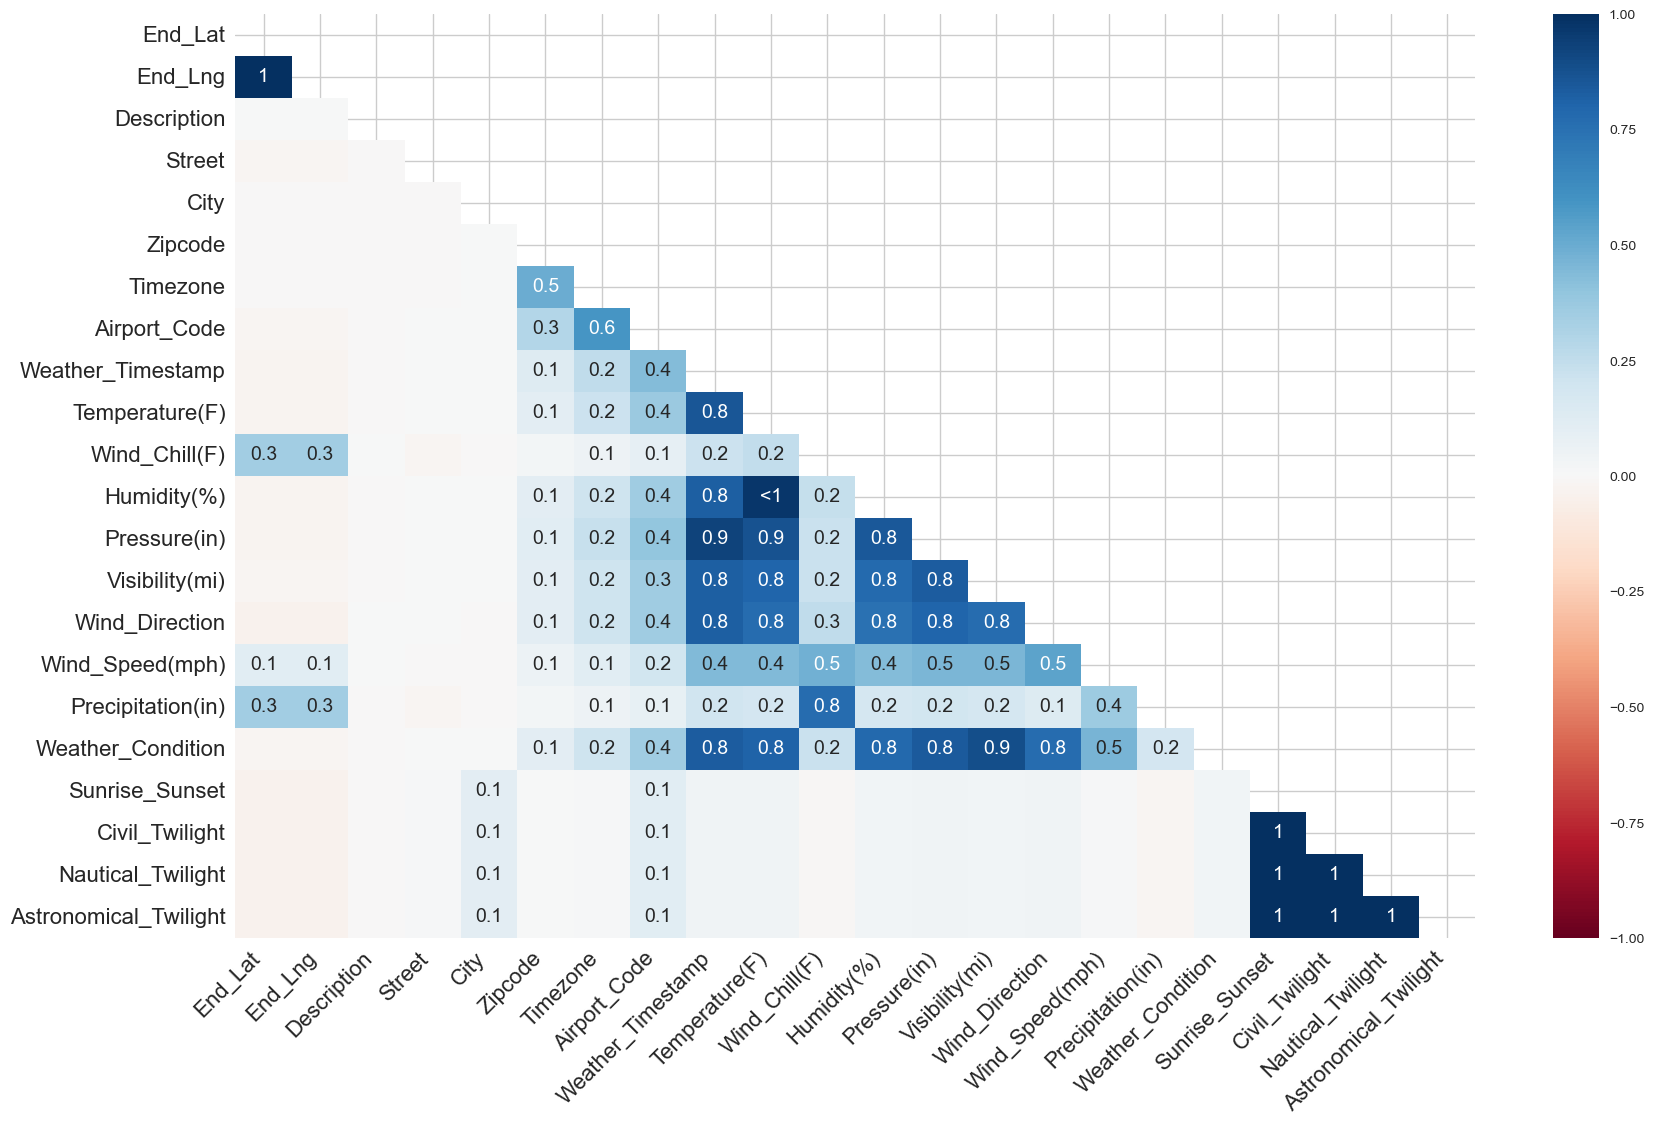

In [19]:
msgno.heatmap(data);

Good to know:
* Confirmed that Latitude/Longitude Data are strictly missing together.

* Weather data seems to be missing together in general but not perfectly missing and not a uniform relationship (Precipitation and Wind Direction for example).

* The day/night variables are strictly missing together.  

### Ending Coordinates

The simplest solution would be to just setting missing end coordinates to the observation's start coordinates.  But is this a common occurence among the observations which none of these variables are missing?

In [20]:
same_startVend = data[(data['Start_Lat']==data['End_Lat']) & (data['Start_Lng']==data['End_Lng'])]

same_startVend.shape[0]/data['End_Lat'].notnull().shape[0]

0.05147227224698948

5% of the observations which have both start & end coordinates.  So it is not uncommon but not frequent enough to make me comfortable changing half of the observations.

We have speculated that there is a relationship between distance feature and the coordinates.  Let's explore that further to inform our decision to handle missing values. 

In [21]:
(same_startVend['Distance(mi)'] > 0).sum()

0

So the distance metric for all of the observations with equal start and end coordinates is 0.

Let's consider the same analysis for those observations missing the end coordinates.

In [22]:
missing_ends = data[data['End_Lat'].isnull()]['Distance(mi)']
missing_ends.describe()

count   3402762.000
mean          0.212
std           1.637
min           0.000
25%           0.000
50%           0.000
75%           0.000
max         441.750
Name: Distance(mi), dtype: float64

In [23]:
(missing_ends==0).sum() / missing_ends.shape[0]

0.8524513321825035

So for a significant portion of the observations missing the end coordinates, the distance metric is also 0.  

What does distance for the rest look like?

In [24]:
data[(data['End_Lat'].isnull()) & (data['Distance(mi)'] > 0)]['Distance(mi)'].describe()

count   502073.000
mean         1.438
std          4.050
min          0.010
25%          0.010
50%          0.010
75%          1.330
max        441.750
Name: Distance(mi), dtype: float64

For these observations (especially the large outliers), it does not appear advisable to force the end coordinates to equal the start.

ACTION DECISION:  Set all missing ending coordinates equal to their starting coordinates.  (Possibility that this feature may ultimately be tossed in the future.)

### Weather
Based on some research and intuition, we can make some decisions on how to handle missing values.

#### Conditions

In [25]:
data.Weather_Condition.isnull().sum()/data.shape[0]

0.02244437848277404

It's only 2% of the data and, as it stands, I have no way have extrapolating how any individual observation should be classified.  Therefore, it is probably safe to remove.

ACTION DECISION: Remove all observations missing the Weather Condition feature.

ACTION DECISION: Drop Missing Temperature.

#### Precipitation, Wind Speed & Wind Direction

In [26]:
(data['Precipitation(in)']==0).sum()/data[data['Precipitation(in)'].notnull()].shape[0]

0.9035097690272675

Most (> 90%) of the observations not missing precipitation have 0. So it doesn't seem unreasonable to set missing values to 0. (It may be worthwhile to check against the weather condition in the future.)

ACTION DECISION: Set missing observations of precipitation to 0.

In [27]:
(data['Wind_Speed(mph)']==0).sum()/data[data['Wind_Speed(mph)'].notnull()].shape[0]

0.1343609568095506

While not as frequent, there are plenty (13%) of observations with wind speed equal to 0.  So it doesn't seem unreasonable to set missing values to 0. (It may be worthwhile to check against the observations wind direction and/or wind chill in the future.)

ACTION DECISION: Set missing observations of wind speed to 0.

In [28]:
data['Wind_Direction'].value_counts(normalize=True,dropna=False)

Wind_Direction
CALM       0.124
S          0.054
SSW        0.050
W          0.050
WNW        0.049
NW         0.048
Calm       0.048
SW         0.047
WSW        0.046
SSE        0.045
NNW        0.043
N          0.040
SE         0.038
E          0.036
ESE        0.035
NE         0.033
ENE        0.033
NNE        0.033
VAR        0.032
South      0.023
NaN        0.023
West       0.021
North      0.020
Variable   0.015
East       0.013
Name: proportion, dtype: float64

A significant portion of the observations have some equivalent of calm, which I interpet it as 0 wind.  So I do not believe it is unreasonable to assume missing values to be the equivalent to 0 wind as well.  (Again, it may be worthwhile to check against the other wind features in the future.)

ACTION DECISION: Set missing observtions of wind direction to 'CALM' or some equivalent.  (Will depend on how I end up cleaning the Wind_Direction feature.)

##### Wind Chill

In [29]:
data[data['Wind_Chill(F)']==data['Temperature(F)']].shape[0]/data.shape[0]

0.5731335643602021

Over half of the observations occur where there is no additional effect on temp from the wind, so I do not think it is too dangerous to set missing wind-chill values equal to the temperture. (It may be worthwhile to check against the wind speed in the future.)

ACTION DECISION: Set missing values of wind chill to the  observation's temperture value.

#### Pressure, Visibility & Humidity

Per this google search https://www.google.com/search?client=safari&rls=en&q=can+air+pressure+be+0&ie=UTF-8&oe=UTF-8, air pressure cannot be 0 (except in a vacuum).  So without any anchor value to use, I do not think it wise to assign missing observations to any value.  

ACTION DECISION: Remove all observations missing a value for the Pressure feature.

There is also no obvious value to use for visibility.

ACTION DECISION: Remove all observations missing a value for the Pressure feature.

In [30]:
(data['Humidity(%)']==0).sum()/data[data['Humidity(%)'].notnull()].shape[0]

0.0

There are no observations with 0% humidity, so we do not have any reasonable anchor value to use once again.  

ACTION DECISION: Remove all observations missing a value for the Humidity feature.

## Duplicates

There are no duplicates to deal with:

In [31]:
if _SPARK_:
    duplicates = int(data.count() - data.dropDuplicates().count())
    duplicates.show()
else:
    print(data.duplicated().sum())

0


Nothing to worry about.

## Outliers

In [32]:
if _SPARK_:
    pass
else:
    print(pd.DataFrame({c:{z:count_outliers(data[c],z) for z in [3,5,10,15,20]} for c in _NUMERICS_}).T)

                       3      5     10    15    20
Severity           204710      0     0     0     0
Distance(mi)       109071  39983  9533  3722  1736
Temperature(F)          0      0     0     0     0
Wind_Chill(F)           0      0     0     0     0
Humidity(%)             0      0     0     0     0
Pressure(in)            0      0     0     0     0
Visibility(mi)          0      0     0     0     0
Wind_Speed(mph)         0      0     0     0     0
Precipitation(in)       0      0     0     0     0


Distance seems to be the only feature in the original dataset (lite or full) that has significant outliers.

In [33]:
print(f'{(data['Distance(mi)'] > 100).sum()} of the observations are greater than 100 miles.  Lets drop these')

86 of the observations are greater than 100 miles.  Lets drop these


ACTION DECISION: Drop observations with distance impacted to be over 100 miles.  

## High-Level Features

### Nature of Accident

We will eventually create another feature to describe the nature of any accident but for now, we have severity (a discrete variable) and distance.

In [34]:
data['Severity'].value_counts(normalize=True)

Severity
2   0.797
3   0.168
4   0.026
1   0.009
Name: proportion, dtype: float64

We have significant class imbalances.  Even though it is unclear what methodology (if any) is used to determine severity, this imbalance makes sense:  Low-impact incidents are likely underreported and the highest-impact incidents are, fortunately, rare. 

In [35]:
data['Distance(mi)'].value_counts(bins=25,normalize=True).sort_index(ascending=True)

(-0.443, 17.67]    0.999
(17.67, 35.34]     0.001
(35.34, 53.01]     0.000
(53.01, 70.68]     0.000
(70.68, 88.35]     0.000
(88.35, 106.02]    0.000
(106.02, 123.69]   0.000
(123.69, 141.36]   0.000
(141.36, 159.03]   0.000
(159.03, 176.7]    0.000
(176.7, 194.37]    0.000
(194.37, 212.04]   0.000
(212.04, 229.71]   0.000
(229.71, 247.38]   0.000
(247.38, 265.05]   0.000
(265.05, 282.72]   0.000
(282.72, 300.39]   0.000
(300.39, 318.06]   0.000
(318.06, 335.73]   0.000
(335.73, 353.4]    0.000
(353.4, 371.07]    0.000
(371.07, 388.74]   0.000
(388.74, 406.41]   0.000
(406.41, 424.08]   0.000
(424.08, 441.75]   0.000
Name: proportion, dtype: float64

We know from exploring this feature's missing values and outliers what the issues for this feature.  The binning makes it seem that there are negative values but this is not the case.

In [36]:
msg = f'{(data['Distance(mi)']==0).sum()/data.shape[0]:.2f} of observations have 0 impact distance and '
msg += f'{(0 > data['Distance(mi)']).sum()} observations with negative impact distance.'

print(msg)

0.43 of observations have 0 impact distance and 0 observations with negative impact distance.


### Time Features

To explore properly, we need to convert to datetime type (from pandas).  Also, need to convert into seconds and then into hours.

It is required to set the 'format' parameter to "mixed".  (Too many observations to understand why / explore observations setting off the error.)


In [37]:
start = pd.to_datetime(data['Start_Time'],format='mixed')
end = pd.to_datetime(data['End_Time'],format='mixed')
time_change = (end - start).astype('timedelta64[s]').dt.seconds/3600
time_change.describe()

count   7728394.000
mean          1.813
std           2.099
min           0.000
25%           0.525
50%           1.246
75%           2.077
max          24.000
dtype: float64

In [38]:
time_change.value_counts(bins=25,normalize=True).sort_index(ascending=True)

(-0.025, 0.96]   0.396
(0.96, 1.92]     0.312
(1.92, 2.88]     0.148
(2.88, 3.84]     0.035
(3.84, 4.8]      0.022
(4.8, 5.76]      0.008
(5.76, 6.72]     0.054
(6.72, 7.68]     0.004
(7.68, 8.64]     0.003
(8.64, 9.6]      0.002
(9.6, 10.56]     0.002
(10.56, 11.52]   0.002
(11.52, 12.48]   0.002
(12.48, 13.44]   0.002
(13.44, 14.4]    0.002
(14.4, 15.36]    0.001
(15.36, 16.32]   0.001
(16.32, 17.28]   0.000
(17.28, 18.24]   0.000
(18.24, 19.2]    0.000
(19.2, 20.16]    0.000
(20.16, 21.12]   0.000
(21.12, 22.08]   0.000
(22.08, 23.04]   0.000
(23.04, 24.0]    0.000
Name: proportion, dtype: float64

For the most part, this distribution makes sense.  Again despite the binning, there are no negative values for the time of impact.

In [39]:
msg = f'{(time_change==0).sum()} of the observations have 0 impact duration and '
msg += f'{(0 > time_change).sum()} observations with negative impact duration.'

print(msg)

186 of the observations have 0 impact duration and 0 observations with negative impact duration.


It is unusual to see that some observations have no duration but it such a small number and purposely possible that it means essentially 0.  So no need to stess.

### Address Features

In [40]:
data['Country'].value_counts()

Country
US    7728394
Name: count, dtype: int64

Confirming that all observations are in the USA so we can infact ignore this featue in the future.

ACTION DECISION: Remove column/feature as part of data cleaning.

In [41]:
_USELESS_.extend(['Country'])

#### Coordinates

In [42]:
coords_count = data.value_counts(['Start_Lat','Start_Lng'])
coords_count.sort_values(ascending=False).head(25)

Start_Lat  Start_Lng
37.808     -122.367     570
33.941     -118.097     561
34.859     -82.260      543
42.477     -83.112      534
33.745     -84.390      530
34.859     -82.260      494
40.848     -73.943      473
25.789     -80.204      439
42.368     -83.058      435
25.899     -80.210      432
33.782     -84.391      428
33.876     -118.103     420
40.850     -73.945      418
34.914     -82.107      416
33.822     -84.359      405
25.964     -80.166      402
34.833     -82.297      390
33.950     -118.092     386
44.966     -93.270      384
25.869     -80.208      379
34.859     -82.260      373
34.010     -117.823     372
25.991     -80.166      371
41.063     -73.862      371
33.722     -84.395      365
Name: count, dtype: int64

In [43]:
if _LITE_SWITCH_: 
    freq_coords = pd.DataFrame(index=coords_count[coords_count > 30].index)
else:
    freq_coords = pd.DataFrame(index=coords_count[coords_count > 250].index)

Interesting, there are almost 2k locations where many many accidents have occured.  These observations may be useful for analysis.  

ACTION DECISION: Create Dataset for observations with overlapping coordinates.

#### State

In [44]:
# Check for bad strings
unclean = data['State'].str.startswith(' ').sum() + data['State'].str.endswith(' ').sum()
unclean

0

There are none to deal with.

In [45]:
data['State'].value_counts(dropna=False,normalize=True)

State
CA   0.225
FL   0.114
TX   0.075
SC   0.050
NY   0.045
NC   0.044
VA   0.039
PA   0.038
MN   0.025
OR   0.023
AZ   0.022
GA   0.022
IL   0.022
TN   0.022
MI   0.021
LA   0.019
NJ   0.018
MD   0.018
OH   0.015
WA   0.014
AL   0.013
UT   0.013
CO   0.012
OK   0.011
MO   0.010
CT   0.009
IN   0.009
MA   0.008
WI   0.004
KY   0.004
NE   0.004
MT   0.004
IA   0.003
AR   0.003
NV   0.003
KS   0.003
DC   0.002
RI   0.002
MS   0.002
DE   0.002
WV   0.002
ID   0.001
NM   0.001
NH   0.001
WY   0.000
ND   0.000
ME   0.000
VT   0.000
SD   0.000
Name: proportion, dtype: float64

California seems very high even adjusting for population and area size.  It appears we do not have data from the territories like Puerto Rico (PR), US Virgin Islands (VI) but we do have data from District of Columbia (DC).Comments & Actions.  Concerns about balance?

#### City

In [46]:
# Same Double Check
unclean = data['City'].str.startswith(' ').sum() + data['City'].str.endswith(' ').sum()
unclean

0

There are no bad string to deal with.

In [47]:
data['City'].value_counts(dropna=False,normalize=True).sort_values(ascending=False).head(25)

City
Miami           0.024
Houston         0.022
Los Angeles     0.020
Charlotte       0.018
Dallas          0.017
Orlando         0.014
Austin          0.013
Raleigh         0.011
Nashville       0.009
Baton Rouge     0.009
Atlanta         0.009
Sacramento      0.009
San Diego       0.007
Phoenix         0.007
Minneapolis     0.007
Richmond        0.006
Oklahoma City   0.006
Jacksonville    0.005
Tucson          0.005
Columbia        0.005
San Antonio     0.005
Greenville      0.005
Saint Paul      0.005
Seattle         0.005
Portland        0.005
Name: proportion, dtype: float64

No concerns with balance (or over-representation).  Interesting to see some of these cities make it in the top 25.

#### Zipcode

In [48]:
unclean = data['Zipcode'].str.startswith(' ').sum() + data['Zipcode'].str.endswith(' ').sum()
unclean

0

No issues.

In [49]:
data['Zipcode'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

Zipcode
91761        0.001
91706        0.001
92407        0.001
92507        0.001
33186        0.001
              ... 
95829-9419   0.000
23464-8533   0.000
33187-1958   0.000
32606-5861   0.000
94401-2213   0.000
Name: proportion, Length: 825095, dtype: float64

Like with city, there doesn't appear to be any concern with the balance.  The syntax with the 4-digit extension (used to tell delivery system a more specific location) should probably be removed since we want consistency.

ACTION DECISION: Force all zipcodes to follow simple five digit syntax.

In [50]:
data['Zipcode'].str.contains(r'[0-9]{5}').sum()

7726479

#### Airport Code

In [51]:
unclean = data['Airport_Code'].str.startswith(' ').sum() + data['Airport_Code'].str.endswith(' ').sum()
unclean

0

No issue.

In [52]:
data['Airport_Code'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

Airport_Code
KCQT   0.015
KRDU   0.014
KMCJ   0.013
KBNA   0.013
KCLT   0.013
        ... 
KIEN   0.000
K8D3   0.000
KAVK   0.000
KY22   0.000
KICR   0.000
Name: proportion, Length: 2046, dtype: float64

The distribution itslef isn't necessarily a concern. However, these codes do not make much sense.  If KCQT is actually a code for an airport, it would be refering to Seattle (WA) and KRDU would be refering to the airport in Raleigh-Durham (NC).  The latter especialy would be surprising from common sense.  Where is LAX?

In [53]:
lax_count = data[data['Airport_Code']=='LAX'].shape[0]
print(f'There are {lax_count} incidents with LAX as its airport code.')

There are 0 incidents with LAX as its airport code.


Upon further review, this may be indication that this feature is not the traditional airport codes but weather stations!  If that is the case, this feature would have limited analytical value (for now).

ACTION DECISION: Remove this feature from the dataset.

In [54]:
_USELESS_.extend(['Airport_Code'])

#### Timezone

In [55]:
data['Timezone'].value_counts(normalize=True,dropna=False)

Timezone
US/Eastern    0.463
US/Pacific    0.267
US/Central    0.213
US/Mountain   0.056
NaN           0.001
Name: proportion, dtype: float64

No information can be gleaned from this feature.  I will be grouping the states later on but in ways that either make sense for analytics or for "real-life" recommendations.

ACTION DECISION: Remove this feature from the dataset.

In [56]:
_USELESS_.extend(['Timezone'])

#### Street Type

In [57]:
unclean = data['Street'].str.startswith(' ').sum() + data['Street'].str.endswith(' ').sum()
unclean

1696520

Actually need to handle this if we are to use this feature and need to make sure it is handled in data processing stage.

In [58]:
streets = data['Street'].str.strip()
unclean = streets.str.startswith(' ').sum() + streets.str.endswith(' ').sum()
unclean

0

Simple fix.

ACTION DECISION: Strip the string feature in data processing.

In [59]:
streets.value_counts(dropna=False,normalize=True).sort_values(ascending=False).head(25)

Street
I-95 N     0.010
I-95 S     0.010
I-5 N      0.009
I-10 E     0.007
I-10 W     0.007
I-5 S      0.007
I-80 W     0.005
I-80 E     0.005
I-405 N    0.004
I-75 N     0.004
I-75 S     0.004
I-90 E     0.003
I-15 N     0.003
I-94 W     0.003
I-90 W     0.003
US-101 N   0.003
I-95       0.003
I-94 E     0.003
I-70 E     0.003
I-15 S     0.002
I-40 W     0.002
I-84 E     0.002
I-35 N     0.002
I-405 S    0.002
I-40 E     0.002
Name: proportion, dtype: float64

Not surprising.  We may want to use this information in feature engineering below.

Need to figure out if there is a consistent syntax for street address.

We are going to use the following resources to consider if we can group these observations based on the street name where the accident is reported to have occured.

__[Google](https://www.google.com/search?q=us+highways+and+interstates&client=safari&sca_esv=a2d3658fd380a756&rls=en&ei=t65JaN2uMMKh5NoPo6mVkQo&oq=US+highways+vs%C2%A0&gs_lp=Egxnd3Mtd2l6LXNlcnAaAhgCIhBVUyBoaWdod2F5cyB2c8KgKgIIADILEAAYgAQYkQIYigUyBxAAGIAEGAoyBRAAGIAEMgYQABgWGB4yBhAAGBYYHjIGEAAYFhgeMgsQABiABBiGAxiKBTILEAAYgAQYhgMYigUyCxAAGIAEGIYDGIoFMggQABiABBiiBEiDTFDVDFjWP3AFeAGQAQCYAXOgAdcKqgEEMTYuMbgBAcgBAPgBAZgCFqACgwzCAgoQABiwAxjWBBhHwgIKEAAYgAQYQxiKBcICERAuGIAEGLEDGNEDGIMBGMcBwgILEAAYgAQYsQMYgwHCAgUQLhiABMICDhAuGIAEGLEDGIMBGNQCwgILEAAYgAQYsQMYiwPCAggQABiABBiLA8ICCBAAGIAEGLEDwgIKEC4YgAQYQxiKBcICERAAGIAEGJECGLEDGIMBGIoFwgIEEAAYA8ICBRAhGKABmAMAiAYBkAYIkgcEMjEuMaAHl26yBwQxNi4xuAfmC8IHBjItMTYuNsgHhwE&sclient=gws-wiz-serp)__ on the difference between US numbered highways and US interstate highway system

__[More granular website](https://99percentinvisible.org/article/beyond-streets-avenues-simple-visual-guide-different-types-roads/)__


Federal Roads.  Highways & Interstates

In [60]:
highways = streets.str.startswith('US').sum() + streets.str.startswith('United States').sum()

interstates = streets.str.startswith('I-').sum() + streets.str.startswith('Interstate').sum()

fed_roads = highways + interstates

msg = f'There are roughly {fed_roads} incidents which occured on a federal roads:  '
msg += f'{highways} on a numbered highways and {interstates} interstates.'

print(msg)

There are roughly 2203298 incidents which occured on a federal roads:  275448 on a numbered highways and 1927850 interstates.


ACTION DECISION: Create feature 'Federal' to flag these 2.2m+ accidents.

In [61]:
highways = streets.str.startswith('US') | streets.str.startswith('United States')
interstates = streets.str.startswith('I-') | streets.str.startswith('Interstate')
fed_roads = highways | interstates

In [62]:
highways = streets[streets.str.contains('Highway',na=False)]
highways.value_counts(dropna=False,normalize=True).sort_values(ascending=False)

Street
Pearl Harbor Memorial Highway   0.014
Highway 101                     0.013
US Highway 19 N                 0.012
Highway 20                      0.012
US Highway 1                    0.010
                                 ... 
652-838 State Highway 299       0.000
641-408 State Highway 299 E     0.000
State Highway 102               0.000
US Highway 425 N                0.000
GA Highway 133 N                0.000
Name: proportion, Length: 5388, dtype: float64

Routes

In [63]:
routes = streets[streets.str.startswith('Rt',na=False) | streets.str.startswith('Route',na=False)]
print(routes.shape[0])
routes.value_counts(dropna=False,normalize=True).sort_values(ascending=False)


16323


Street
Route 9      0.098
Route 22     0.051
Route 6      0.045
Route 146    0.027
Route 82     0.026
              ... 
Route 872    0.000
Route 74 E   0.000
Route 129    0.000
Route 547    0.000
Route 426    0.000
Name: proportion, Length: 405, dtype: float64

In [64]:
routes = streets.str.startswith('Route').sum() + streets.str.startswith('Rt').sum()
routes

16323

### Weather

#### Quantitative Features

In [65]:
weather_factors = ['Temperature(F)','Wind_Chill(F)',
                   'Humidity(%)','Pressure(in)',
                   'Visibility(mi)','Wind_Speed(mph)',
                   'Precipitation(in)']

data[weather_factors].describe()

,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7564541.000,5729375.000,7554250.000,7587715.000,7551296.000,7157161.000,5524808.000
mean,61.663,58.251,64.831,29.539,9.090,7.685,0.008
std,19.014,22.390,22.821,1.006,2.688,5.425,0.110
min,-89.000,-89.000,1.000,0.000,0.000,0.000,0.000
25%,49.000,43.000,48.000,29.370,10.000,4.600,0.000
50%,64.000,62.000,67.000,29.860,10.000,7.000,0.000
75%,76.000,75.000,84.000,30.030,10.000,10.400,0.000
max,207.000,207.000,100.000,58.630,140.000,1087.000,36.470


#### Categorical Features

In [66]:
weather_descriptions = data['Weather_Condition'].unique()
print(f'There are {weather_descriptions.shape[0]} ways that the weather is described in this dataset: \n')
print(weather_descriptions)

There are 145 ways that the weather is described in this dataset: 

['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squal

<Axes: xlabel='Weather_Condition'>

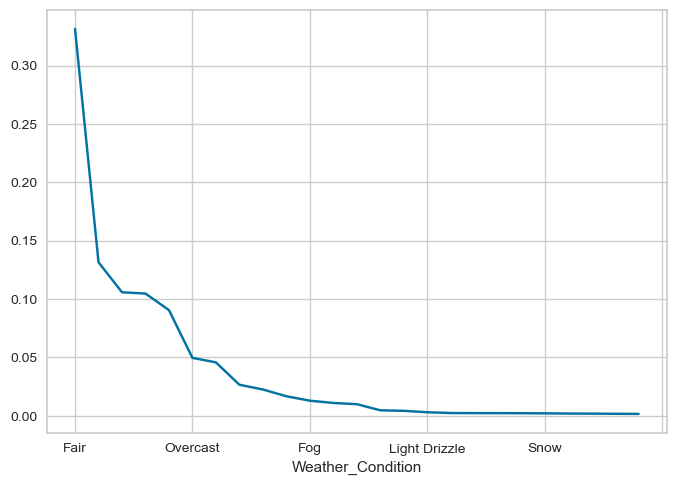

In [67]:
weather_desc_counts = data['Weather_Condition'].value_counts(dropna=False,normalize=True)
weather_desc_counts.sort_values(ascending=False).head(25).plot()

This weather condition feature is too granular to be of any analytical value.  We need to consider consolidating this feature or ignore it all together.  May be of interest to consider how these categories relate to the numeric weather features. 

### Night/Day Features

There appears to be multiple indicators for day/night that need to be explored.  According to __[Google](https://www.google.com/search?q=different+types+of+twilight&rlz=1C5OZZY_enUS1127US1127&oq=different+types+of+twilight&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORiABDIICAEQABgWGB4yCAgCEAAYFhgeMggIAxAAGBYYHjIICAQQABgWGB4yDQgFEAAYhgMYgAQYigUyDQgGEAAYhgMYgAQYigUyDQgHEAAYhgMYgAQYigUyDQgIEAAYhgMYgAQYigUyCggJEAAYgAQYogTSAQg0NjU3ajFqN6gCALACAA&sourceid=chrome&ie=UTF-8)__, Nautical, Astronomical and Civil all have precise definitions--based on usage--that do not, to me, inform as to how their distinctions contribute to understanding accident patterns.  And as you can see below, there is no clear pattern in how they differ from one another in classifying day vs night.

Ultimately, I think dropping all of them except for Sunrise_Sunset is for the best.  

### Night/Day Features

There appears to be multiple indicators for day/night that need to be explored.  According to __[Google](https://www.google.com/search?q=different+types+of+twilight&rlz=1C5OZZY_enUS1127US1127&oq=different+types+of+twilight&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORiABDIICAEQABgWGB4yCAgCEAAYFhgeMggIAxAAGBYYHjIICAQQABgWGB4yDQgFEAAYhgMYgAQYigUyDQgGEAAYhgMYgAQYigUyDQgHEAAYhgMYgAQYigUyDQgIEAAYhgMYgAQYigUyCggJEAAYgAQYogTSAQg0NjU3ajFqN6gCALACAA&sourceid=chrome&ie=UTF-8)__, Nautical, Astronomical and Civil all have precise definitions--based on usage--that do not, to me, inform as to how their distinctions contribute to understanding accident patterns.  

In [68]:
print(pd.crosstab(data['Nautical_Twilight'],data['Astronomical_Twilight']))
print('-'*50)
print(pd.crosstab(data['Nautical_Twilight'],data['Civil_Twilight']))
print('-'*50)
print(pd.crosstab(data['Nautical_Twilight'],data['Sunrise_Sunset']))

Astronomical_Twilight      Day    Night
Nautical_Twilight                      
Day                    6070128     6028
Night                   307420  1321572
--------------------------------------------------
Civil_Twilight         Day    Night
Nautical_Twilight                  
Day                5695619   380537
Night                    0  1628992
--------------------------------------------------
Sunrise_Sunset         Day    Night
Nautical_Twilight                  
Day                5334553   741603
Night                    0  1628992


In [69]:
print(pd.crosstab(data['Astronomical_Twilight'],data['Civil_Twilight']))
print('-'*50)
print(pd.crosstab(data['Astronomical_Twilight'],data['Sunrise_Sunset']))

Civil_Twilight             Day    Night
Astronomical_Twilight                  
Day                    5689968   687580
Night                     5651  1321949
--------------------------------------------------
Sunrise_Sunset             Day    Night
Astronomical_Twilight                  
Day                    5329105  1048443
Night                     5448  1322152


In [70]:
print(pd.crosstab(data['Civil_Twilight'],data['Sunrise_Sunset']))

Sunrise_Sunset      Day    Night
Civil_Twilight                  
Day             5334473   361146
Night                80  2009449


 And as you can see, there is no clear pattern in how they differ from one another in classifying day vs night.

Ultimately, I think dropping all of them except for Sunrise_Sunset is for the best.

ACTION DECISION: Remove Nautical_Twilight, Civil_Twilight, Astronomical_Twilight and leave Sunrise_Sunse.

In [71]:
_USELESS_.extend(['Nautical_Twilight','Civil_Twilight','Astronomical_Twilight'])

### Infrastructure
Twelve binary features indicating the existance of a traffic design or a PoI.

In [72]:
infrastructures = ['Amenity','Bump','Crossing','Give_Way',
                   'Junction','No_Exit','Railway','Roundabout',
                   'Station','Stop','Traffic_Calming','Traffic_Signal',
                   'Turning_Loop'
                   ]

Need to verify what the definitions of each of these are...

In [73]:
data[infrastructures].sum().sort_values(ascending=False)/data.shape[0]

Traffic_Signal    0.148
Crossing          0.113
Junction          0.074
Stop              0.028
Station           0.026
Amenity           0.012
Railway           0.009
Give_Way          0.005
No_Exit           0.003
Traffic_Calming   0.001
Bump              0.000
Roundabout        0.000
Turning_Loop      0.000
dtype: float64

Not surprising.  Although, we need to look at overlap to get a better picture.

How often do these overlap?

In [74]:
full_range = range(0,len(infrastructures))
print('The number of observations where X infrastructure types are found.')
data[infrastructures].sum(axis=1).value_counts().reindex(full_range,fill_value=0)

The number of observations where X infrastructure types are found.


0     5427044
1     1543182
2      609259
3      124709
4       21086
5        2907
6         205
7           2
8           0
9           0
10          0
11          0
12          0
Name: count, dtype: int64

Overwhelming majority have no such infrastructures.

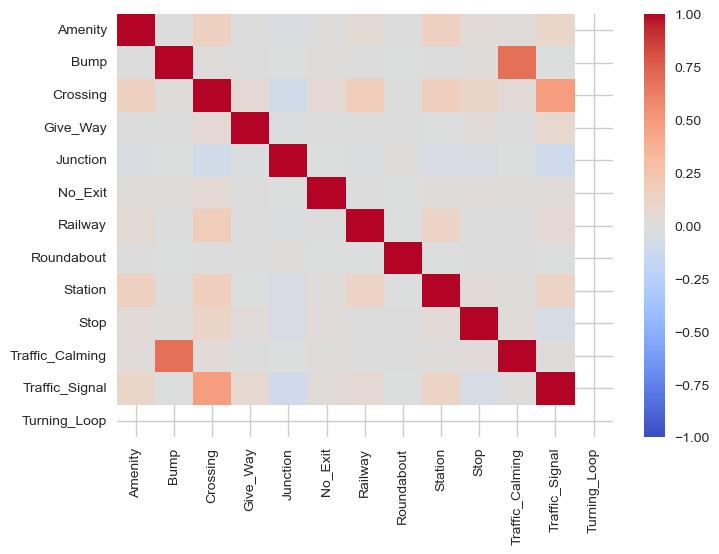

In [75]:
sns.heatmap(data[infrastructures].corr(),vmin=-1,vmax=1,cmap='coolwarm');

This doesn't really tell us anything since we only have data from when accidents occur.  We will want to instead focus on the nature of the accidents and if the existence of any one (or more) reduces the severity, etc.

# 3-Data Processing

Start with a brand new dataset

In [76]:
del data
if _SPARK_:
    spark.stop()
else:
    pass

In [77]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data_clean = spark.read.csv('US_Accidents_March23.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data_clean = pd.read_csv('US_Accidents_March23_sampled_500k.csv',index_col=0)
    else:
        data_clean = pd.read_csv('US_Accidents_March23.csv',index_col=0)
    

In [78]:
if _SPARK_:
    N = data_clean.count()
    D = len(data_clean.columns)
else:
    N = data_clean.shape[1]
    D = data_clean.shape[0]

In [79]:
if _SPARK_:
    data_clean.printSchema()
else:
    data_clean.info()

print("Features: ",D)
print("Entries:  ",N)

<class 'pandas.core.frame.DataFrame'>
Index: 7728394 entries, A-1 to A-7777761
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Source                 object 
 1   Severity               int64  
 2   Start_Time             object 
 3   End_Time               object 
 4   Start_Lat              float64
 5   Start_Lng              float64
 6   End_Lat                float64
 7   End_Lng                float64
 8   Distance(mi)           float64
 9   Description            object 
 10  Street                 object 
 11  City                   object 
 12  County                 object 
 13  State                  object 
 14  Zipcode                object 
 15  Country                object 
 16  Timezone               object 
 17  Airport_Code           object 
 18  Weather_Timestamp      object 
 19  Temperature(F)         float64
 20  Wind_Chill(F)          float64
 21  Humidity(%)            float64
 22  Pressure(in)       

## Drop Unnecessary Columns
Based on prior exploratory work.

In [80]:
print(len(_USELESS_))
print('Going forward, I am completely removing the following features' +' '.join(_USELESS_) + '.')

8
Going forward, I am completely removing the following featuresSource Weather_Timestamp Country Airport_Code Timezone Nautical_Twilight Civil_Twilight Astronomical_Twilight.


In [81]:
data_clean = data_clean.drop(_USELESS_,axis=1)

## Missing Data

### End Coordinates

In [82]:
data_clean['End_Lat'] = data_clean['End_Lat'].fillna(data_clean['Start_Lat'])
data_clean['End_Lng'] = data_clean['End_Lng'].fillna(data_clean['Start_Lng'])

### Weather

In [83]:
drop_missing = ['Weather_Condition','Temperature(F)','Pressure(in)','Visibility(mi)','Humidity(%)']
data_clean = data_clean.dropna(subset = drop_missing)

In [84]:
data_clean['Precipitation(in)'] = data_clean['Precipitation(in)'].fillna(0)
data_clean['Wind_Speed(mph)'] = data_clean['Wind_Speed(mph)'].fillna(0)
data_clean['Wind_Direction'] = data_clean['Wind_Direction'].fillna('CALM')

In [85]:
data_clean['Wind_Chill(F)'] = data_clean['Wind_Chill(F)'].fillna(data_clean['Temperature(F)'])

### Description

In [86]:
# For now...
data_clean = data_clean.dropna(subset = ['Description'])

### Address

In [87]:
# For now...
data_clean = data_clean.dropna(subset = ['Street','Zipcode','City'])

### Day/Night

In [88]:
# For now...
data_clean = data_clean.dropna(subset = ['Sunrise_Sunset'])

## Outliers

In [89]:
condition = data_clean['Distance(mi)'] > 100
data_clean = data_clean[~condition]

## Data Cleaning

In [90]:
data_clean['Street'] = data_clean['Street'].str.strip()

In [91]:
data_clean['Zipcode'] = data_clean['Zipcode'].str.extract(r'([0-9]{5})')

## Feature Engineering

### Impact Duration

In [92]:
if _SPARK_:
    pass
else:
    data_clean['Start'] = pd.to_datetime(data_clean['Start_Time'],format='mixed')
    data_clean['End'] = pd.to_datetime(data_clean['End_Time'],format='mixed')

And create a new target feature describing the nature of the accident as a function of time.

In [93]:
data_clean['Time_of_Impact(hr)'] = (data_clean['End'] - data_clean['Start']).dt.seconds/3600

In [94]:
data_clean['Time_of_Impact(hr)'].describe()

count   7461589.000
mean          1.809
std           2.099
min           0.000
25%           0.520
50%           1.245
75%           2.074
max          24.000
Name: Time_of_Impact(hr), dtype: float64

In [95]:
data_clean = data_clean.drop(['Start_Time','End_Time'],axis=1)

### Partition the time data

In [96]:
if _SPARK_:
    pass
else:
    data_clean['Month'] = data_clean['Start'].dt.month
    data_clean['Year'] = data_clean['Start'].dt.year
    data_clean['DayofYear'] = data_clean['Start'].dt.dayofyear
    data_clean['DayofMonth'] = data_clean['Start'].dt.day
    data_clean['DayofWeek'] = data_clean['Start'].dt.day_of_week
    data_clean['Quarter'] = data_clean['Start'].dt.quarter
    data_clean['Hour'] = data_clean['Start'].dt.hour
    data_clean['Date'] = data_clean['Start'].dt.date

### Explore these new features...

In [97]:
data_clean['Year'].value_counts(normalize=True).sort_index()

Year
2016   0.053
2017   0.093
2018   0.116
2019   0.125
2020   0.153
2021   0.203
2022   0.226
2023   0.032
Name: proportion, dtype: float64

Concering the book end years are so under represented.  Consider removing entirely?

In [98]:
data_clean['Quarter'].value_counts(normalize=True)

Quarter
4   0.295
1   0.254
3   0.228
2   0.223
Name: proportion, dtype: float64

In [99]:
data_clean['Month'].value_counts(normalize=True).sort_index()

Month
1    0.097
2    0.085
3    0.072
4    0.076
5    0.073
6    0.074
7    0.066
8    0.078
9    0.084
10   0.088
11   0.098
12   0.109
Name: proportion, dtype: float64

In [100]:
data_clean['DayofWeek'].value_counts(normalize=True).sort_index()

DayofWeek
0   0.157
1   0.167
2   0.170
3   0.171
4   0.177
5   0.086
6   0.072
Name: proportion, dtype: float64

In [101]:
data_clean['Hour'].value_counts(normalize=True).sort_index()

Hour
0    0.014
1    0.012
2    0.012
3    0.011
4    0.021
5    0.029
6    0.052
7    0.076
8    0.075
9    0.047
10   0.044
11   0.046
12   0.046
13   0.051
14   0.058
15   0.068
16   0.076
17   0.075
18   0.056
19   0.038
20   0.029
21   0.025
22   0.022
23   0.016
Name: proportion, dtype: float64

### Weekend

In [102]:
data_clean['Weekend'] = ((data_clean['DayofWeek'] == 0) | (data_clean['DayofWeek'] == 6))

In [103]:
print(f'There are {data_clean['Weekend'].sum()} observations which occured over the weekend.')
data_clean.groupby('Weekend')['Severity'].mean()

There are 1705249 observations which occured over the weekend.


Weekend
False   2.208
True    2.224
Name: Severity, dtype: float64

### Holidays
Per __[Google](https://www.google.com/search?client=safari&rls=en&q=holidays+with+most+traffic&ie=UTF-8&oe=UTF-8)__, there are a number of holidays in the US with the highest amount of traffic.  (I subbed NYE in for XMas.)

In [104]:
thanksgivings = [get_thanksgiving_date(y) for y in range(2016,2024)]
memorials = [calculate_memorial_day(y) for y in range(2016,2024)]
labors = [get_labor_day(y) for y in range(2016,2024)]

In [105]:
july_4 = ((data_clean['Month'] == 7) & (data_clean['DayofMonth'] == 4))
thanksgiving = data_clean['Date'].apply(lambda d:d in thanksgivings)
memorial = data_clean['Date'].apply(lambda d:d in memorials)
labor = data_clean['Date'].apply(lambda d:d in labors)
nye = ((data_clean['Month'] == 12) & (data_clean['DayofMonth'] == 31))

In [106]:
holidays = (july_4 | thanksgiving | memorial | labor | nye)
data_clean['Holiday'] = holidays

In [107]:
info = f'''{holidays.sum()} incidents occured on a prime holiday.'''

print(info)

74954 incidents occured on a prime holiday.


### Rush Hour Indicator

__[Per Google:  ](https://www.google.com/search?client=safari&rls=en&q=rush+hour+typically&ie=UTF-8&oe=UTF-8)__ The morning rush hour begins around 6a, peaking between 7a & 9a, and eases off by 10a.  While afternoon/evening rush hour begins around 3p, peaking between 4p and 6p, and eases off by 7p.

In [108]:
data_clean['Morning_Rush'] = ((6 > data_clean['DayofWeek']) & (data_clean['DayofWeek'] > 0) & (data_clean['Start'].dt.hour >= 6) & (10 >= data_clean['Start'].dt.hour))

In [109]:
print(f'Total of {data_clean['Morning_Rush'].sum()} incidents during the morning rush hour')

Total of 1728977 incidents during the morning rush hour


In [110]:
data_clean['Evening_Rush'] = ((6 > data_clean['DayofWeek']) & (data_clean['DayofWeek'] > 0) & (data_clean['Start'].dt.hour >= 15) & (19 >= data_clean['Start'].dt.hour))

In [111]:
print(f'Total of {data_clean['Evening_Rush'].sum()} incidents during the evening rush hour')

Total of 1823851 incidents during the evening rush hour


In [112]:
data_clean['Rush_Hour'] = data_clean['Evening_Rush'] | data_clean['Morning_Rush']

### Attach Location-Based Data to DF

Resources

https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html


https://apps.bea.gov/regional/geography.htm

https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States

https://www2.census.gov/geo/pdfs/reference/GARM/Ch6GARM.pdf


https://en.wikipedia.org/wiki/Megaregions_of_the_United_States

In [113]:
df = pd.read_csv('States.csv')
data_clean = data_clean.join(df.set_index('Abbreviation'),on='State',rsuffix='_Full')
del df
data_clean

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Start,End,Time_of_Impact(hr),Month,Year,DayofYear,DayofMonth,DayofWeek,Quarter,Hour,Date,Weekend,Holiday,Morning_Rush,Evening_Rush,Rush_Hour,State_Full,Region,SubRegion,Agency Admin Region,Bureau of Economic Analysis
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1,3,39.865,-84.059,39.865,-84.059,0.010,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,36.900,36.900,91.000,29.680,10.000,Calm,0.000,0.020,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,2016-02-08 05:46:00,2016-02-08 11:00:00,5.233,2,2016,39,8,0,1,5,2016-02-08,True,False,False,False,False,Ohio,Midwest,East North Central,V,Great Lakes
A-2,2,39.928,-82.831,39.928,-82.831,0.010,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068,37.900,37.900,100.000,29.650,10.000,Calm,0.000,0.000,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,2016-02-08 06:07:59,2016-02-08 06:37:59,0.500,2,2016,39,8,0,1,6,2016-02-08,True,False,False,False,False,Ohio,Midwest,East North Central,V,Great Lakes
A-3,2,39.063,-84.033,39.063,-84.033,0.010,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,36.000,33.300,100.000,29.670,10.000,SW,3.500,0.000,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,2016-02-08 06:49:27,2016-02-08 07:19:27,0.500,2,2016,39,8,0,1,6,2016-02-08,True,False,False,False,False,Ohio,Midwest,East North Central,V,Great Lakes
A-4,3,39.748,-84.206,39.748,-84.206,0.010,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,35.100,31.000,96.000,29.640,9.000,SW,4.600,0.000,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,2016-02-08 07:23:34,2016-02-08 07:53:34,0.500,2,2016,39,8,0,1,7,2016-02-08,True,False,False,False,False,Ohio,Midwest,East North Central,V,Great Lakes
A-5,2,39.628,-84.188,39.628,-84.188,0.010,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,36.000,33.300,89.000,29.650,6.000,SW,3.500,0.000,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,2016-02-08 07:39:07,2016-02-08 08:09:07,0.500,2,2016,39,8,0,1,7,2016-02-08,True,False,False,False,False,Ohio,Midwest,East North Central,V,Great Lakes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A-7777757,2,34.002,-117.379,33.999,-117.371,0.543,At Market St - Accident.,Pomona Fwy E,Riverside,Riverside,CA,92501,86.000,86.000,40.000,28.920,10.000,W,13.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,2019-08-23 18:03:25,2019-08-23 18:32:01,0.477,8,2019,235,23,4,3,18,2019-08-23,False,False,False,True,True,California,West,Pacific,IX,Far West
A-7777758,2,32.767,-117.148,32.766,-117.154,0.338,At Camino Del Rio/Mission Center Rd - Accident.,I-8 W,San Diego,San Diego,CA,92108,70.000,70.000,73.000,29.390,10.000,SW,6.000,0.000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,2019-08-23 19:11:30,2019-08-23 19:38:23,0.448,8,2019,235,23,4,3,19,2019-08-23,False,False,False,True,True,California,West,Pacific,IX,Far West
A-7777759,2,33.775,-117.848,33.777,-117.857,0.561,At Glassell St/Grand Ave - Accident. in the ri...,Garden Grove Fwy,Orange,Orange,CA,92866,73.000,73.000,64.000,29

In [114]:
data_clean['AA_Region'] = data_clean['Agency Admin Region']
data_clean['BEA_Region'] = data_clean['Bureau of Economic Analysis']

data_clean = data_clean.drop(['Agency Admin Region','Bureau of Economic Analysis'],axis=1)

### Consider Street Type Feature(s)

#### Federal Roads

In [115]:
streets = data_clean['Street']
highways = streets.str.startswith('US') | streets.str.startswith('United States')
interstates = streets.str.startswith('I-') | streets.str.startswith('Interstate')
data_clean['Federal'] = highways | interstates

## Create State/Commute Dataframe

In [116]:
df1 = data_clean.groupby(['State_Full','Year'])[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()
df2 = data_clean.value_counts(['State_Full','Year'])
print(df1.shape,df2.shape)
df3 = df1.join(df2)
print(df3.shape)
df4 =all_commutes.set_index(['NAME','Year'])
print(df4.shape)
state_commute = df3.join(df4,on=['State_Full','Year'])
state_commute

(388, 3) (388,)
(388, 4)
(416, 13)


Severity  Time_of_Impact(hr)  Distance(mi)  count  DriveAlone  Carpool   Bus  Subway  LongDistanceRail  LightRail  Taxi  Motorcycle  Bicycle  Walked  Other  WorkFromHome  Ferry
State_Full Year                                                                                                                                                                                  
Alabama    2016     2.725               6.000         1.560    131       0.861    0.080 0.003   0.000             0.000      0.000 0.001       0.001    0.001   0.012  0.007         0.033  0.000
           2017     2.588               1.804         0.333   2852       0.857    0.085 0.003   0.000             0.000      0.000 0.001       0.001    0.001   0.012  0.007         0.034  0.000
           2018     2.413               0.753         0.184  13910       0.863    0.079 0.003   0.000             0.000      0.000 0.000       0.001    0.001   0.011  0.008         0.035  0.000
           2019     2.273               1.147         0.167  18974       0.852    0.087 0.004   0.000             0.000      0.000 0.001       0.001    0.001   0.012  0.008         0.034  0.000
           2020     2.219               1.656         0.576  19520       0.852    0.087 0.004   0.000             0.000      0.000 0.001       0.001    0.001   0.012  0.008         0.034  0.000
...                   ...                 ...           ...    ...         ...      ...   ...     ...               ...        ...   ...         ...      ...     ...    ...           ...    ...
Wyoming    2019     3.140               0.835        11.344    107       0.769    0.115 0.012   0.000             0.000      0.000 0.000       0.002    0.010   0.030  0.005         0.057  0.000
           2020     3.231               1.686        13.659     26       0.769    0.115 0.012   0.000             0.000      0.000 0.000       0.002    0.010   0.030  0.005         0.057  0.000
           2021     2.225               2.058         2.812    703       0.759    0.092 0.008   0.000             0.000      0.000 0.000       0.001    0.008   0.034  0.009         0.089  0.000
           2022     2.208               1.912         3.253   1729       0.762    0.082 0.009   0.000             0.000      0.000 0.000       0.003    0.009   0.035  0.008         0.091  0.000
           2023     2.219               1.816         1.955    301       0.728    0.105 0.010   0.000             0.000      0.000 0.001       0.001    0.009   0.034  0.009         0.102  0.001

[388 rows x 17 columns]

In [117]:
state_commute['Non-Car'] = state_commute['Motorcycle'] + state_commute['Walked'] + state_commute['Bicycle']
state_commute['Public'] = state_commute['Bus'] + state_commute['Taxi']
state_commute['Non-Road'] = state_commute['Ferry'] + state_commute['LongDistanceRail'] + state_commute['LightRail']+ state_commute['Subway']
state_commute['None'] = state_commute['Other'] + state_commute['WorkFromHome']

In [118]:
del df1, df2, df3, df4
state_commute.to_csv('State_Commute_Target.csv')

## Summary of Changes

In [119]:
if _SPARK_:
    N_New = data_clean.count()
    D_New = len(data_clean.columns)
else:
    N_New = data_clean.shape[1]
    D_New = data_clean.shape[0]

In [120]:
chng_D = 'added' if (D_New - D)>0 else 'dropped'
msg = f'We now have {N_New} entries and have {chng_D} {D_New-D} features for a total of {D_New}.'
print(msg)

We now have 57 entries and have dropped -266805 features for a total of 7461589.


## Saveout Data

In [121]:
if _LITE_SWITCH_:
    data_clean.to_csv('AccidentData_Sampled_Clean.csv')
else:
    data_clean.to_csv('AccidentData_Clean.csv')

In [122]:
del data_clean
if _SPARK_:
    spark.stop()
else:
    pass

# 4-Full EDA
Now with cleaned up data with additional features, there are still some areas of exploration that I want to cover to help inform A) possible other features and B) the statistical analyses.

In [123]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean.csv',index_col=0)
    else:
        data = pd.read_csv('AccidentData_Clean.csv',index_col=0)
    

In [124]:
if _SPARK_:
    data.printSchema()
    print("Features: ",len(data.columns))
    print("Entries:  ",data.count())
else:
    data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7461589 entries, A-1 to A-7777761
Data columns (total 57 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Severity            int64  
 1   Start_Lat           float64
 2   Start_Lng           float64
 3   End_Lat             float64
 4   End_Lng             float64
 5   Distance(mi)        float64
 6   Description         object 
 7   Street              object 
 8   City                object 
 9   County              object 
 10  State               object 
 11  Zipcode             int64  
 12  Temperature(F)      float64
 13  Wind_Chill(F)       float64
 14  Humidity(%)         float64
 15  Pressure(in)        float64
 16  Visibility(mi)      float64
 17  Wind_Direction      object 
 18  Wind_Speed(mph)     float64
 19  Precipitation(in)   float64
 20  Weather_Condition   object 
 21  Amenity             bool   
 22  Bump                bool   
 23  Crossing            bool   
 24  Give_Way            bool 

In [125]:
if _SPARK_:
    missing = data.select(*[F.sum(F.isnull(F.col(c)).cast("int")).alias(c) for c in data.columns])
    print(missing.show(vertical=True))
else:
    print(data.isna().sum().sort_values(ascending=False))

Severity              0
Station               0
Traffic_Calming       0
Traffic_Signal        0
Turning_Loop          0
Sunrise_Sunset        0
Start                 0
End                   0
Time_of_Impact(hr)    0
Month                 0
Year                  0
DayofYear             0
DayofMonth            0
DayofWeek             0
Quarter               0
Hour                  0
Date                  0
Weekend               0
Holiday               0
Morning_Rush          0
Evening_Rush          0
Rush_Hour             0
State_Full            0
Region                0
SubRegion             0
AA_Region             0
BEA_Region            0
Stop                  0
Roundabout            0
Start_Lat             0
Railway               0
Start_Lng             0
End_Lat               0
End_Lng               0
Distance(mi)          0
Description           0
Street                0
City                  0
County                0
State                 0
Zipcode               0
Temperature(F)  

In [126]:
_TARGET_ = ['Severity']
_NUMERICS_ = ['Distance(mi)','Time_of_Impact(hr)','Temperature(F)',
              'Wind_Chill(F)','Humidity(%)','Pressure(in)',
              'Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']

## Nature of Incident Variables

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


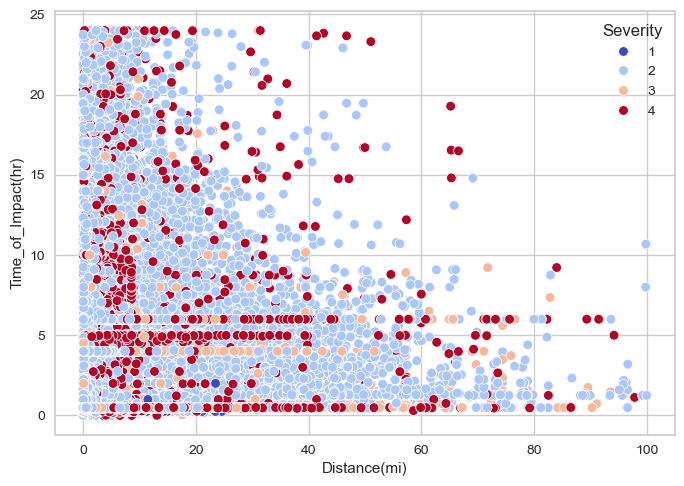

In [127]:
sns.scatterplot(data=data,x='Distance(mi)',y='Time_of_Impact(hr)',hue='Severity',palette='coolwarm');

Nothing to deduce from this scatter plot. 

## Relationships between Continous Variables

In [128]:
if _SPARK_:
    corr_data = data.select(_NUMERICS_+['Severity'])
    col_names = corr_data.columns
    features = corr_data.rdd.map(lambda row: row[0:]) 
    corrs = Statistics.corr(features, method="pearson")
else:
    corrs = data[_NUMERICS_].corr()
    print(corrs)
   

                    Distance(mi)  Time_of_Impact(hr)  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Precipitation(in)
Distance(mi)               1.000               0.150          -0.056         -0.061        0.009        -0.096          -0.040            0.019              0.004
Time_of_Impact(hr)         0.150               1.000          -0.014         -0.013       -0.009        -0.007           0.005            0.007             -0.004
Temperature(F)            -0.056              -0.014           1.000          0.994       -0.332         0.109           0.217            0.043             -0.003
Wind_Chill(F)             -0.061              -0.013           0.994          1.000       -0.313         0.117           0.219           -0.007             -0.002
Humidity(%)                0.009              -0.009          -0.332         -0.313        1.000         0.116          -0.385           -0.182              0.082
Pressure(in)          

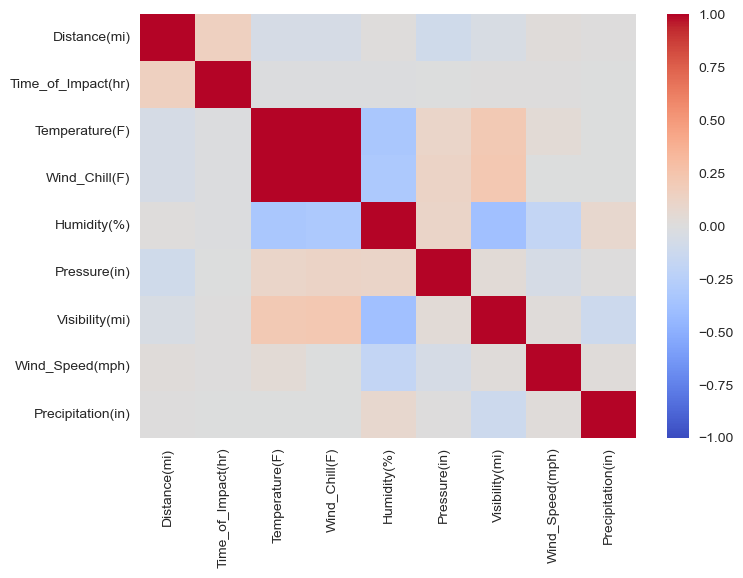

In [129]:
sns.heatmap(corrs,vmin=-1,vmax=1,cmap='coolwarm');

Nothing particularly interesting here.  Mostly intiutive relationships bear out.

## Dates

In [130]:
first = pd.to_datetime(data['Start'].min())
last = pd.to_datetime(data['Start'].max())
print(f'Earliest date is {first}.')
print(f'Latest date is {last}.')
days = (last - first).days
print(f'A total of {days} days.')

Earliest date is 2016-01-14 20:18:33.
Latest date is 2023-03-31 23:30:00.
A total of 2633 days.


In [131]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
months = [
            'January','February','March','April','May','June',
            'July','August','September','October','November','December'
         ]
counts = {}
counts['Total'] = (last - first).days
for i in range(0,len(days)):
    count = count_daytype(first,last,lambda d:(d.weekday() == i))
    counts[days[i]] = count
for i in range(1,5):
    counts['Q'+str(i)] = count_daytype(first,last,lambda d:(d.quarter == i))
for i in range(1,12):
    counts[months[i]] = count_daytype(first,last,lambda d:(d.month == i))
counts['Weekend'] = counts['Saturday'] + counts['Sunday']
counts['Weekday'] = counts['Total'] - counts['Weekend']
counts

{'Total': 2633,
 'Monday': 376,
 'Tuesday': 376,
 'Wednesday': 376,
 'Thursday': 377,
 'Friday': 377,
 'Saturday': 376,
 'Sunday': 376,
 'Q1': 709,
 'Q2': 637,
 'Q3': 644,
 'Q4': 644,
 'February': 235,
 'March': 226,
 'April': 248,
 'May': 210,
 'June': 217,
 'July': 210,
 'August': 217,
 'September': 217,
 'October': 210,
 'November': 217,
 'December': 210,
 'Weekend': 752,
 'Weekday': 1881}

In [132]:
if _SPARK_:
    accdidents_year = data.stat.crosstab('Year','Severity')
else:
    accdidents_year = pd.crosstab(data['Year'],data['Severity'])

    accdidents_year['Total']=accdidents_year.sum(axis=1)
    accdidents_year['Average']=accdidents_year.apply(lambda r:sum(i*r[i] for i in range(1,5))/r['Total'],axis=1)
    accidents_calendar = pd.pivot_table(data,columns='Year',index='Month',values='Severity')
    accidents_calendar = pd.pivot_table(data,columns='Year',index='Quarter',values='Severity')

In [133]:
display(accdidents_year)
print('*'*75)
print('Average Severity by Month in Dataset:')
display(accidents_calendar)

Severity,1,2,3,4,Total,Average
Year,,,,,,
2016,219,262186,121941,13675,398021,2.375
2017,270,448819,222774,23138,695001,2.387
2018,252,558998,281929,24564,865743,2.382
2019,198,670452,231764,27073,929487,2.307
2020,27922,900039,180107,29843,1137911,2.186
2021,147,1338598,144717,28572,1512034,2.133
2022,36543,1536980,74467,39250,1687240,2.069
2023,0,229630,0,6522,236152,2.055


***************************************************************************
Average Severity by Month in Dataset:


Year,2016,2017,2018,2019,2020,2021,2022,2023
Quarter,,,,,,,,
1,2.449,2.376,2.395,2.362,2.226,2.128,2.107,2.055
2,2.389,2.407,2.396,2.349,2.229,2.158,2.057,NaN
3,2.372,2.384,2.383,2.298,2.262,2.134,2.058,NaN
4,2.368,2.385,2.357,2.242,2.114,2.121,2.053,NaN


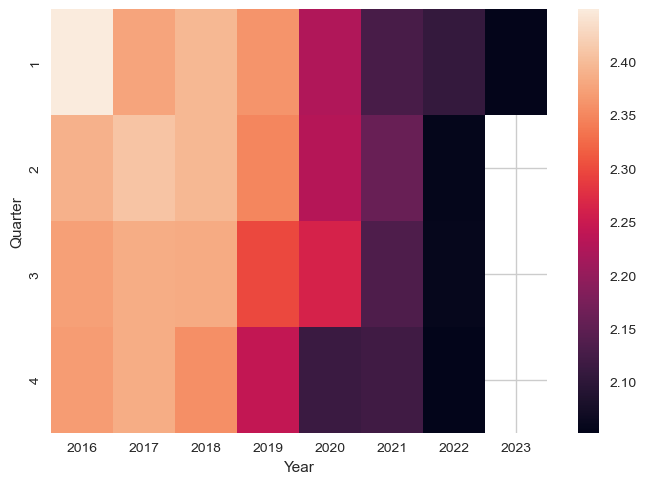

In [134]:
sns.heatmap(accidents_calendar);

## Locations

In [135]:
coords_count = data.value_counts(['Start_Lat','Start_Lng'])
coords_count

Start_Lat  Start_Lng
37.808     -122.367     569
33.941     -118.097     560
34.859     -82.260      542
42.477     -83.112      534
33.745     -84.390      528
                       ... 
34.844     -80.932        1
           -87.653        1
           -80.932        1
           -82.431        1
49.002     -122.474       1
Name: count, Length: 2905569, dtype: int64

In [136]:
if _LITE_SWITCH_: 
    freq_coords = pd.DataFrame(index=coords_count[coords_count > 30].index)
else:
    freq_coords = pd.DataFrame(index=coords_count[coords_count > 250].index)

## Road Types

In [137]:
data.groupby('State')['Federal'].sum().sort_values(ascending=False)

State
CA    463555
FL    175134
TX    144861
VA    103172
MN     93815
NC     74061
PA     73617
SC     72434
TN     64824
NY     61470
OR     53503
MI     51115
CO     47290
UT     46936
MO     44978
OH     42686
WA     41248
NJ     36757
IN     35043
IL     34849
AL     34177
LA     33078
GA     29479
CT     29465
MD     26678
AZ     23835
MA     21455
WI     19641
MT     16458
IA     14772
KS     13139
AR     12545
KY     10834
NV      9534
WV      9453
MS      8981
RI      8461
OK      7598
NE      5879
ID      4036
DC      3325
NH      3308
NM      3084
WY      2905
DE      1947
ND      1902
ME      1569
VT       370
SD        53
Name: Federal, dtype: int64

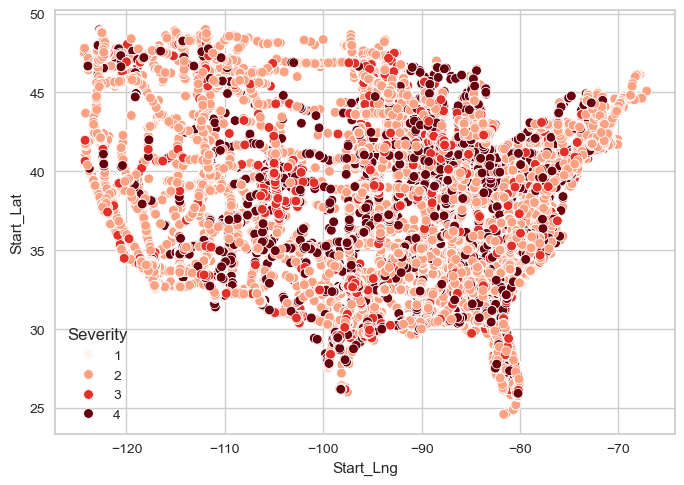

In [138]:
sns.scatterplot(data[data['Federal']],
                x='Start_Lng',y='Start_Lat',
                hue='Severity',palette='Reds');

In [139]:
federal_by_state = data[data.Federal].groupby('State')
federal_by_state = federal_by_state[['Severity','Distance(mi)','Time_of_Impact(hr)']]
federal_by_state = federal_by_state.mean()
federal_by_state

,Severity,Distance(mi),Time_of_Impact(hr)
State,,,
AL,2.418,1.028,1.665
AR,2.177,2.028,1.729
AZ,2.293,1.515,1.977
CA,2.313,0.768,1.955
CO,2.550,1.195,1.697
CT,2.340,1.183,2.205
DC,2.214,0.669,2.268
DE,2.341,1.071,2.155
FL,2.364,1.248,2.004


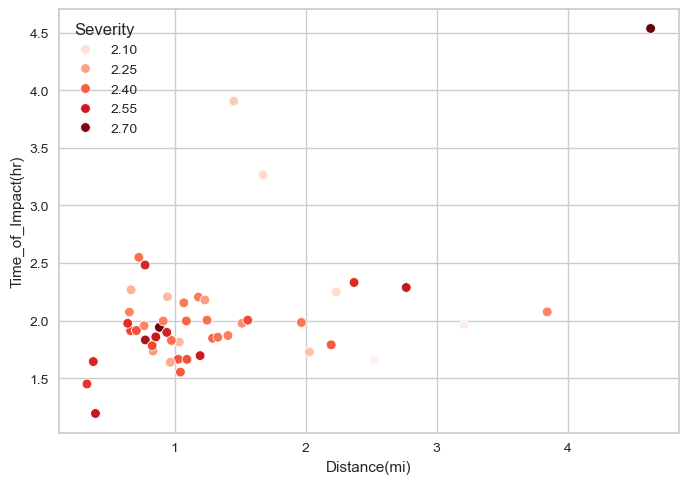

In [140]:
sns.scatterplot(federal_by_state,x='Distance(mi)',y='Time_of_Impact(hr)',
                hue='Severity',palette='Reds');

## Infrastructure

In [141]:
data[_INFRASTRUCTURE_].sum().sort_values(ascending=False)

Traffic_Signal     1115544
Crossing            854458
Junction            548978
Stop                207292
Station             196573
Amenity              93604
Railway              64510
Give_Way             35138
No_Exit              19107
Traffic_Calming       7351
Bump                  3422
Roundabout             244
Turning_Loop             0
dtype: int64

### Relation to Accident Nature

In [142]:
differences = pd.DataFrame(index=infrastructures,columns=['Severity','Distance','Time_of_Impact'])
for infrastructure in infrastructures:
    if(data[infrastructure].sum() > 0):
        diff = data.groupby(infrastructure)[['Severity','Distance(mi)','Time_of_Impact(hr)']].mean().diff()
        differences.loc[infrastructure] = diff.loc[True].tolist()
    else:
        pass
differences

,Severity,Distance,Time_of_Impact
Amenity,-0.144,-0.431,-0.091
Bump,-0.116,-0.320,-0.003
Crossing,-0.167,-0.497,-0.196
Give_Way,-0.039,-0.249,-0.264
Junction,0.095,0.210,0.374
No_Exit,-0.100,-0.334,0.046
Railway,-0.060,-0.329,-0.108
Roundabout,-0.142,-0.440,-0.208
Station,-0.141,-0.434,0.145
Stop,-0.141,-0.342,-0.172


### Overlap

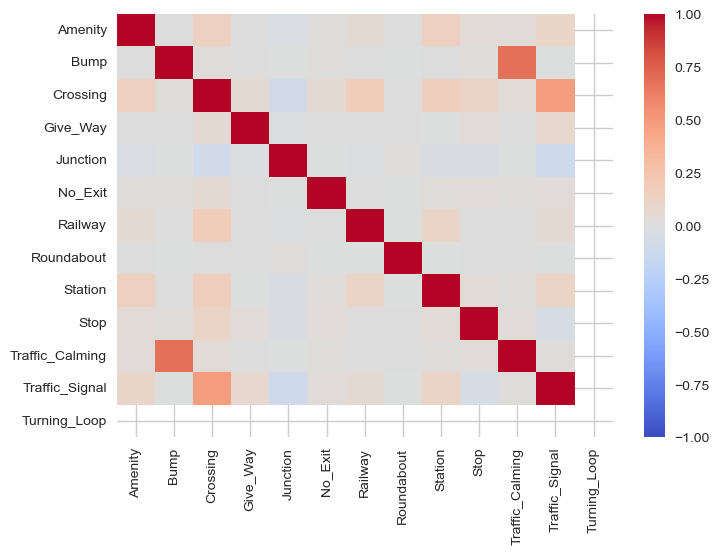

In [143]:
sns.heatmap(data[infrastructures].corr(),vmin=-1,vmax=1,cmap='coolwarm');

In [144]:
infra_counts = data[infrastructures].sum(axis=1)
infra_counts.sort_values(ascending=False)

ID
A-5016751    7
A-4541204    7
A-964556     6
A-5485979    6
A-3823371    6
            ..
A-3151632    0
A-3151631    0
A-3151630    0
A-3151628    0
A-7777761    0
Length: 7461589, dtype: int64

In [ ]:
#data_temp = data[infrastructures+['Severity','']].copy()

: 

## Weather

In [9]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean.csv')
    else:
        data = pd.read_csv('AccidentData_Clean.csv')
    

### Weather-Wind Direction

In [10]:
map_full = {
            'Calm':'0','CALM':'0',
            'SW':'SW','SSW':'SSW','SE':'SE','SSE':'SSE','S':'S',
            'WSW':'WSW','WNW':'WNW','W':'W',
            'NW':'NW','NNW': 'NNW','NNE':'NNE','NE':'NE','N':'N',
            'ESE':'ESE','ENE':'ENE','E':'E',
            'South':'S','North':'N','West':'W','East':'E',
            'Variable':'VAR','VAR':'VAR'
           }

map_second = {
            'Calm':'0','CALM':'0',
            'SW':'SW','SSW':'SW','SE':'SE','SSE':'SE','S':'S',
            'WSW':'SW','WNW':'NW','W':'W',
            'NW':'NW','NNW': 'NW','NNE':'NE','NE':'NE','N':'N',
            'ESE':'SE','ENE':'NE','E':'E',
            'South':'S','North':'N','West':'W','East':'E',
            'Variable':'VAR','VAR':'VAR'
          }

map_first = {
            'Calm':'0','CALM':'0',
            'SW':'SW','SSW':'S','SE':'SE','SSE':'S','S':'S',
            'WSW':'W','WNW':'W','W':'W',
            'NW':'NW','NNW': 'N','NNE':'N','NE':'NE','N':'N',
            'ESE':'E','ENE':'E','E':'E',
            'South':'S','North':'N','West':'W','East':'E',
            'Variable':'VAR','VAR':'VAR'
          }



In [11]:
wind_directions = data['Wind_Direction'].value_counts(normalize=True,dropna=False)
wind_directions.sort_values(ascending=False)

Wind_Direction
CALM       0.131
S          0.055
SSW        0.051
W          0.051
WNW        0.050
NW         0.049
Calm       0.049
SW         0.048
WSW        0.047
SSE        0.046
NNW        0.044
N          0.040
SE         0.039
E          0.037
ESE        0.035
ENE        0.034
NE         0.034
NNE        0.034
VAR        0.033
South      0.024
West       0.022
North      0.018
Variable   0.015
East       0.014
Name: proportion, dtype: float64

In [12]:
data['Wind_Direction'].map(map_full).value_counts(normalize=True,dropna=False).sort_values(ascending=False)

Wind_Direction
0     0.180
S     0.079
W     0.072
N     0.059
SSW   0.051
E     0.051
WNW   0.050
NW    0.049
SW    0.048
VAR   0.048
WSW   0.047
SSE   0.046
NNW   0.044
SE    0.039
ESE   0.035
ENE   0.034
NE    0.034
NNE   0.034
Name: proportion, dtype: float64

In [13]:
data['Wind_Direction'].map(map_second).value_counts(normalize=True,dropna=False).sort_values(ascending=False)

Wind_Direction
0     0.180
SW    0.146
NW    0.143
SE    0.121
NE    0.102
S     0.079
W     0.072
N     0.059
E     0.051
VAR   0.048
Name: proportion, dtype: float64

In [14]:
data['Wind_Direction'].map(map_first).value_counts(normalize=True,dropna=False).sort_values(ascending=False)

Wind_Direction
0     0.180
S     0.176
W     0.169
N     0.137
E     0.120
NW    0.049
SW    0.048
VAR   0.048
SE    0.039
NE    0.034
Name: proportion, dtype: float64

In [15]:
data['Wind_Direction_Original'] = data['Wind_Direction']
data['Wind_Direction_Sub2'] = data['Wind_Direction_Original'].map(map_full)
data['Wind_Direction_Sub1'] = data['Wind_Direction_Original'].map(map_second)
data['Wind_Direction'] = data['Wind_Direction_Original'].map(map_first)
data = data.drop(['Wind_Direction_Original'],axis = 1)
data.shape[0]

7461589

### Weather Conditions

In [16]:
weather_descriptions = data.Weather_Condition.unique()
print(f'There are {weather_descriptions.shape[0]} ways that the weather is described in this dataset: \n')
print(weather_descriptions)

There are 142 ways that the weather is described in this dataset: 

['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Light Rain / Windy' 'Hail' 'Heavy Drizzle'
 'Showers in the Vicinity' 'Light Rain Shower' 'Light Rain with Thunder'
 'Mostly Cloudy / Windy' 'Partly Cloudy / Windy' 'Thunder in the Vicinity'
 'T-Storm' 'Heavy Thunderstorms and Rain' 'Thunderstorm' 'Thunder'
 'Heavy T-Storm' 'Funnel Cloud' 'Heavy T-Storm / Windy' 'Blowing Snow'
 'Light Thunderstorms and Snow' 'Heavy Snow' 'Low Drifting Snow'
 'Light Ice Pellets' 'Ice Pellets' 'Squalls' '

In [17]:
description_counts = data.Weather_Condition.value_counts(dropna=False,normalize=True)
description_counts.sort_values(ascending=False)

Weather_Condition
Fair                          0.338
Mostly Cloudy                 0.135
Cloudy                        0.108
Clear                         0.107
Partly Cloudy                 0.093
                               ... 
Sand / Windy                  0.000
Heavy Rain Shower / Windy     0.000
Blowing Snow Nearby           0.000
Heavy Freezing Rain / Windy   0.000
Drifting Snow                 0.000
Name: proportion, Length: 142, dtype: float64

In [18]:
description_counts.to_csv('condition_counts.csv')

To use this feature, we need to consolidate somehow.

### Exploration of Weather Condition Consolidation

Notice that there are a number of conditions that follow  'Condition/Windy' pattern.  This may be worth exploring as a way to consolidate the data...especially, if we can conclude that the lack of 'Windy' in the description indicates the absence of wind.  

In [19]:
data['Wind_Condition'] = data.Weather_Condition.str.contains(r'([A-Za-z]+)( \/ Windy)')

/var/folders/7r/r2s5qqq505q1dy3w3pxj6rnc0000gn/T/ipykernel_62543/3243970681.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data['Wind_Condition'] = data.Weather_Condition.str.contains(r'([A-Za-z]+)( \/ Windy)')


,count,mean,std,min,25%,50%,75%,max
Wind_Condition,,,,,,,,
False,7356000.000,7.029,5.138,0.000,3.000,6.900,10.000,822.800
True,105589.000,23.962,7.195,21.000,21.000,23.000,25.000,1087.000


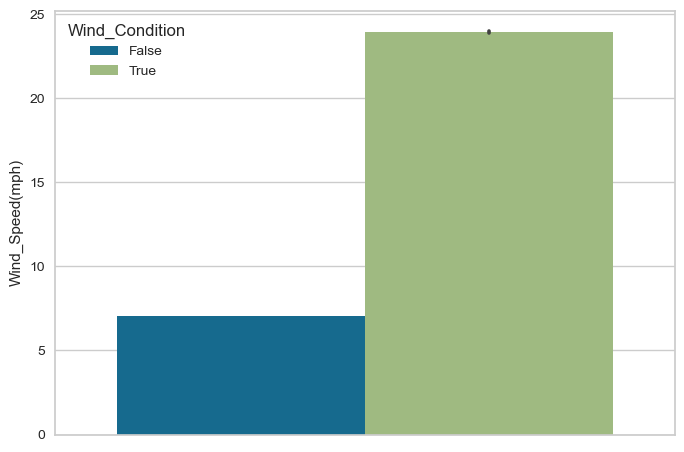

In [20]:
sns.barplot(data=data,hue='Wind_Condition',y='Wind_Speed(mph)')
data.groupby('Wind_Condition')['Wind_Speed(mph)'].describe()

Interesting.  This makes sense and we can no see that there is a very unusual observation value of 822.8mph, especially since it is described as a non-windy day.

__[Per Google](https://www.google.com/search?client=safari&rls=en&q=highest+wind+speed+recorded+in+US&ie=UTF-8&oe=UTF-8)__ the highest wind speed recorded in the US is 231 mph.  So there might be some bad datapoints for observations regardless if they are described as windy.

Nevertheless, I think there is enough evidence that the extra description of 'windy' can be removed (and keeping the indicator).

In [21]:
windy_split = data.Weather_Condition.str.split(r' \/ ')
data['Weather_Condition_New'] = windy_split.apply(lambda l:l[0])

In [22]:
print(f'{data['Weather_Condition_New'].isna().sum()} missing values')
data['Weather_Condition_New'].value_counts(normalize=True).sort_values(ascending=False).head(25)


0 missing values


Weather_Condition_New
Fair                           0.343
Mostly Cloudy                  0.137
Cloudy                         0.110
Clear                          0.107
Partly Cloudy                  0.094
Overcast                       0.051
Light Rain                     0.048
Scattered Clouds               0.027
Light Snow                     0.018
Fog                            0.013
Rain                           0.011
Haze                           0.010
Heavy Rain                     0.004
Light Drizzle                  0.003
T-Storm                        0.002
Thunder in the Vicinity        0.002
Snow                           0.002
Thunder                        0.002
Light Rain with Thunder        0.002
Smoke                          0.002
Wintry Mix                     0.002
Heavy T-Storm                  0.001
Heavy Snow                     0.001
Light Thunderstorms and Rain   0.001
Drizzle                        0.001
Name: proportion, dtype: float64

In [23]:
new_cardinal = len(data['Weather_Condition_New'].unique())
old_cardinal = len(data['Weather_Condition'].unique())
print(f'We have reduced the number of conditions from {old_cardinal} to {new_cardinal}.')


We have reduced the number of conditions from 142 to 95.


Some progress.  But before manually choosing categories and mappings, let's consider using the continous features to create a consolidated but meaningful feature which maybe can improve on the categorical weather feature. 

In [24]:
weather_factors = ['Temperature(F)','Wind_Chill(F)','Humidity(%)',
                   'Pressure(in)','Visibility(mi)',
                   'Wind_Speed(mph)','Precipitation(in)',
                   'Wind_Direction'
                   ]

#### PCA

In [25]:
X = data[weather_factors]
scaler = StandardScaler()
X = pd.get_dummies(X)
X_std =scaler.fit_transform(X)

In [26]:
pca = PCA()
pca.fit(X_std);

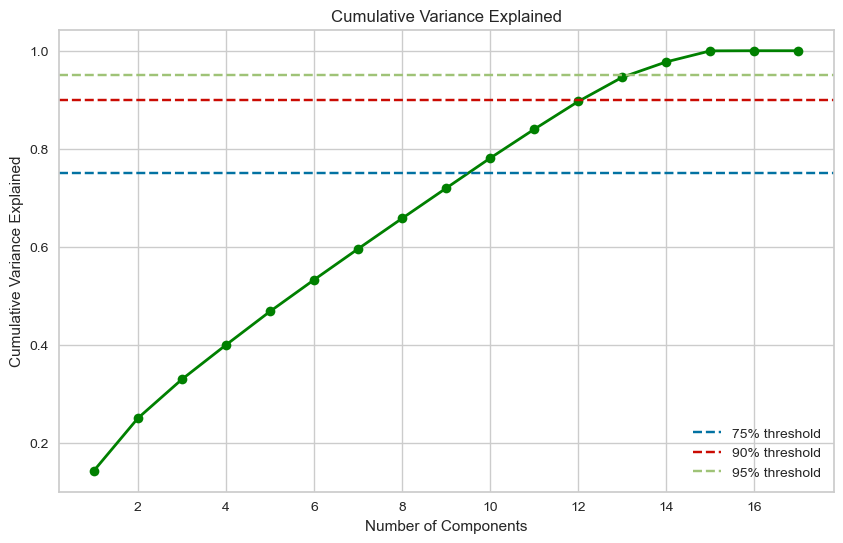

In [27]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
# Create a cumulative variance plot
plt.figure(figsize=(10, 6))
cum_var_plot = plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 
         'o-', linewidth=2, color='green')
# Add lines for 75%, 90% and 95% thresholds
plt.axhline(y=0.75, color='b', linestyle='--', label='75% threshold')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
target_variance = 0.75
n_components_variance = np.argmax(cumulative_var >= target_variance) + 1
print(f'We choose to include the first {n_components_variance} components.')

We choose to include the first 10 components.


In [29]:
pca = PCA(n_components=n_components_variance)
pca.fit(X_std);
# Transform the standardized data to get principal components
X_pca = pca.transform(X_std)
pcs = [f'PC{i+1}' for i in range(X_pca.shape[1])]

In [30]:
# Create an easy to view DF of the loadings.
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pcs,
    index=X.columns
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Temperature(F),0.571,-0.210,-0.151,-0.052,-0.004,-0.089,0.024,0.016,-0.022,0.004
Wind_Chill(F),0.561,-0.245,-0.150,-0.049,-0.005,-0.090,0.021,0.019,-0.026,0.002
Humidity(%),-0.384,-0.114,-0.403,-0.008,-0.123,-0.081,0.023,0.029,-0.058,-0.007
Pressure(in),0.053,-0.144,-0.220,-0.240,0.054,-0.103,-0.123,-0.127,-0.401,-0.218
Visibility(mi),0.297,-0.018,0.376,0.059,0.119,0.150,-0.147,0.050,-0.182,-0.049
Wind_Speed(mph),0.169,0.611,-0.137,-0.012,-0.026,0.014,0.020,0.019,-0.036,-0.007
Precipitation(in),-0.043,0.019,-0.277,-0.098,-0.100,-0.234,0.231,-0.140,0.291,0.058
Wind_Direction_0,-0.218,-0.585,0.199,0.086,-0.051,0.018,-0.062,0.100,-0.082,-0.005
Wind_Direction_E,0.042,0.026,-0.341,-0.528,-0.168,0.418,-0.384,0.084,0.154,0.068
Wind_Direction_N,-0.088,0.196,0.014,-0.145,0.724,-0.371,-0.239,0.092,-0.059,0.010


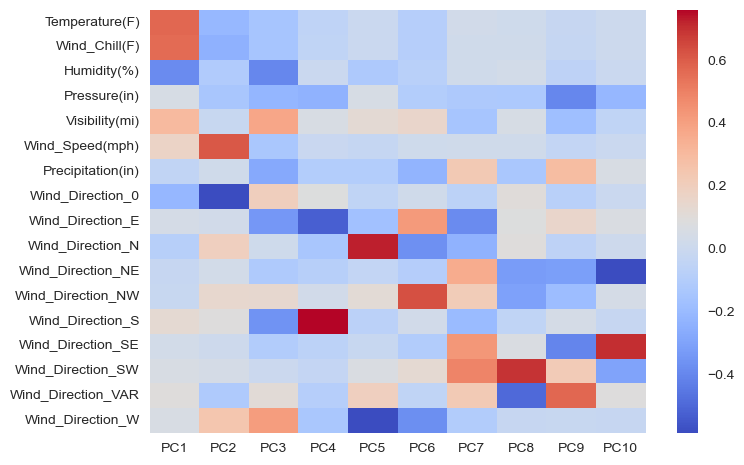

In [31]:
sns.heatmap(loadings,cmap='coolwarm');

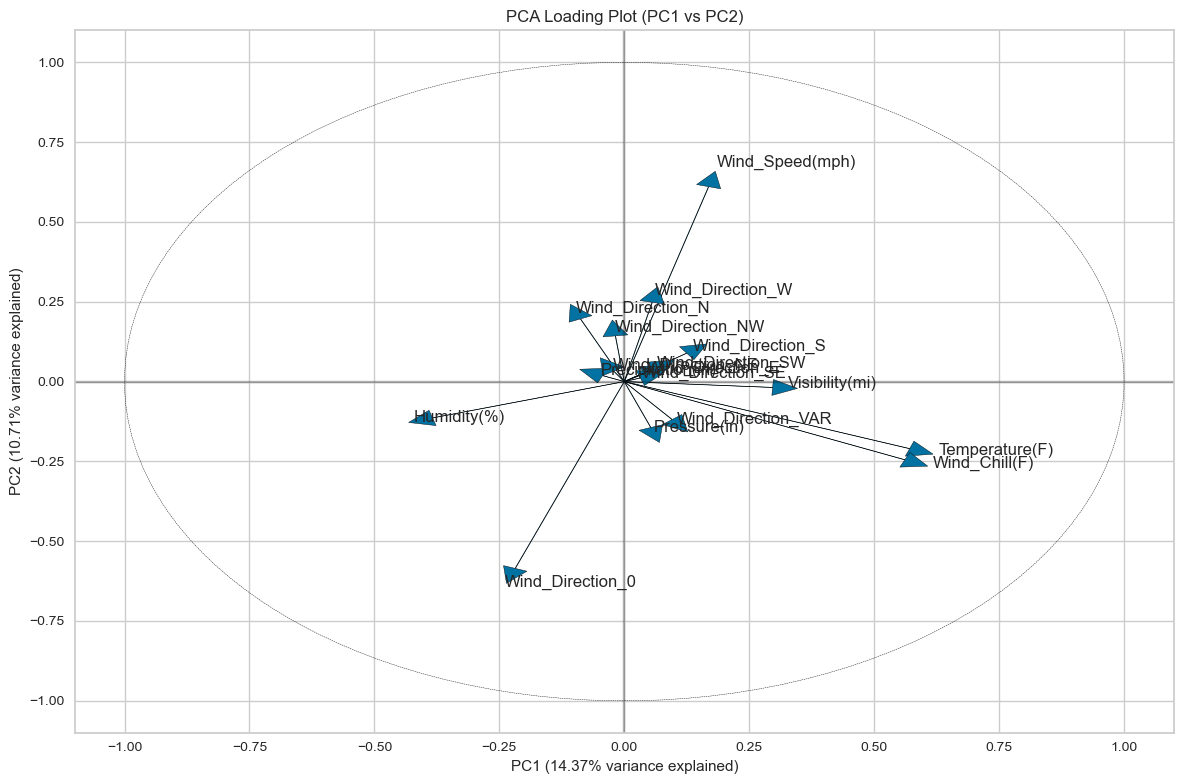

In [32]:
# Visualize the loadings for the first two PCs
plt.figure(figsize=(12, 8))
for i, feature in enumerate(X.columns):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.05, head_length=0.05)
    plt.text(loadings.iloc[i, 0]*1.1, loadings.iloc[i, 1]*1.1, feature, fontsize=12)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, fill=False, linestyle='--')
plt.gca().add_patch(circle)

plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title('PCA Loading Plot (PC1 vs PC2)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
plt.tight_layout()
plt.show()

All pretty expected:
- Temp & Wind Chill are obviously closely related.
- Wind_Direction_C is the exact opposite of there being any wind speed.
- Other Wind directions are of limtied interest.

However, it is surprising that visibility, precipitation and pressure all have minimal impact.

In [33]:
# Create a DataFrame with the principal components
pca_df = pd.DataFrame(
    data=X_pca,
    columns=pcs
)
pca_df['Condition_1'] = data['Weather_Condition'].values
pca_df['Condition_2'] = data['Weather_Condition_New'].values
avg_pca_1 = pca_df.groupby('Condition_1')[pcs].mean()
avg_pca_2 = pca_df.groupby('Condition_2')[pcs].mean()
print(avg_pca_1)
print('--'*50)
print(avg_pca_2)

                           PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9   PC10
Condition_1                                                                                  
Blowing Dust             0.965  1.335  0.468 -0.261  0.282 -0.370  0.170 -0.005  0.318 -0.169
Blowing Dust / Windy     1.296  3.313  0.405  0.146  0.016 -0.237  0.593  0.374  0.712  0.161
Blowing Sand             1.496  0.251  0.012 -0.565 -0.883 -1.029  1.203 -0.994 -0.384 -1.464
Blowing Snow            -3.682  3.162  0.554 -0.077 -0.706 -0.109  0.299 -0.142  0.446 -0.024
Blowing Snow / Windy    -4.110  4.333  0.667  0.102 -0.944  0.495  0.443 -0.318  0.494  0.182
...                        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
Volcanic Ash             1.006 -0.612  0.321 -0.597  2.324 -1.152 -0.779  0.213 -0.382 -0.069
Widespread Dust          1.402  2.122  0.044 -0.155 -0.529 -0.326  0.285  0.008  0.014 -0.306
Widespread Dust / Windy  1.378  3.040  0.376 -0.041 -0.399  

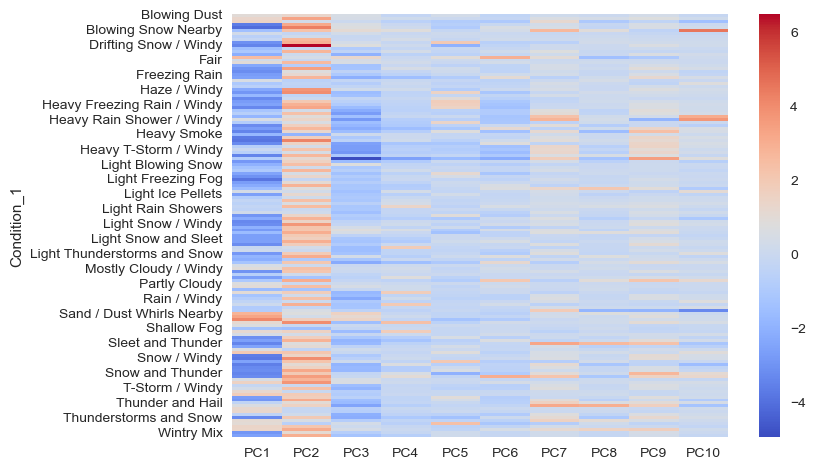

In [34]:
sns.heatmap(avg_pca_1,cmap='coolwarm');

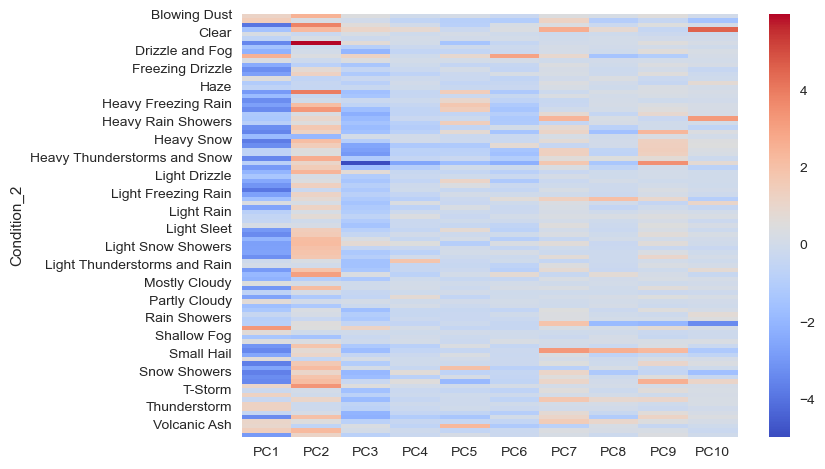

In [35]:
sns.heatmap(avg_pca_2,cmap='coolwarm');

In [36]:
try: 
    del loadings,pca_df,avg_pca_1,avg_pca_2
except:
    pass

#### K-Means Clustering

In [37]:
X = data[weather_factors+['Weather_Condition','Weather_Condition_New']]

In [38]:
X.isna().sum()

Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Speed(mph)          0
Precipitation(in)        0
Wind_Direction           0
Weather_Condition        0
Weather_Condition_New    0
dtype: int64

In [39]:
X = data[weather_factors+['Weather_Condition','Weather_Condition_New']][weather_factors]
scaler = StandardScaler()
X = pd.get_dummies(X)
X_std =scaler.fit_transform(X)

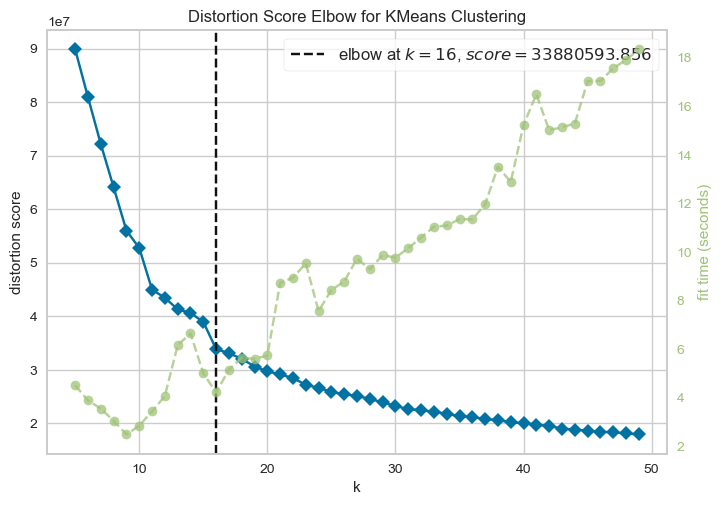

In [ ]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km,k=(5,30))
visualizer.fit(X_std)
visualizer.show();

Recall, the heavily-skewed distribution of weather descripitions.  

In [41]:
km = KMeans(random_state=42,n_clusters=visualizer.elbow_value_)
km.fit(X_std)

KMeans(n_clusters=16, random_state=42)

In [42]:
centroids = pd.DataFrame(scaler.inverse_transform(km.cluster_centers_),columns=X.columns)
centroids

,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Wind_Direction_0,Wind_Direction_E,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W
0,66.091,65.080,62.116,29.546,9.391,8.998,0.004,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,1.000,-0.000,-0.000
1,73.123,73.120,52.620,29.611,9.744,9.300,0.003,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,1.000
2,68.285,68.174,56.085,29.759,9.855,8.580,0.002,0.000,0.000,1.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000
3,77.020,77.018,57.750,29.643,9.927,9.751,0.001,0.000,0.000,0.000,0.000,0.000,1.000,-0.000,-0.000,-0.000,-0.000
4,58.063,58.063,72.780,29.710,8.805,0.000,0.003,1.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000
5,65.209,64.233,68.071,29.768,8.900,8.475,0.009,-0.000,1.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000
6,60.456,58.969,68.779,29.711,8.660,8.407,0.010,-0.000,-0.000,0.000,1.000,0.000,0.000,0.000,-0.000,0.000,0.000
7,69.749,69.423,55.058,29.628,9.438,4.775,0.005,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,1.000,-0.000
8,69.887,69.861,50.869,29.599,9.794,9.511,0.003,-0.000,-0.000,0.000,-0.000,1.000,0.000,0.000,-0.000,0.000,0.000
9,46.495,43.373,55.690,24.879,8.966,7.755,0.003,0.207,0.128,0.189,0.007,0.015,0.219,0.009,0.029,0.020,0.176


In [43]:
cluster_size = pd.Series(km.labels_).value_counts(normalize=True)
cluster_size.sort_values(ascending=False)

4    0.174
5    0.117
1    0.109
3    0.104
2    0.081
11   0.066
14   0.056
12   0.051
7    0.048
0    0.047
10   0.039
6    0.034
8    0.030
9    0.025
13   0.019
15   0.000
Name: proportion, dtype: float64

In [44]:
described_obsv = pd.DataFrame(data[weather_factors+['Weather_Condition','Weather_Condition_New']])
described_obsv['Cluster'] = km.labels_
described_obsv['Severity'] = data['Severity']
described_obsv['Distance(mi)'] = data['Distance(mi)']
described_obsv['Time_of_Impact(hr)'] = data['Time_of_Impact(hr)']
described_obsv

,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Wind_Direction,Weather_Condition,Weather_Condition_New,Cluster,Severity,Distance(mi),Time_of_Impact(hr)
0,36.900,36.900,91.000,29.680,10.000,0.000,0.020,0,Light Rain,Light Rain,4,3,0.010,5.233
1,37.900,37.900,100.000,29.650,10.000,0.000,0.000,0,Light Rain,Light Rain,4,2,0.010,0.500
2,36.000,33.300,100.000,29.670,10.000,3.500,0.000,SW,Overcast,Overcast,0,2,0.010,0.500
3,35.100,31.000,96.000,29.640,9.000,4.600,0.000,SW,Mostly Cloudy,Mostly Cloudy,0,3,0.010,0.500
4,36.000,33.300,89.000,29.650,6.000,3.500,0.000,SW,Mostly Cloudy,Mostly Cloudy,0,2,0.010,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7461584,86.000,86.000,40.000,28.920,10.000,13.000,0.000,W,Fair,Fair,1,2,0.543,0.477
7461585,70.000,70.000,73.000,29.390,10.000,6.000,0.000,SW,Fair,Fair,0,2,0.338,0.448
7461586,73.000,73.000,64.000,29.740,10.000,10.000,0.000,S,Partly Cloudy,Partly Cloudy,3,2,0.561,0.474
7461587,71.000,71.000,81.000,29.620,10.000,8.000,0.000,SW,Fair,Fair,0,2,0.772,0.489


##### Vs. Nature of Accident Variables

In [45]:
cluster_v_accidents = pd.crosstab(described_obsv['Cluster'],described_obsv['Severity'],normalize='index')
cluster_v_accidents['Total Accidents'] = pd.Series(km.labels_).value_counts()

In [46]:
cluster_v_accidents

Severity,1,2,3,4,Total Accidents
Cluster,,,,,
0,0.012,0.784,0.176,0.027,354315
1,0.013,0.786,0.179,0.021,809654
2,0.010,0.805,0.163,0.022,605911
3,0.012,0.784,0.180,0.023,776795
4,0.008,0.811,0.153,0.028,1301026
5,0.008,0.801,0.168,0.023,872197
6,0.008,0.800,0.168,0.024,253196
7,0.009,0.807,0.164,0.020,355404
8,0.012,0.803,0.164,0.022,222270


In [47]:
cluster_avgs = described_obsv.groupby('Cluster')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

In [48]:
cluster_v_accidents = cluster_v_accidents.join(cluster_avgs)
cluster_v_accidents

,1,2,3,4,Total Accidents,Severity,Time_of_Impact(hr),Distance(mi)
Cluster,,,,,,,,
0,0.012,0.784,0.176,0.027,354315,2.219,1.760,0.542
1,0.013,0.786,0.179,0.021,809654,2.208,1.809,0.531
2,0.010,0.805,0.163,0.022,605911,2.196,1.822,0.491
3,0.012,0.784,0.180,0.023,776795,2.215,1.746,0.484
4,0.008,0.811,0.153,0.028,1301026,2.201,1.840,0.529
5,0.008,0.801,0.168,0.023,872197,2.207,1.847,0.513
6,0.008,0.800,0.168,0.024,253196,2.209,1.797,0.532
7,0.009,0.807,0.164,0.020,355404,2.195,1.792,0.520
8,0.012,0.803,0.164,0.022,222270,2.196,1.840,0.531


##### Vs. Description of Weather (2x)

Original Categories

In [49]:
cluster_v_descr = pd.crosstab(described_obsv['Cluster'],described_obsv['Weather_Condition'])
cluster_v_descr['Total'] = cluster_v_descr.sum(axis=1)
cluster_v_descr.loc['Total'] = cluster_v_descr.sum(axis=0)
cluster_v_descr

Weather_Condition,Blowing Dust,Blowing Dust / Windy,Blowing Sand,Blowing Snow,Blowing Snow / Windy,Blowing Snow Nearby,Clear,Cloudy,Cloudy / Windy,Drifting Snow,Drifting Snow / Windy,Drizzle,Drizzle / Windy,Drizzle and Fog,Dust Whirls,Fair,Fair / Windy,Fog,Fog / Windy,Freezing Drizzle,Freezing Rain,Freezing Rain / Windy,Funnel Cloud,Hail,Haze,Haze / Windy,Heavy Blowing Snow,Heavy Drizzle,Heavy Freezing Drizzle,Heavy Freezing Rain,Heavy Freezing Rain / Windy,Heavy Ice Pellets,Heavy Rain,Heavy Rain / Windy,Heavy Rain Shower,Heavy Rain Shower / Windy,Heavy Rain Showers,Heavy Sleet,Heavy Sleet / Windy,Heavy Sleet and Thunder,Heavy Smoke,Heavy Snow,Heavy Snow / Windy,Heavy Snow with Thunder,Heavy T-Storm,Heavy T-Storm / Windy,Heavy Thunderstorms and Rain,Heavy Thunderstorms and Snow,Heavy Thunderstorms with Small Hail,Ice Pellets,Light Blowing Snow,Light Drizzle,Light Drizzle / Windy,Light Fog,Light Freezing Drizzle,Light Freezing Fog,Light Freezing Rain,Light Freezing Rain / Windy,Light Hail,Light Haze,Light Ice Pellets,Light Rain,Light Rain / Windy,Light Rain Shower,Light Rain Shower / Windy,Light Rain Showers,Light Rain with Thunder,Light Sleet,Light Sleet / Windy,Light Snow,Light Snow / Windy,Light Snow Grains,Light Snow Shower,Light Snow Shower / Windy,Light Snow Showers,Light Snow and Sleet,Light Snow and Sleet / Windy,Light Snow with Thunder,Light Thunderstorm,Light Thunderstorms and Rain,Light Thunderstorms and Snow,Low Drifting Snow,Mist,Mist / Windy,Mostly Cloudy,Mostly Cloudy / Windy,N/A Precipitation,Overcast,Partial Fog,Partial Fog / Windy,Partly Cloudy,Partly Cloudy / Windy,Patches of Fog,Patches of Fog / Windy,Rain,Rain / Windy,Rain Shower,Rain Shower / Windy,Rain Showers,Rain and Sleet,Sand / Dust Whirls Nearby,Sand / Dust Whirlwinds,Sand / Dust Whirlwinds / Windy,Sand / Windy,Scattered Clouds,Shallow Fog,Shallow Fog / Windy,Showers in the Vicinity,Sleet,Sleet / Windy,Sleet and Thunder,Small Hail,Smoke,Smoke / Windy,Snow,Snow / Windy,Snow Grains,Snow Showers,Snow and Sleet,Snow and Sleet / Windy,Snow and Thunder,Snow and Thunder / Windy,Squalls,Squalls / Windy,T-Storm,T-Storm / Windy,Thunder,Thunder / Windy,Thunder / Wintry Mix,Thunder / Wintry Mix / Windy,Thunder and Hail,Thunder and Hail / Windy,Thunder in the Vicinity,Thunderstorm,Thunderstorms and Rain,Thunderstorms and Snow,Tornado,Volcanic Ash,Widespread Dust,Widespread Dust / Windy,Wintry Mix,Wintry Mix / Windy,Total
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9,22,0,48,32,0,37777,34912,849,0,0,156,0,1,0,114330,2186,2198,6,0,12,0,2,0,3113,49,0,21,0,0,0,0,1153,46,0,0,0,0,0,0,0,76,85,0,531,100,152,1,0,1,0,716,9,0,17,23,55,0,2,0,1,14309,336,20,2,11,716,0,0,3575,155,0,0,1,0,0,0,0,0,271,0,1,88,0,60385,989,41,16954,0,0,38405,492,120,0,2862,84,1,0,8,0,1,5,0,0,12037,47,0,73,0,0,4,0,321,3,139,36,0,0,31,0,0,0,1,1,848,53,687,21,0,0,4,2,968,227,124,0,7,0,14,1,142,1,354315
1,57,29,1,0,0,0,107483,46627,630,0,0,80,0,0,0,335362,6847,615,1,0,0,0,4,0,10901,73,0,4,0,0,0,0,1683,41,0,0,0,0,0,0,0,0,0,0,1328,235,358,0,1,0,0,507,3,0,0,0,0,0,0,0,0,15162,318,12,0,8,1790,0,0,0,0,0,0,0,0,0,0,0,0,684,0,0,34,0,115734,2077,3,20524,0,0,96690,1948,72,0,2537,31,1,0,8,0,4,26,4,0,29201,45,0,81,0,0,0,0,2443,10,0,0,0,0,0,0,0,0,8,12,2116,116,1727,101,0,0,1,0,2171,669,337,0,5,0,71,3,0,0,809654
2,59,59,0,0,0,0,82212,56736,780,0,0,158,0,0,0,237236,4752,86,1,0,0,0,2,1,2989,56,0,9,0,0,0,0,571,18,0,0,0,0,0,0,0,18,0,0,385,29,83,0,0,0,0,643,7,0,0,0,0,0,0,0,0,16331,271,4,0,15,1416,0,0,0,0,0,0,0,0,0,0,0,0,521,0,0,11,0,83200,880,1,25034,0,0,63393,583,67,0,1835,30,3,0,1,0,1,2,0,0,18577,87,0,64,0,0,0,0,1609,44,5,0,0,0,0,0,0,0,6,11,1290,60,1405,81,0,0,1,0,1473,550,122,0,0,21,14,2,0,0,605911
3,11,9,0,0,0,0,89607,58066,2504,0,0,45,0,0,0,267159,4856,8,0,0,0,0,3,0,3481,60,0,0,0,0,0,0,202,20,0,0,0,0,0,0,0,0,0,0,128,64,46,0,0,0,0,535,10,0,0,0,0,0,0,3,0,14555,726,9,0,12,1553,0,0,0,0,0,0,0,0,0,0,0,1,505,0,0,1,0,

In [50]:
cluster_v_descr_ratio = cluster_v_descr.apply(lambda r: r/r['Total'],axis=1)
cluster_v_descr_ratio

Weather_Condition,Blowing Dust,Blowing Dust / Windy,Blowing Sand,Blowing Snow,Blowing Snow / Windy,Blowing Snow Nearby,Clear,Cloudy,Cloudy / Windy,Drifting Snow,Drifting Snow / Windy,Drizzle,Drizzle / Windy,Drizzle and Fog,Dust Whirls,Fair,Fair / Windy,Fog,Fog / Windy,Freezing Drizzle,Freezing Rain,Freezing Rain / Windy,Funnel Cloud,Hail,Haze,Haze / Windy,Heavy Blowing Snow,Heavy Drizzle,Heavy Freezing Drizzle,Heavy Freezing Rain,Heavy Freezing Rain / Windy,Heavy Ice Pellets,Heavy Rain,Heavy Rain / Windy,Heavy Rain Shower,Heavy Rain Shower / Windy,Heavy Rain Showers,Heavy Sleet,Heavy Sleet / Windy,Heavy Sleet and Thunder,Heavy Smoke,Heavy Snow,Heavy Snow / Windy,Heavy Snow with Thunder,Heavy T-Storm,Heavy T-Storm / Windy,Heavy Thunderstorms and Rain,Heavy Thunderstorms and Snow,Heavy Thunderstorms with Small Hail,Ice Pellets,Light Blowing Snow,Light Drizzle,Light Drizzle / Windy,Light Fog,Light Freezing Drizzle,Light Freezing Fog,Light Freezing Rain,Light Freezing Rain / Windy,Light Hail,Light Haze,Light Ice Pellets,Light Rain,Light Rain / Windy,Light Rain Shower,Light Rain Shower / Windy,Light Rain Showers,Light Rain with Thunder,Light Sleet,Light Sleet / Windy,Light Snow,Light Snow / Windy,Light Snow Grains,Light Snow Shower,Light Snow Shower / Windy,Light Snow Showers,Light Snow and Sleet,Light Snow and Sleet / Windy,Light Snow with Thunder,Light Thunderstorm,Light Thunderstorms and Rain,Light Thunderstorms and Snow,Low Drifting Snow,Mist,Mist / Windy,Mostly Cloudy,Mostly Cloudy / Windy,N/A Precipitation,Overcast,Partial Fog,Partial Fog / Windy,Partly Cloudy,Partly Cloudy / Windy,Patches of Fog,Patches of Fog / Windy,Rain,Rain / Windy,Rain Shower,Rain Shower / Windy,Rain Showers,Rain and Sleet,Sand / Dust Whirls Nearby,Sand / Dust Whirlwinds,Sand / Dust Whirlwinds / Windy,Sand / Windy,Scattered Clouds,Shallow Fog,Shallow Fog / Windy,Showers in the Vicinity,Sleet,Sleet / Windy,Sleet and Thunder,Small Hail,Smoke,Smoke / Windy,Snow,Snow / Windy,Snow Grains,Snow Showers,Snow and Sleet,Snow and Sleet / Windy,Snow and Thunder,Snow and Thunder / Windy,Squalls,Squalls / Windy,T-Storm,T-Storm / Windy,Thunder,Thunder / Windy,Thunder / Wintry Mix,Thunder / Wintry Mix / Windy,Thunder and Hail,Thunder and Hail / Windy,Thunder in the Vicinity,Thunderstorm,Thunderstorms and Rain,Thunderstorms and Snow,Tornado,Volcanic Ash,Widespread Dust,Widespread Dust / Windy,Wintry Mix,Wintry Mix / Windy,Total
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.099,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.323,0.006,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.040,0.001,0.000,0.000,0.000,0.002,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.170,0.003,0.000,0.048,0.000,0.000,0.108,0.001,0.000,0.000,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.003,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.133,0.058,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.414,0.008,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.013,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.019,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.143,0.003,0.000,0.025,0.000,0.000,0.119,0.002,0.000,0

In [51]:
conditions = data['Weather_Condition'].unique().tolist()
full_ratio = cluster_v_descr_ratio.loc['Total']
for cluster in range(0,visualizer.elbow_value_):
    p = cluster_v_descr.loc[cluster][conditions].max()
    i = cluster_v_descr.loc[cluster][conditions].argmax()
    condition = conditions[i]
    msg = f'Cluster {cluster} is mostly described as {condition} ({p}) '
    
    diff = (cluster_v_descr_ratio.loc[cluster] - full_ratio).max()
    i = (cluster_v_descr_ratio.loc[cluster] - full_ratio).argmax()
    condition = conditions[i]
    msg = msg + f'and is most over-represented by {condition} ({diff:.2f})'

    print(msg)

Cluster 0 is mostly described as Fair (114330) and is most over-represented by Light Snow and Sleet (0.04)
Cluster 1 is mostly described as Fair (335362) and is most over-represented by Light Freezing Rain (0.08)
Cluster 2 is mostly described as Fair (237236) and is most over-represented by Light Freezing Rain (0.05)
Cluster 3 is mostly described as Fair (267159) and is most over-represented by Light Snow and Sleet (0.07)
Cluster 4 is mostly described as Fair (556325) and is most over-represented by Light Freezing Rain (0.09)
Cluster 5 is mostly described as Fair (239137) and is most over-represented by Heavy Thunderstorms and Snow (0.03)
Cluster 6 is mostly described as Fair (66916) and is most over-represented by Heavy Thunderstorms and Snow (0.03)
Cluster 7 is mostly described as Fair (136910) and is most over-represented by Light Freezing Rain (0.05)
Cluster 8 is mostly described as Fair (97439) and is most over-represented by Light Freezing Rain (0.10)
Cluster 9 is mostly describe

In [52]:
clusters = cluster_v_accidents.index.tolist()
#full_ratio = cluster_v_descr_ratio.loc['Total']
for condition in conditions:
    p = cluster_v_descr.loc[clusters][condition].max()
    i = cluster_v_descr.loc[clusters][condition].argmax()
    cluster = clusters[i]
    msg = f'{condition} is mostly commonly found in Cluster-{cluster} ({p}).'
    print(msg)

Light Rain is mostly commonly found in Cluster-5 (65508).
Overcast is mostly commonly found in Cluster-4 (55595).
Mostly Cloudy is mostly commonly found in Cluster-3 (158218).
Rain is mostly commonly found in Cluster-5 (17163).
Light Snow is mostly commonly found in Cluster-12 (33484).
Haze is mostly commonly found in Cluster-4 (23335).
Scattered Clouds is mostly commonly found in Cluster-3 (31422).
Partly Cloudy is mostly commonly found in Cluster-3 (100298).
Clear is mostly commonly found in Cluster-4 (179493).
Snow is mostly commonly found in Cluster-12 (4468).
Light Freezing Drizzle is mostly commonly found in Cluster-12 (520).
Light Drizzle is mostly commonly found in Cluster-5 (4224).
Fog is mostly commonly found in Cluster-4 (42985).
Shallow Fog is mostly commonly found in Cluster-4 (1910).
Heavy Rain is mostly commonly found in Cluster-5 (6150).
Light Freezing Rain is mostly commonly found in Cluster-12 (962).
Cloudy is mostly commonly found in Cluster-4 (124357).
Drizzle is mo

Consolidated Categories

In [53]:
cluster_v_descr = pd.crosstab(described_obsv['Cluster'],described_obsv['Weather_Condition_New'])
cluster_v_descr['Total'] = cluster_v_descr.sum(axis=1)
cluster_v_descr.loc['Total'] = cluster_v_descr.sum(axis=0)
cluster_v_descr

Weather_Condition_New,Blowing Dust,Blowing Sand,Blowing Snow,Blowing Snow Nearby,Clear,Cloudy,Drifting Snow,Drizzle,Drizzle and Fog,Dust Whirls,Fair,Fog,Freezing Drizzle,Freezing Rain,Funnel Cloud,Hail,Haze,Heavy Blowing Snow,Heavy Drizzle,Heavy Freezing Drizzle,Heavy Freezing Rain,Heavy Ice Pellets,Heavy Rain,Heavy Rain Shower,Heavy Rain Showers,Heavy Sleet,Heavy Sleet and Thunder,Heavy Smoke,Heavy Snow,Heavy Snow with Thunder,Heavy T-Storm,Heavy Thunderstorms and Rain,Heavy Thunderstorms and Snow,Heavy Thunderstorms with Small Hail,Ice Pellets,Light Blowing Snow,Light Drizzle,Light Fog,Light Freezing Drizzle,Light Freezing Fog,Light Freezing Rain,Light Hail,Light Haze,Light Ice Pellets,Light Rain,Light Rain Shower,Light Rain Showers,Light Rain with Thunder,Light Sleet,Light Snow,Light Snow Grains,Light Snow Shower,Light Snow Showers,Light Snow and Sleet,Light Snow with Thunder,Light Thunderstorm,Light Thunderstorms and Rain,Light Thunderstorms and Snow,Low Drifting Snow,Mist,Mostly Cloudy,N/A Precipitation,Overcast,Partial Fog,Partly Cloudy,Patches of Fog,Rain,Rain Shower,Rain Showers,Rain and Sleet,Sand,Scattered Clouds,Shallow Fog,Showers in the Vicinity,Sleet,Sleet and Thunder,Small Hail,Smoke,Snow,Snow Grains,Snow Showers,Snow and Sleet,Snow and Thunder,Squalls,T-Storm,Thunder,Thunder and Hail,Thunder in the Vicinity,Thunderstorm,Thunderstorms and Rain,Thunderstorms and Snow,Tornado,Volcanic Ash,Widespread Dust,Wintry Mix,Total
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,31,0,80,0,37777,35761,0,156,1,0,116516,2204,0,12,2,0,3162,0,21,0,0,0,1199,0,0,0,0,0,161,0,631,152,1,0,1,0,725,0,17,23,55,2,0,1,14645,22,11,716,0,3730,0,1,0,0,0,0,271,0,1,88,61374,41,16954,0,38897,120,2946,1,8,0,6,12037,47,73,0,4,0,324,175,0,0,31,0,2,901,708,6,968,227,124,0,7,0,15,143,354315
1,86,1,0,0,107483,47257,0,80,0,0,342209,616,0,0,4,0,10974,0,4,0,0,0,1724,0,0,0,0,0,0,0,1563,358,0,1,0,0,510,0,0,0,0,0,0,0,15480,12,8,1790,0,0,0,0,0,0,0,0,684,0,0,34,117811,3,20524,0,98638,72,2568,1,8,0,34,29201,45,81,0,0,0,2453,0,0,0,0,0,20,2232,1828,1,2171,669,337,0,5,0,74,0,809654
2,118,0,0,0,82212,57516,0,158,0,0,241988,87,0,0,2,1,3045,0,9,0,0,0,589,0,0,0,0,0,18,0,414,83,0,0,0,0,650,0,0,0,0,0,0,0,16602,4,15,1416,0,0,0,0,0,0,0,0,521,0,0,11,84080,1,25034,0,63976,67,1865,3,1,0,3,18577,87,64,0,0,0,1653,5,0,0,0,0,17,1350,1486,1,1473,550,122,0,0,21,16,0,605911
3,20,0,0,0,89607,60570,0,45,0,0,272015,8,0,0,3,0,3541,0,0,0,0,0,222,0,0,0,0,0,0,0,192,46,0,0,0,0,545,0,0,0,0,0,3,0,15281,9,12,1553,0,0,0,0,0,0,0,1,505,0,0,1,161471,7,26721,0,101809,34,993,5,1,0,9,31422,17,129,0,0,0,992,0,0,0,0,0,1,1261,3201,1,3511,919,83,0,1,0,28,0,776795
4,0,0,12,0,179493,124357,0,1106,53,0,556325,42985,7,8,5,12,23335,0,124,2,0,0,2889,0,0,0,0,1,197,0,507,97,0,0,2,0,3083,1,74,493,287,0,0,11,38963,10,19,881,17,8883,0,0,0,2,1,0,419,0,0,1628,118402,264,55595,22,90113,2408,9691,9,27,0,0,26439,1910,110,0,0,2,3062,1029,0,0,5,0,1,1741,886,0,1494,281,144,0,0,0,4,1098,1301026
5,28,0,14,0,67772,106045,0,852,146,0,241061,10983,2,87,1,3,6051,0,86,0,0,0,6402,0,1,14,0,0,594,7,1587,335,0,5,35,0,4236,0,169,63,934,1,2,61,66648,36,33,2269,28,13928,0,1,3,105,5,0,823,1,2,314,140660,296,49767,0,90320,260,17529,16,19,0,1,25395,281,301,50,0,1,769,2388,0,0,119,2,3,2699,2893,1,3393,806,326,1,0,0,16,2112,872197
6,45,1,14,0,21590,35870,0,361,29,0,67496,3315,5,30,0,0,1485,0,25,0,0,0,2287,0,0,12,0,0,336,0,539,120,0,0,25,0,1887,0,89,15,308,0,0,47,20659,8,8,606,28,6969,0,7,3,25,6,0,183,1,0,65,34365,203,16785,0,20875,45,5471,2,0,2,0,6298,61,31,23,0,15,213,991,0,1,76,0,2,631,563,0,533,141,80,0,0,0,15,1275,253196
7,0,0,0,0,47804,28526,0,9,3,0,136910,2291,0,7,0,0,4660,0,0,0,0,0,1469,0,0,0,1,0,73,0,576,114,0,0,0,0,404,0,11,8,81,0,0,10,11388,3,10,454,3,1405,0,0,0,1,0,0,177,0,0,76,48004,44,15037,0,37996,56,2584,4,9,0,7,11584,9,57,0,0,0,745,249,0,0,1,0,0,620,602,0,706,202,83,0,2,0,0,329,355404
8,14,0,0,0,28869,14020,0,46,0,1,100205,258,0,0,0,0,1769,0,8,0,0,0,548,0,0,0,0,0,0,0

In [54]:
cluster_v_descr_ratio = cluster_v_descr.apply(lambda r: r/r['Total'],axis=1)
cluster_v_descr_ratio

Weather_Condition_New,Blowing Dust,Blowing Sand,Blowing Snow,Blowing Snow Nearby,Clear,Cloudy,Drifting Snow,Drizzle,Drizzle and Fog,Dust Whirls,Fair,Fog,Freezing Drizzle,Freezing Rain,Funnel Cloud,Hail,Haze,Heavy Blowing Snow,Heavy Drizzle,Heavy Freezing Drizzle,Heavy Freezing Rain,Heavy Ice Pellets,Heavy Rain,Heavy Rain Shower,Heavy Rain Showers,Heavy Sleet,Heavy Sleet and Thunder,Heavy Smoke,Heavy Snow,Heavy Snow with Thunder,Heavy T-Storm,Heavy Thunderstorms and Rain,Heavy Thunderstorms and Snow,Heavy Thunderstorms with Small Hail,Ice Pellets,Light Blowing Snow,Light Drizzle,Light Fog,Light Freezing Drizzle,Light Freezing Fog,Light Freezing Rain,Light Hail,Light Haze,Light Ice Pellets,Light Rain,Light Rain Shower,Light Rain Showers,Light Rain with Thunder,Light Sleet,Light Snow,Light Snow Grains,Light Snow Shower,Light Snow Showers,Light Snow and Sleet,Light Snow with Thunder,Light Thunderstorm,Light Thunderstorms and Rain,Light Thunderstorms and Snow,Low Drifting Snow,Mist,Mostly Cloudy,N/A Precipitation,Overcast,Partial Fog,Partly Cloudy,Patches of Fog,Rain,Rain Shower,Rain Showers,Rain and Sleet,Sand,Scattered Clouds,Shallow Fog,Showers in the Vicinity,Sleet,Sleet and Thunder,Small Hail,Smoke,Snow,Snow Grains,Snow Showers,Snow and Sleet,Snow and Thunder,Squalls,T-Storm,Thunder,Thunder and Hail,Thunder in the Vicinity,Thunderstorm,Thunderstorms and Rain,Thunderstorms and Snow,Tornado,Volcanic Ash,Widespread Dust,Wintry Mix,Total
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000,0.000,0.000,0.000,0.107,0.101,0.000,0.000,0.000,0.000,0.329,0.006,0.000,0.000,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.041,0.000,0.000,0.002,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.173,0.000,0.048,0.000,0.110,0.000,0.008,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.002,0.000,0.003,0.001,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,0.000,0.000,0.000,0.000,0.133,0.058,0.000,0.000,0.000,0.000,0.423,0.001,0.000,0.000,0.000,0.000,0.014,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.019,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.146,0.000,0.025,0.000,0.122,0.000,0.003,0.000,0.000,0.000,0.000,0.036,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.002,0.000,0.003,0.001,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,0.000,0.000,0.000,0.000,0.136,0.095,0.000,0.000,0.000,0.000,0.399,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.027,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.139,0.000,0.041,0.000,0.106,0.000,0.003,0.000,0.000,0.000,0.000,0.031,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.002,0.000,0.002,0.001,0.000,0.000,0.000,0.000,0.000,0.000,1.000
3,0.000,0.000,0.000,0.000,0.115,0.078,0.000,0.000,0.000,0.000,0.350,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.020,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.208,0.000,0.034,0.000,0.131,0.000,0.001,0.000,0.000,0.000,0.000,0.040,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.004,0.000,0.005,0.001,0.000,0.000,0.000,0.000,0.000,0.000,1.000
4,0.000,0.000,0.000,0.000,0.138,0.096,0.000,0.001,0.000,0.000,0.428,0.033,0.000,0.000,0.000,0.000,0.018,0.000,0.000,0.000,0.00

In [55]:
conditions = data['Weather_Condition_New'].unique().tolist()
full_ratio = cluster_v_descr_ratio.loc['Total']
for cluster in range(0,visualizer.elbow_value_):
    p = cluster_v_descr.loc[cluster][conditions].max()
    i = cluster_v_descr.loc[cluster][conditions].argmax()
    condition = conditions[i]
    msg = f'Cluster {cluster} is mostly described as {condition} ({p}) '
    
    diff = (cluster_v_descr_ratio.loc[cluster] - full_ratio).max()
    i = (cluster_v_descr_ratio.loc[cluster] - full_ratio).argmax()
    condition = conditions[i]
    msg = msg + f'and is most over-represented by {condition} ({diff:.2f})'

    print(msg)

Cluster 0 is mostly described as Fair (116516) and is most over-represented by Drizzle and Fog (0.04)
Cluster 1 is mostly described as Fair (342209) and is most over-represented by Light Freezing Drizzle (0.08)
Cluster 2 is mostly described as Fair (241988) and is most over-represented by Light Freezing Drizzle (0.06)
Cluster 3 is mostly described as Fair (272015) and is most over-represented by Drizzle and Fog (0.07)
Cluster 4 is mostly described as Fair (556325) and is most over-represented by Light Freezing Drizzle (0.08)
Cluster 5 is mostly described as Fair (241061) and is most over-represented by Blowing Snow (0.03)
Cluster 6 is mostly described as Fair (67496) and is most over-represented by Blowing Snow (0.03)
Cluster 7 is mostly described as Fair (136910) and is most over-represented by Light Freezing Drizzle (0.04)
Cluster 8 is mostly described as Fair (100205) and is most over-represented by Light Freezing Drizzle (0.11)
Cluster 9 is mostly described as Fair (80616) and is m

In [56]:
clusters = cluster_v_accidents.index.tolist()
for condition in conditions:
    p = cluster_v_descr.loc[clusters][condition].max()
    i = cluster_v_descr.loc[clusters][condition].argmax()
    cluster = clusters[i]
    msg = f'{condition} is mostly commonly found in Cluster-{cluster} ({p}).'
    print(msg)

Light Rain is mostly commonly found in Cluster-5 (66648).
Overcast is mostly commonly found in Cluster-4 (55595).
Mostly Cloudy is mostly commonly found in Cluster-3 (161471).
Rain is mostly commonly found in Cluster-5 (17529).
Light Snow is mostly commonly found in Cluster-12 (34878).
Haze is mostly commonly found in Cluster-4 (23335).
Scattered Clouds is mostly commonly found in Cluster-3 (31422).
Partly Cloudy is mostly commonly found in Cluster-3 (101809).
Clear is mostly commonly found in Cluster-4 (179493).
Snow is mostly commonly found in Cluster-12 (4862).
Light Freezing Drizzle is mostly commonly found in Cluster-12 (520).
Light Drizzle is mostly commonly found in Cluster-5 (4236).
Fog is mostly commonly found in Cluster-4 (42985).
Shallow Fog is mostly commonly found in Cluster-4 (1910).
Heavy Rain is mostly commonly found in Cluster-5 (6402).
Light Freezing Rain is mostly commonly found in Cluster-12 (983).
Cloudy is mostly commonly found in Cluster-4 (124357).
Drizzle is mo

#### Decision

https://www.weather.gov/ajk/ForecastTerms

https://www.weather.gov/otx/full_weather_glossary

As far as I can tell with this simple attempt at clustering, I 

## Summary of Any Changes

In [57]:
if _SPARK_:
    N_New = data.count()
    D_New = len(data.columns)
else:
    N_New = data.shape[1]
    D_New = data.shape[0]

In [58]:
msg = f'We now have {N_New} entries and {D_New} features.'
print(msg)

We now have 62 entries and 7461589 features.


## Final Saveout

In [59]:
if _LITE_SWITCH_:
    data.to_csv('AccidentData_Sampled_Clean_2.csv')
else:
    data.to_csv('AccidentData_Clean_2.csv')

In [60]:
del data
if _SPARK_:
    spark.stop()
else:
    pass

# 5-Create New Datasets

# 6-Statistical Analyses

Description of the three primary tests that are going to be run for all of these categorical features...

In [61]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean_2.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean_2.csv')
    else:
        data = pd.read_csv('AccidentData_Clean_2.csv')
    

## Nature-of-Accident Features vs. Each Other

In [62]:
model_distVseverity = ols("Q('Distance(mi)') ~ C(Severity)", data=data).fit()
anova_table_distVSeverity = sm.stats.anova_lm(model_distVseverity, typ=2)
print("\nANOVA for Distance vs Severity Category:\n", anova_table_distVSeverity)
p_val = anova_table_distVSeverity['PR(>F)'].iloc[0]
print(f"P-value for Distance vs Severity Category: {p_val}")


ANOVA for Distance vs Severity Category:
                   sum_sq          df         F  PR(>F)
C(Severity)   203990.420       3.000 24294.558   0.000
Residual    20883851.950 7461585.000       NaN     NaN
P-value for Distance vs Severity Category: 0.0


COMMENT?

In [63]:
model_timeVseverity = ols("Q('Time_of_Impact(hr)') ~ C(Severity)", data=data).fit()
anova_table_timeVseverity = sm.stats.anova_lm(model_timeVseverity, typ=2)
print("\nANOVA for Time of Impact vs Severity Category:\n", anova_table_timeVseverity)
p_val = anova_table_timeVseverity['PR(>F)'].iloc[0]
print(f"P-value for Time of Impact vs Severity Category: {p_val}")


ANOVA for Time of Impact vs Severity Category:
                   sum_sq          df         F  PR(>F)
C(Severity)  1076957.953       3.000 84225.303   0.000
Residual    31802847.276 7461585.000       NaN     NaN
P-value for Time of Impact vs Severity Category: 0.0


COMMENT? 

In [64]:
X = data[['Distance(mi)','Time_of_Impact(hr)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = data['Severity']

In [65]:
LR_model = LogisticRegression(random_state=42)
LR_model.fit(X_scaled,Y)
pd.DataFrame(LR_model.coef_,index=['Class 1','Class 2','Class 3','Class 4'],columns=['Distance(mi)','Time_of_Impact(hr)'])

,Distance(mi),Time_of_Impact(hr)
Class 1,-1.078,-1.863
Class 2,0.309,0.815
Class 3,0.290,-0.045
Class 4,0.479,1.093


COMMENT?

In [66]:
del X, X_scaled, Y, LR_model
del model_distVseverity, model_timeVseverity
del anova_table_distVSeverity, anova_table_timeVseverity
del p_val

## Weather-Related


In [71]:
_WEATHER_ 

['Weather_Condition',
 'Temperature(F)',
 'Wind_Direction',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)']

### Weather Metrics

In [72]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean_2.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean_2.csv')
        tgt = _WEATHER_.copy()
        tgt.remove('Wind_Direction')
        tgt.remove('Weather_Condition')
    else:
        tgt = _WEATHER_.copy()
        tgt.remove('Wind_Direction')
        tgt.remove('Weather_Condition')
        data = pd.read_csv('AccidentData_Clean_2.csv',usecols = tgt+['Severity','Distance(mi)','Time_of_Impact(hr)'])
    

In [73]:
X = data[tgt]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = data['Severity']

In [74]:
LR_model = LogisticRegression(random_state=42)
LR_model.fit(X_scaled,Y)
pd.DataFrame(LR_model.coef_,index=['Class 1','Class 2','Class 3','Class 4'],columns=X.columns).T

,Class 1,Class 2,Class 3,Class 4
Temperature(F),0.320,-0.341,0.138,-0.117
Wind_Chill(F),0.374,0.148,-0.306,-0.215
Humidity(%),0.171,-0.105,-0.068,0.002
Pressure(in),-0.291,0.046,0.274,-0.030
Visibility(mi),0.035,-0.032,-0.026,0.022
Wind_Speed(mph),-0.045,0.009,0.056,-0.019
Precipitation(in),-0.026,0.008,0.036,-0.017


In [75]:
del X,X_scaled,Y
del scaler, LR_model

In [76]:
X = data[tgt]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = data['Time_of_Impact(hr)']

In [77]:
LR_model = LinearRegression()
LR_model.fit(X_scaled,Y)
pd.DataFrame(LR_model.coef_,index=X.columns)

,0
Temperature(F),-0.359
Wind_Chill(F),0.320
Humidity(%),-0.029
Pressure(in),-0.008
Visibility(mi),0.007
Wind_Speed(mph),0.028
Precipitation(in),-0.006


In [78]:
del X,X_scaled,Y
del scaler, LR_model

In [79]:
X = data[tgt]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = data['Distance(mi)']

In [80]:
LR_model = LinearRegression()
LR_model.fit(X_scaled,Y)
pd.DataFrame(LR_model.coef_,index=X.columns)

,0
Temperature(F),0.474
Wind_Chill(F),-0.546
Humidity(%),0.003
Pressure(in),-0.147
Visibility(mi),-0.043
Wind_Speed(mph),0.001
Precipitation(in),0.001


In [81]:
del X,X_scaled,Y
del scaler, LR_model

### Weather States

In [85]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean_2.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean_2.csv')
    else:
        data = pd.read_csv('AccidentData_Clean_2.csv',usecols = ['Weather_Condition_New','Weather_Condition','Severity','Distance(mi)','Time_of_Impact(hr)'])
    

In [86]:
conditions = data['Weather_Condition'].unique()

for condition in conditions:
    print(condition + ':')
    data['inState'] = data['Weather_Condition'] == condition
    test_results('inState',data,visuals=False)
    print('-'*75)

Light Rain:
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different inStates.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different inStates.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different inStates.
---------------------------------------------------------------------------
Overcast:
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different inStates.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different inStates.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is 

In [87]:
data.groupby('Weather_Condition')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

,Severity,Time_of_Impact(hr),Distance(mi)
Weather_Condition,,,
Blowing Dust,2.086,2.454,0.532
Blowing Dust / Windy,2.102,2.638,0.513
Blowing Sand,2.500,1.573,1.224
Blowing Snow,2.288,1.845,1.761
Blowing Snow / Windy,2.069,2.367,3.147
...,...,...,...
Volcanic Ash,2.095,1.568,0.046
Widespread Dust,2.194,1.819,0.292
Widespread Dust / Windy,2.083,1.580,0.929


In [88]:
conditions = data['Weather_Condition_New'].unique()

for condition in conditions:
    print(condition + ':')
    data['inState'] = data['Weather_Condition_New'] == condition
    test_results('inState',data,visuals=False)
    print('-'*75)

Light Rain:
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different inStates.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different inStates.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different inStates.
---------------------------------------------------------------------------
Overcast:
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different inStates.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different inStates.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is 

In [89]:
data.groupby('Weather_Condition_New')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

,Severity,Time_of_Impact(hr),Distance(mi)
Weather_Condition_New,,,
Blowing Dust,2.095,2.562,0.521
Blowing Sand,2.500,1.573,1.224
Blowing Snow,2.166,2.136,2.533
Blowing Snow Nearby,2.000,2.057,0.201
Clear,2.368,1.593,0.269
...,...,...,...
Thunderstorms and Snow,2.333,2.100,0.000
Tornado,2.056,3.365,0.759
Volcanic Ash,2.095,1.568,0.046


## Calendar-Related

In [90]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean_2.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean_2.csv')
    else:
        tgt_cols = ['Month','Quarter','Year','DayofWeek','Weekend','Holiday']
        data = pd.read_csv('AccidentData_Clean_2.csv',usecols = tgt_cols+['Severity','Distance(mi)','Time_of_Impact(hr)'])
    

### YoY Difference?

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Years.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Years.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Years.


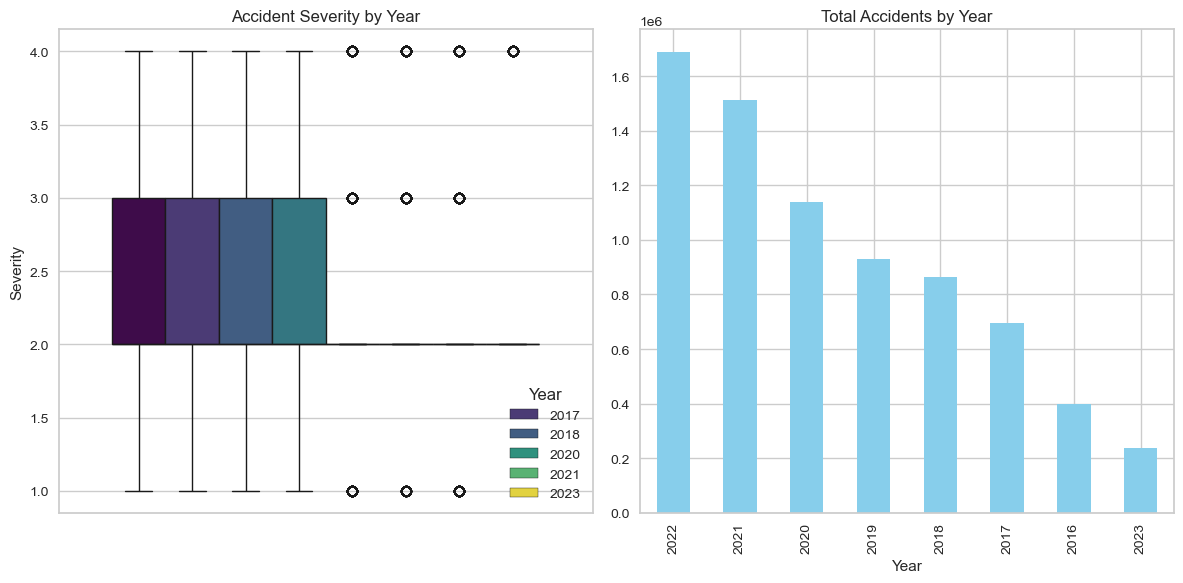

,Severity,Time_of_Impact(hr),Distance(mi)
Year,,,
2016,2.375,2.371,0.248
2017,2.387,1.901,0.276
2018,2.382,1.156,0.286
2019,2.307,1.235,0.293
2020,2.186,1.995,0.441
2021,2.133,2.185,0.694
2022,2.069,1.804,0.919
2023,2.055,1.965,0.912


In [91]:
reports,stats = test_results('Year',data)
data.groupby('Year')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

### Quarterly Difference?

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Quarters.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Quarters.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Quarters.


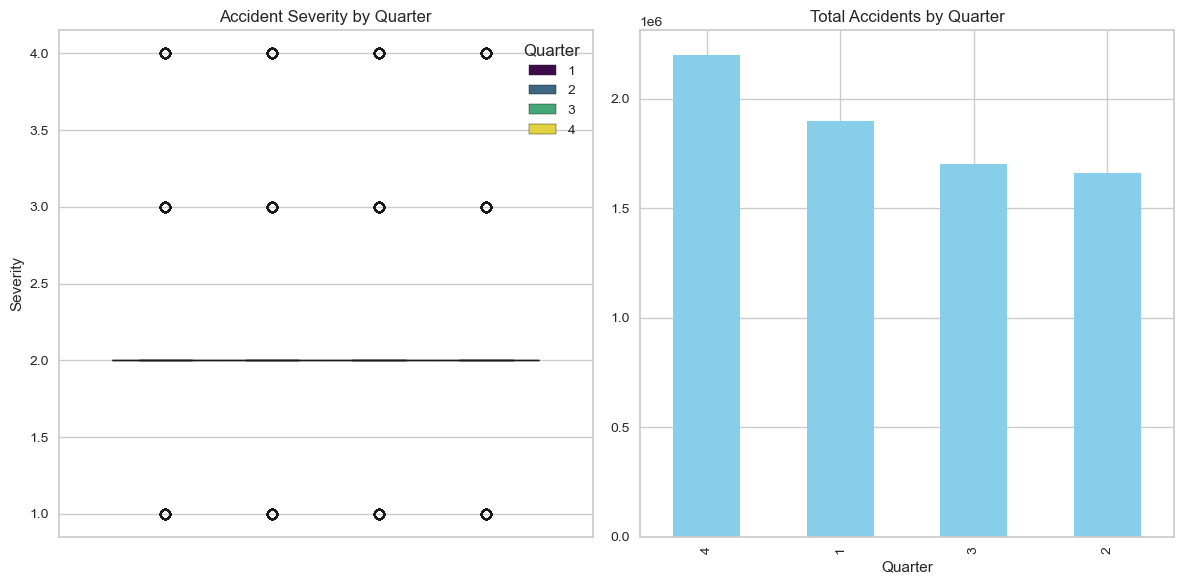

,Severity,Time_of_Impact(hr),Distance(mi)
Quarter,,,
1,2.206,1.879,0.566
2,2.224,1.805,0.531
3,2.229,1.663,0.531
4,2.193,1.863,0.576


In [92]:
reports,stats = test_results('Quarter',data)
data.groupby('Quarter')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

### Monthly ?

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Months.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Months.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Months.


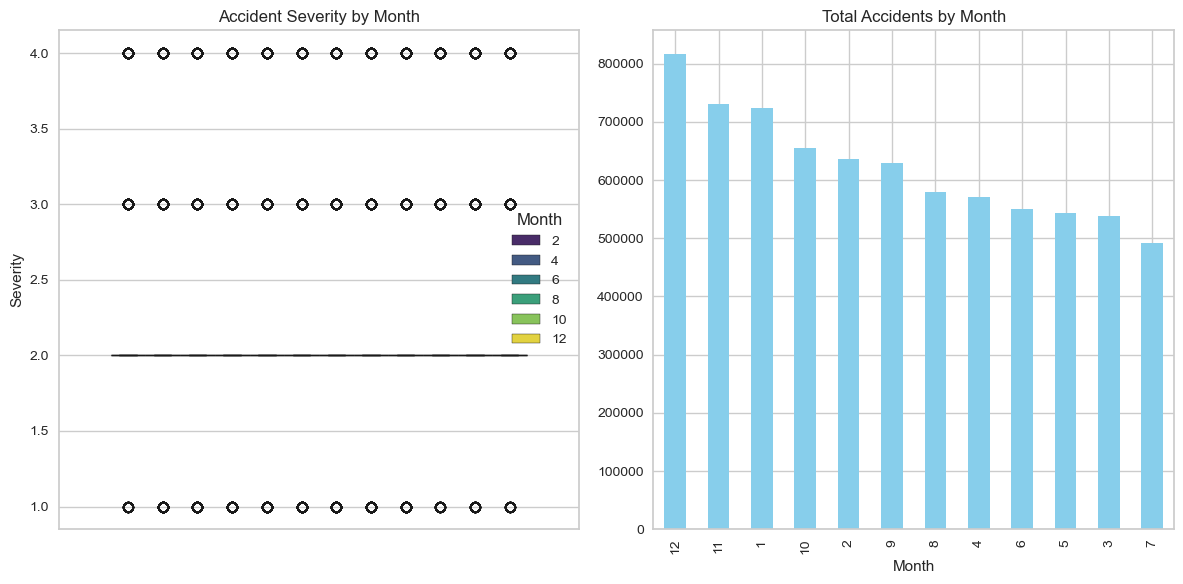

,Severity,Time_of_Impact(hr),Distance(mi)
Month,,,
1,2.191,1.851,0.563
2,2.203,1.942,0.605
3,2.231,1.841,0.525
4,2.215,1.855,0.535
5,2.219,1.871,0.510
6,2.237,1.689,0.547
7,2.243,1.735,0.560
8,2.234,1.595,0.515
9,2.214,1.669,0.523


In [93]:
reports,stats = test_results('Month',data)
data.groupby('Month')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

### Day of Week?

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different DayofWeeks.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different DayofWeeks.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different DayofWeeks.


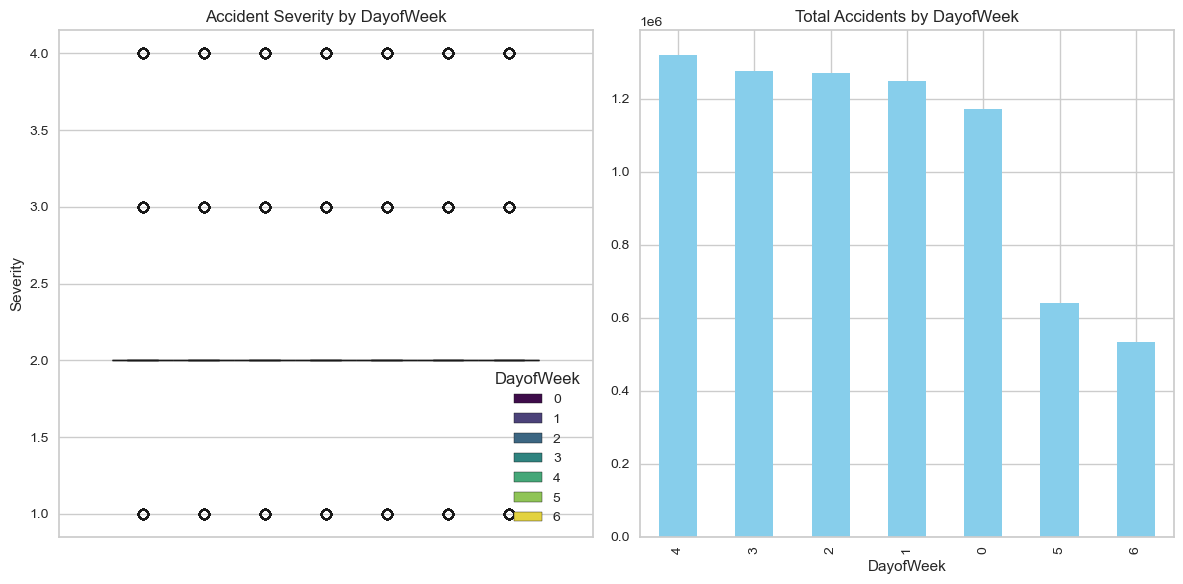

,Severity,Time_of_Impact(hr),Distance(mi)
DayofWeek,,,
0,2.208,1.754,0.508
1,2.204,1.771,0.524
2,2.202,1.778,0.532
3,2.203,1.790,0.549
4,2.205,1.847,0.566
5,2.240,1.941,0.623
6,2.260,1.878,0.666


In [94]:
reports,stats = test_results('DayofWeek',data)
data.groupby('DayofWeek')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

### Weekends?

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Weekends.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Weekends.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Weekends.


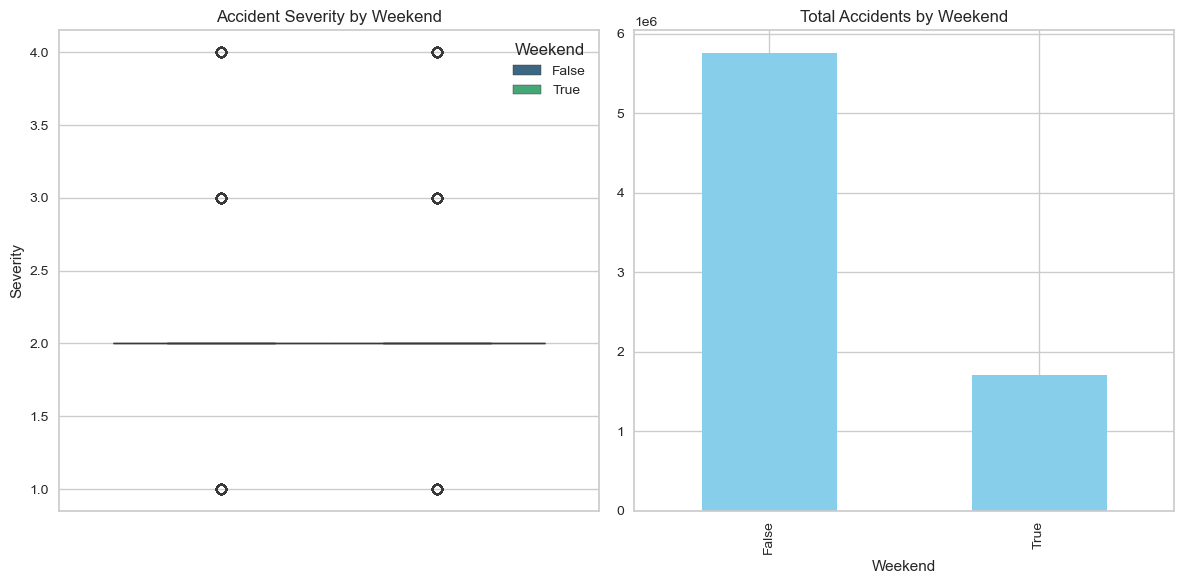

,Severity,Time_of_Impact(hr),Distance(mi)
Weekend,,,
False,2.208,1.813,0.552
True,2.224,1.793,0.558


In [95]:
reports,stats = test_results('Weekend',data)
data.groupby('Weekend')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

### Holidays?

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Holidays.
Based on the ANOVA test's p-value of 0.173, we fail to reject the null hypothesis that there is no significant difference in incident distance across different Holidays.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Holidays.


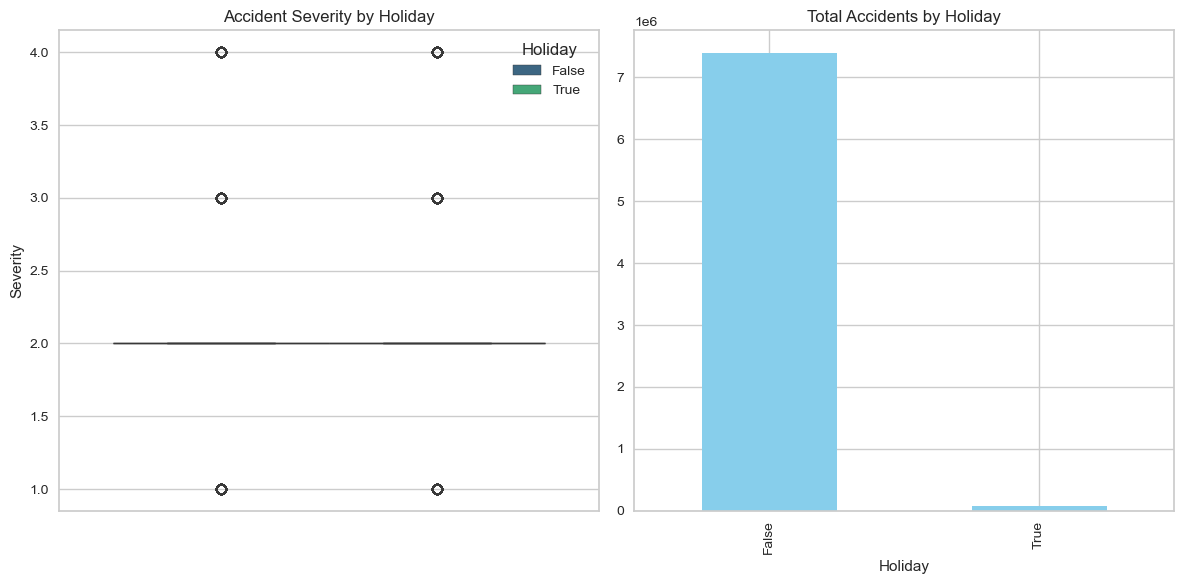

,Severity,Time_of_Impact(hr),Distance(mi)
Holiday,,,
False,2.211,1.810,0.553
True,2.216,1.701,0.562


In [96]:
reports,stats = test_results('Holiday',data)
data.groupby('Holiday')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

## Time of Day?

In [97]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean.csv')
    else:
        tgt_cols = ['Hour','Morning_Rush','Evening_Rush','Rush_Hour','Sunrise_Sunset']
        data = pd.read_csv('AccidentData_Clean.csv',usecols = tgt_cols+['Severity','Distance(mi)','Time_of_Impact(hr)'])
    

### Hourly?

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Hours.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Hours.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Hours.


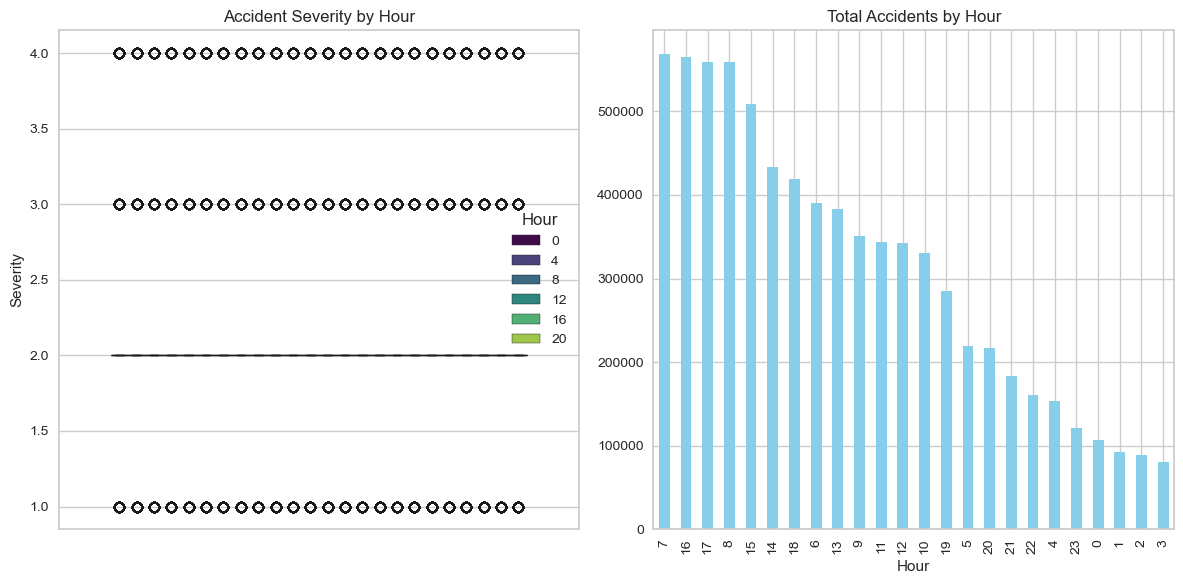

,Severity,Time_of_Impact(hr),Distance(mi)
Hour,,,
0,2.219,2.376,0.651
1,2.190,2.223,0.627
2,2.206,2.269,0.609
3,2.230,2.571,0.686
4,2.233,2.200,0.569
5,2.219,2.438,0.669
6,2.209,1.884,0.627
7,2.189,1.484,0.477
8,2.190,1.430,0.372


In [98]:
reports,stats = test_results('Hour',data)
data.groupby('Hour')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Comments

### Rush Hours?


Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Evening_Rushs.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Evening_Rushs.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Evening_Rushs.


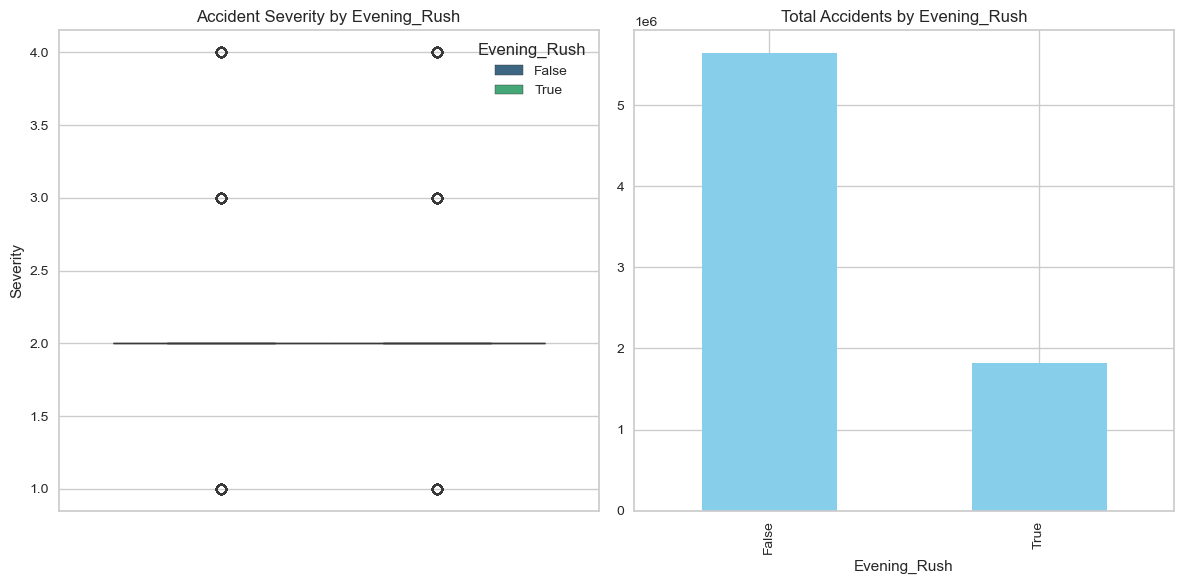

,Severity,Time_of_Impact(hr),Distance(mi)
Evening_Rush,,,
False,2.212,1.857,0.565
True,2.210,1.659,0.516


In [99]:
reports,stats = test_results('Evening_Rush',data)
data.groupby('Evening_Rush')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Morning_Rushs.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Morning_Rushs.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Morning_Rushs.


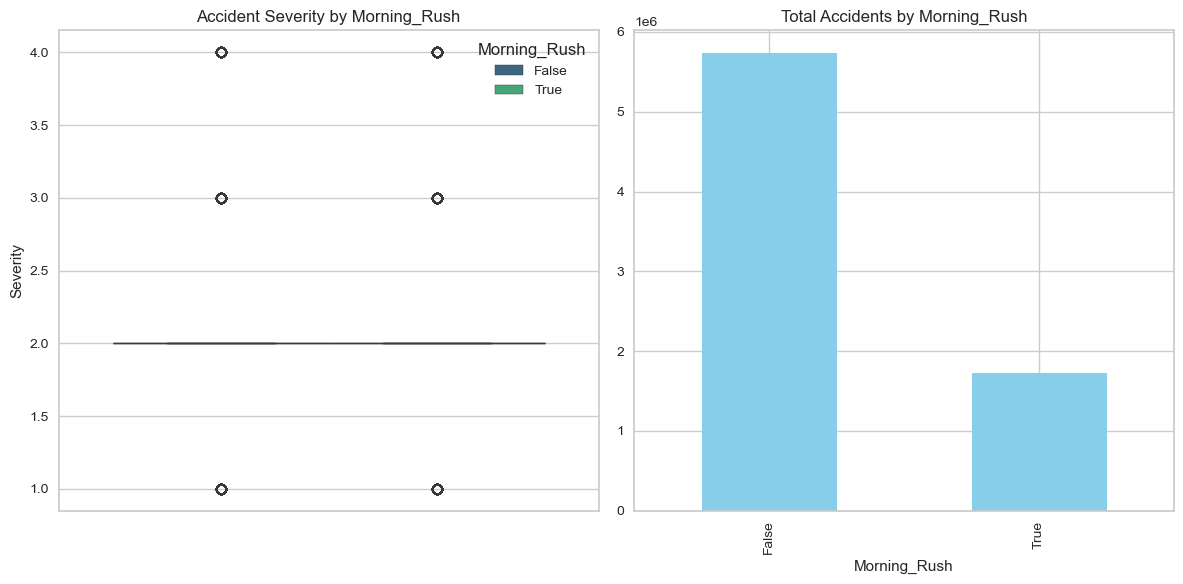

,Severity,Time_of_Impact(hr),Distance(mi)
Morning_Rush,,,
False,2.215,1.874,0.573
True,2.199,1.593,0.489


In [100]:
reports,stats = test_results('Morning_Rush',data)
data.groupby('Morning_Rush')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Rush_Hours.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Rush_Hours.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Rush_Hours.


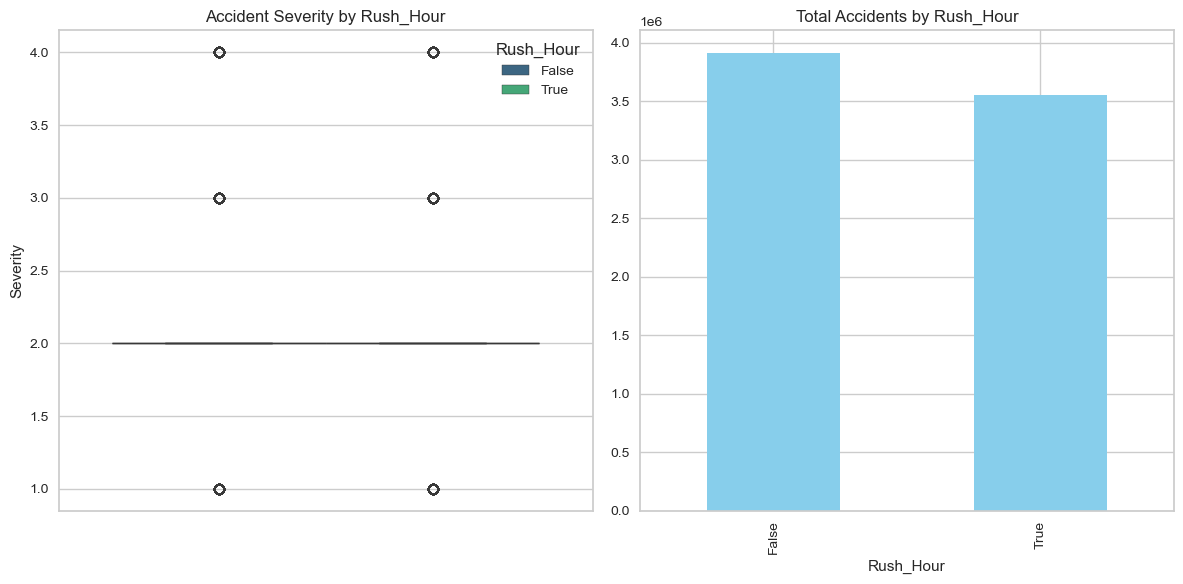

,Severity,Time_of_Impact(hr),Distance(mi)
Rush_Hour,,,
False,2.218,1.974,0.599
True,2.205,1.627,0.503


In [101]:
reports,stats = test_results('Rush_Hour',data)
data.groupby('Rush_Hour')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

### Day/Night?

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Sunrise_Sunsets.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Sunrise_Sunsets.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Sunrise_Sunsets.


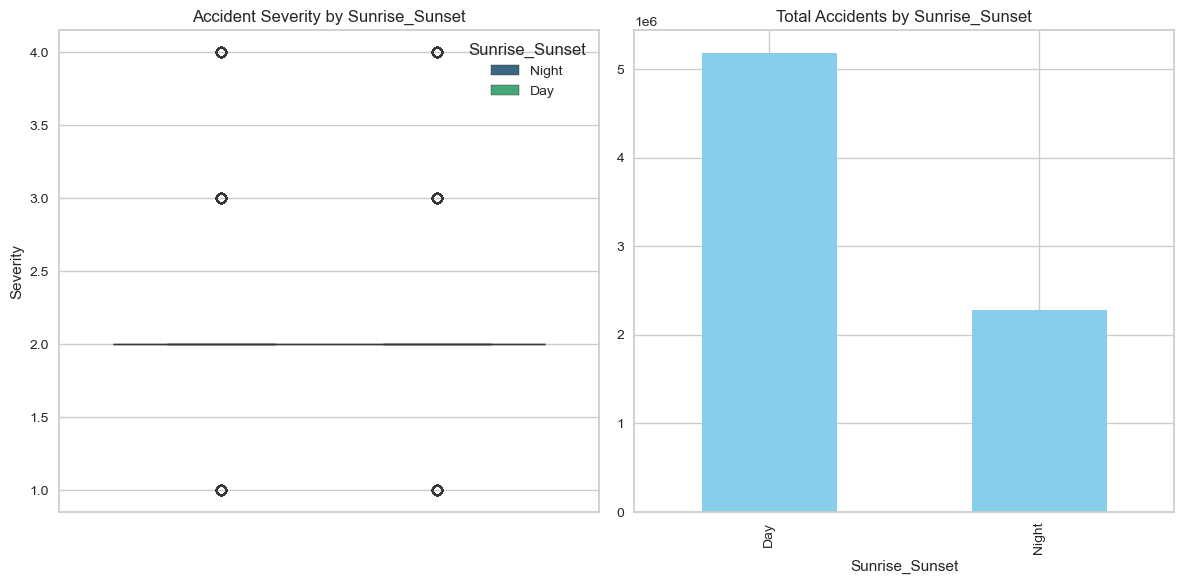

,Severity,Time_of_Impact(hr),Distance(mi)
Sunrise_Sunset,,,
Day,2.208,1.741,0.538
Night,2.219,1.961,0.587


In [102]:
reports,stats = test_results('Sunrise_Sunset',data)
data.groupby('Sunrise_Sunset')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

## Location-Related

In [103]:
if _LITE_SWITCH_:
    pass
elif _SPARK_:
    pass
else:
    try:
        del data
        del reports, stats
    except:
        pass
    

In [104]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean.csv')
    else:
        tgt_cols = ['State','Federal','Region','SubRegion','AA_Region','BEA_Region']
        data = pd.read_csv('AccidentData_Clean.csv',usecols = tgt_cols + ['Severity','Distance(mi)','Time_of_Impact(hr)'])
    

### By Different Region Classifications

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Regions.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Regions.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Regions.


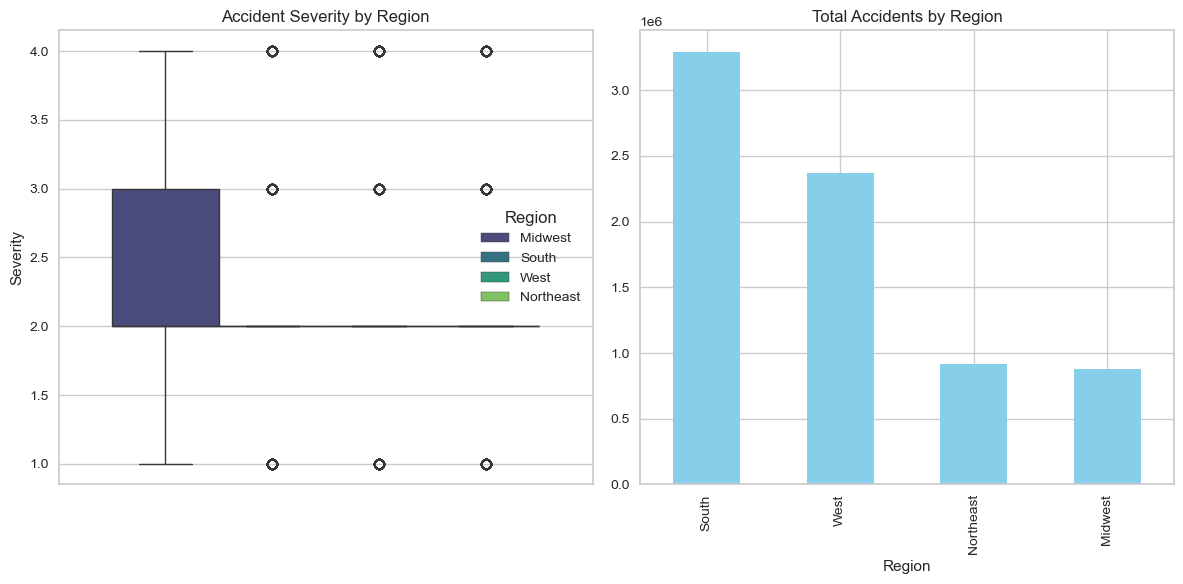

,Severity,Time_of_Impact(hr),Distance(mi)
Region,,,
Midwest,2.321,1.652,0.631
Northeast,2.251,1.827,0.765
South,2.195,1.755,0.452
West,2.178,1.934,0.582


In [105]:
reports,stats = test_results('Region',data)
data.groupby('Region')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different SubRegions.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different SubRegions.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different SubRegions.


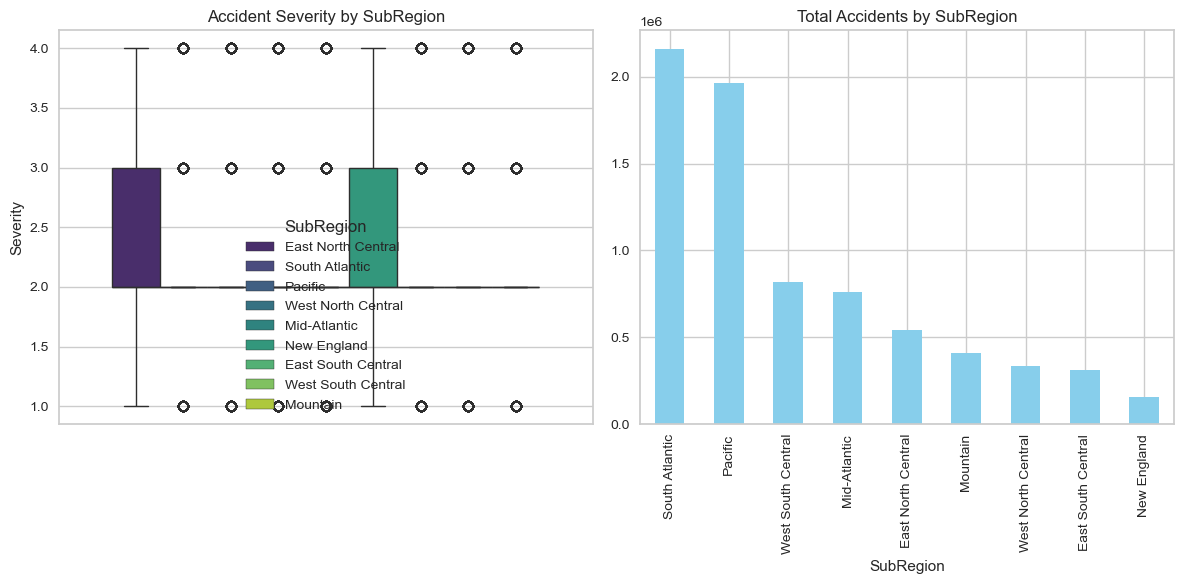

,Severity,Time_of_Impact(hr),Distance(mi)
SubRegion,,,
East North Central,2.370,1.634,0.525
East South Central,2.245,1.585,0.519
Mid-Atlantic,2.235,1.858,0.784
Mountain,2.210,1.711,0.840
New England,2.330,1.679,0.674
Pacific,2.171,1.981,0.528
South Atlantic,2.190,1.869,0.497
West North Central,2.241,1.682,0.802
West South Central,2.191,1.519,0.311


In [106]:
reports,stats = test_results('SubRegion',data)
data.groupby('SubRegion')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different AA_Regions.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different AA_Regions.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different AA_Regions.


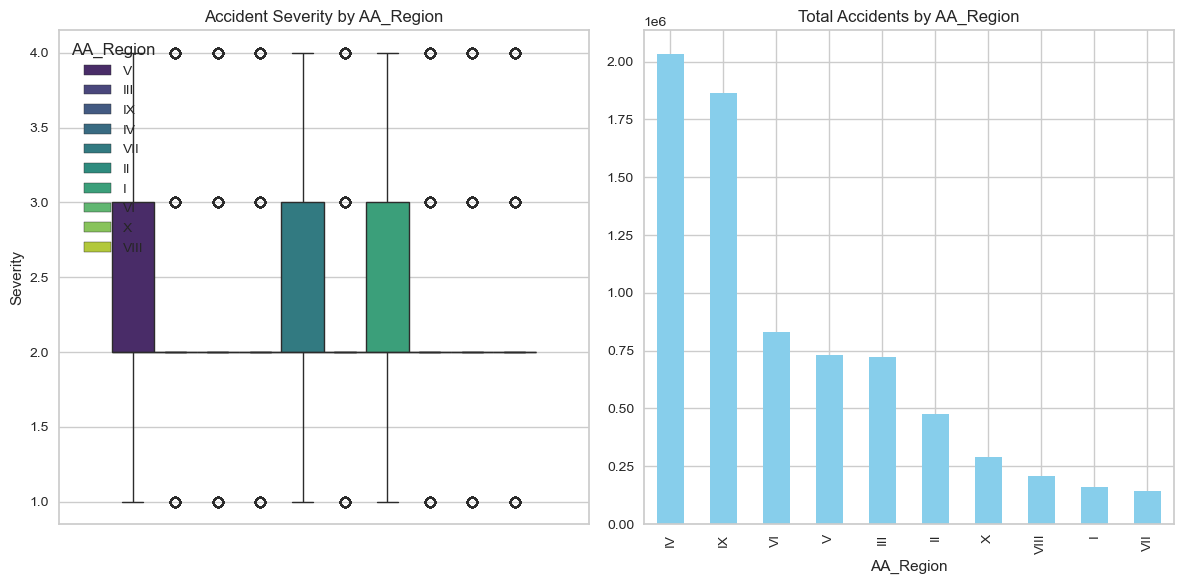

,Severity,Time_of_Impact(hr),Distance(mi)
AA_Region,,,
I,2.330,1.679,0.674
II,2.252,1.946,0.711
III,2.250,1.782,0.796
IV,2.179,1.834,0.451
IX,2.162,1.837,0.490
V,2.317,1.659,0.598
VI,2.193,1.521,0.322
VII,2.347,1.614,0.767
VIII,2.276,1.672,1.052


In [107]:
reports,stats = test_results('AA_Region',data)
data.groupby('AA_Region')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different BEA_Regions.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different BEA_Regions.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different BEA_Regions.


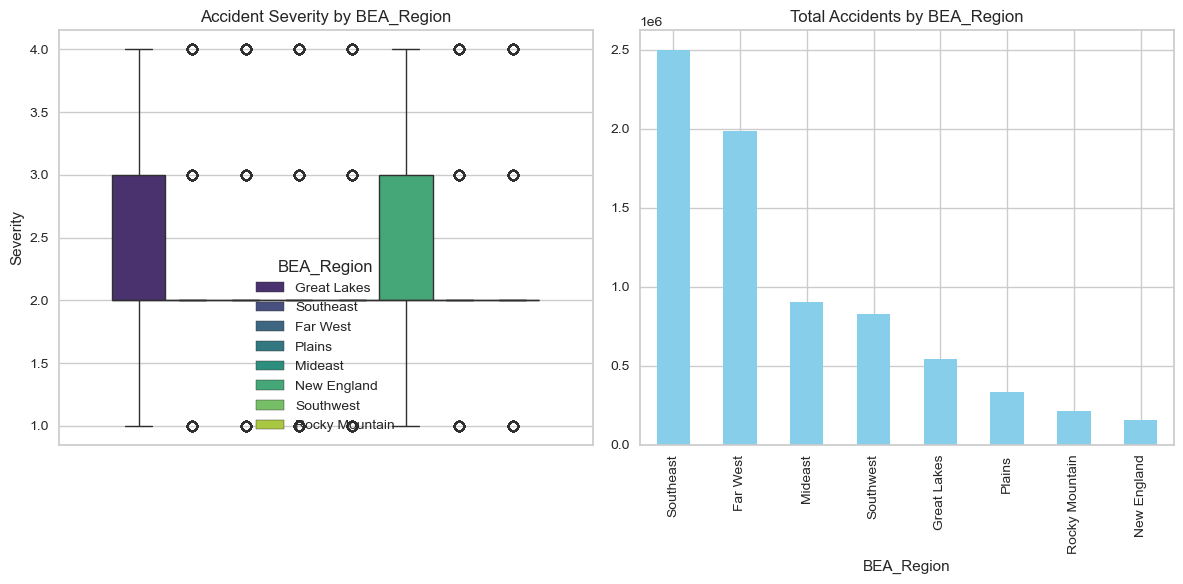

,Severity,Time_of_Impact(hr),Distance(mi)
BEA_Region,,,
Far West,2.171,1.982,0.531
Great Lakes,2.370,1.634,0.525
Mideast,2.244,1.857,0.758
New England,2.330,1.679,0.674
Plains,2.241,1.682,0.802
Rocky Mountain,2.272,1.717,1.054
Southeast,2.188,1.813,0.495
Southwest,2.188,1.543,0.321


In [108]:
reports,stats = test_results('BEA_Region',data)
data.groupby('BEA_Region')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

### By State

In [109]:
states = data['State'].unique()

for state in states:
    print(state + ':')
    data['inState'] = data['State'] == state
    test_results('inState',data,visuals=False)
    print('-'*75)

OH:
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different inStates.
Based on the ANOVA test's p-value of 0.424, we fail to reject the null hypothesis that there is no significant difference in incident distance across different inStates.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different inStates.
---------------------------------------------------------------------------
WV:
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different inStates.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different inStates.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no sig

In [110]:
data.groupby('State')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

,Severity,Time_of_Impact(hr),Distance(mi)
State,,,
AL,2.243,1.418,0.474
AR,2.264,1.728,1.427
AZ,2.116,1.651,0.534
CA,2.166,1.851,0.481
CO,2.438,1.512,0.873
CT,2.346,2.154,1.125
DC,2.137,1.996,0.392
DE,2.254,1.548,0.444
FL,2.141,2.178,0.523


### Federal Roads

Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Federals.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Federals.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Federals.


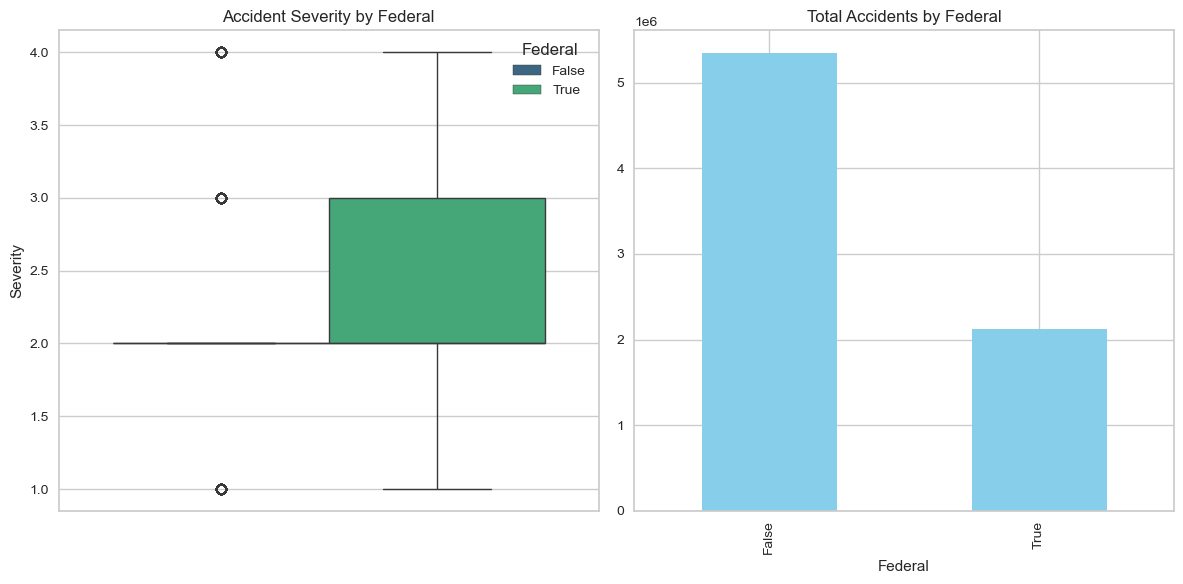

,Severity,Time_of_Impact(hr),Distance(mi)
Federal,,,
False,2.150,1.751,0.354
True,2.367,1.955,1.056


In [111]:
reports,stats = test_results('Federal',data)
data.groupby('Federal')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

### Infrastructure

In [112]:
infrastructures = ['Amenity','Bump','Crossing','Give_Way',
                   'Junction','No_Exit','Railway','Roundabout',
                   'Station','Stop','Traffic_Calming','Traffic_Signal',
                   'Turning_Loop'
                   ]

In [113]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean.csv')
    else:
        data = pd.read_csv('AccidentData_Clean.csv',usecols = infrastructures + ['Severity','Distance(mi)','Time_of_Impact(hr)'])
    

Amenity: 
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Amenitys.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Amenitys.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Amenitys.


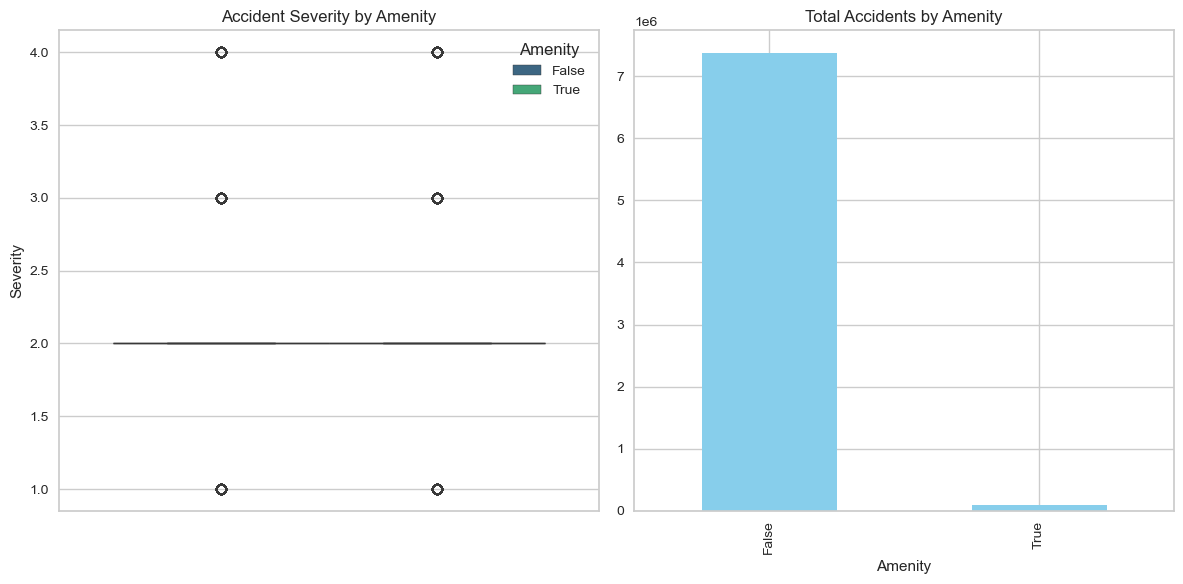

,Severity,Time_of_Impact(hr),Distance(mi)
Amenity,,,
False,2.213,1.810,0.559
True,2.069,1.719,0.128


---------------------------------------------------------------------------
Bump: 
Based on the ANOVA test's p-value of 0.924, we fail to reject the null hypothesis that there is no significant difference in incident time across different Bumps.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Bumps.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Bumps.


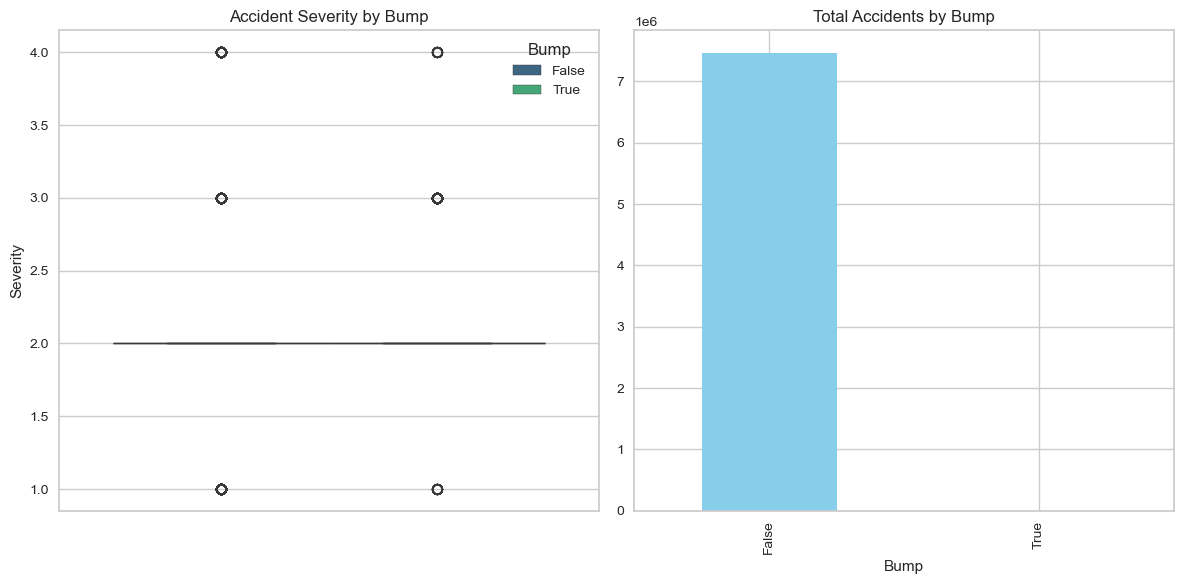

,Severity,Time_of_Impact(hr),Distance(mi)
Bump,,,
False,2.211,1.809,0.553
True,2.095,1.805,0.233


---------------------------------------------------------------------------
Crossing: 
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Crossings.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Crossings.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Crossings.


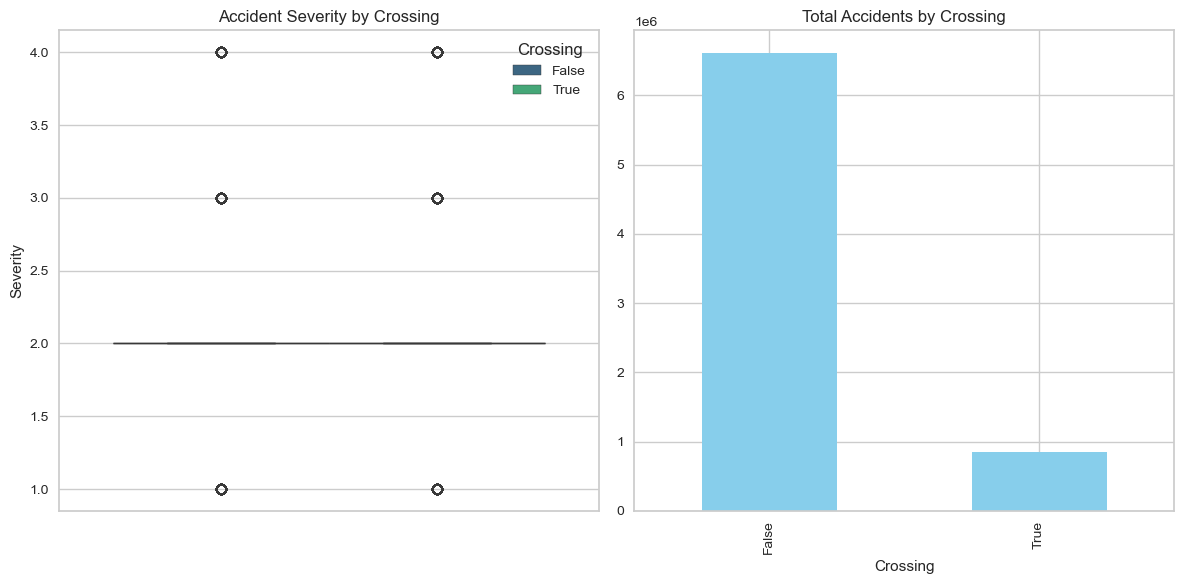

,Severity,Time_of_Impact(hr),Distance(mi)
Crossing,,,
False,2.231,1.831,0.610
True,2.064,1.635,0.113


---------------------------------------------------------------------------
Give_Way: 
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Give_Ways.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Give_Ways.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Give_Ways.


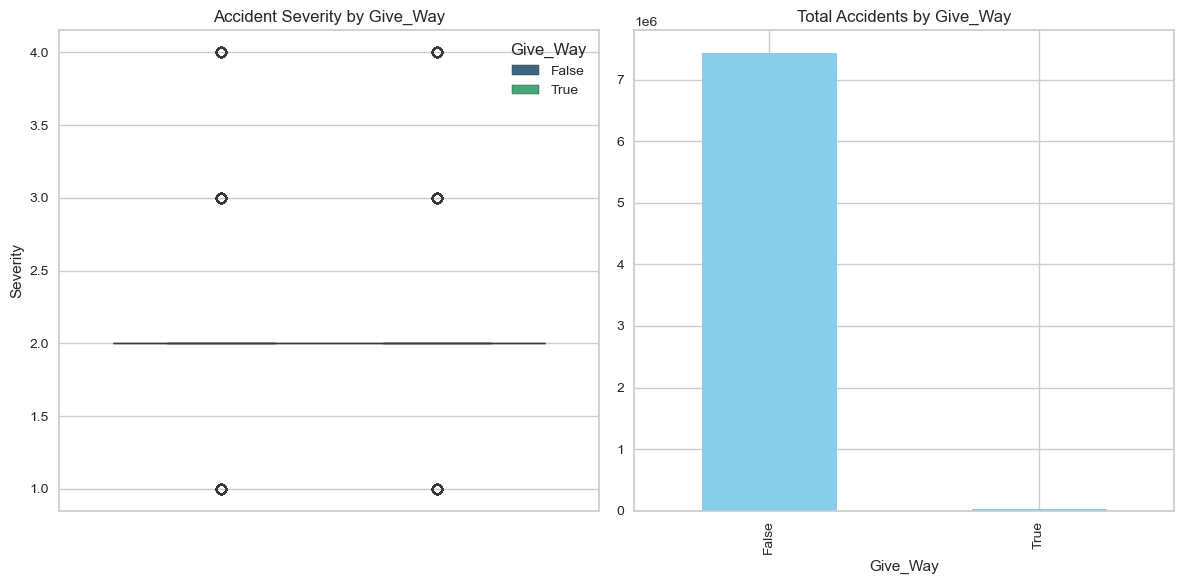

,Severity,Time_of_Impact(hr),Distance(mi)
Give_Way,,,
False,2.212,1.810,0.554
True,2.173,1.546,0.305


---------------------------------------------------------------------------
Junction: 
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Junctions.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Junctions.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Junctions.


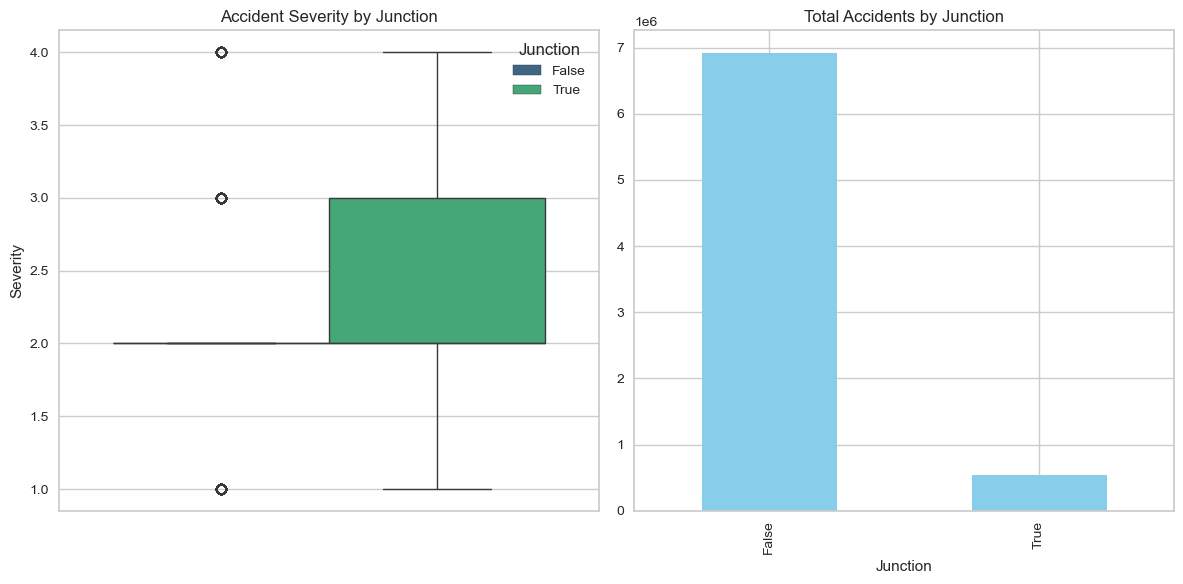

,Severity,Time_of_Impact(hr),Distance(mi)
Junction,,,
False,2.204,1.781,0.538
True,2.299,2.155,0.748


---------------------------------------------------------------------------
No_Exit: 
Based on the ANOVA test's p-value of 0.002, we reject the null hypothesis that there is no significant difference in incident time across different No_Exits.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different No_Exits.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different No_Exits.


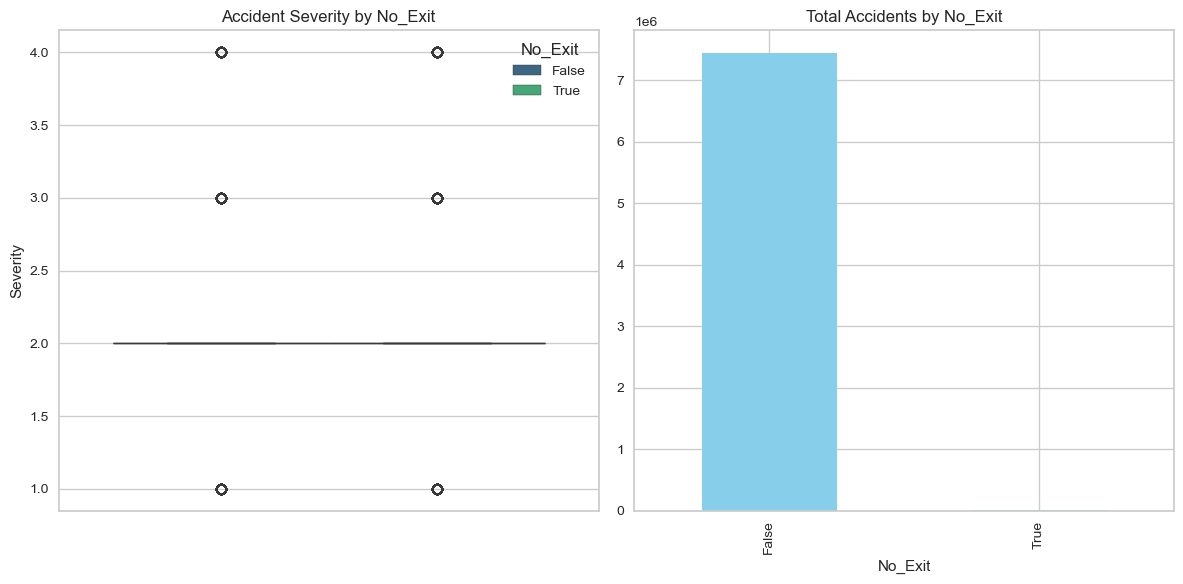

,Severity,Time_of_Impact(hr),Distance(mi)
No_Exit,,,
False,2.212,1.808,0.554
True,2.112,1.855,0.220


---------------------------------------------------------------------------
Railway: 
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Railways.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Railways.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Railways.


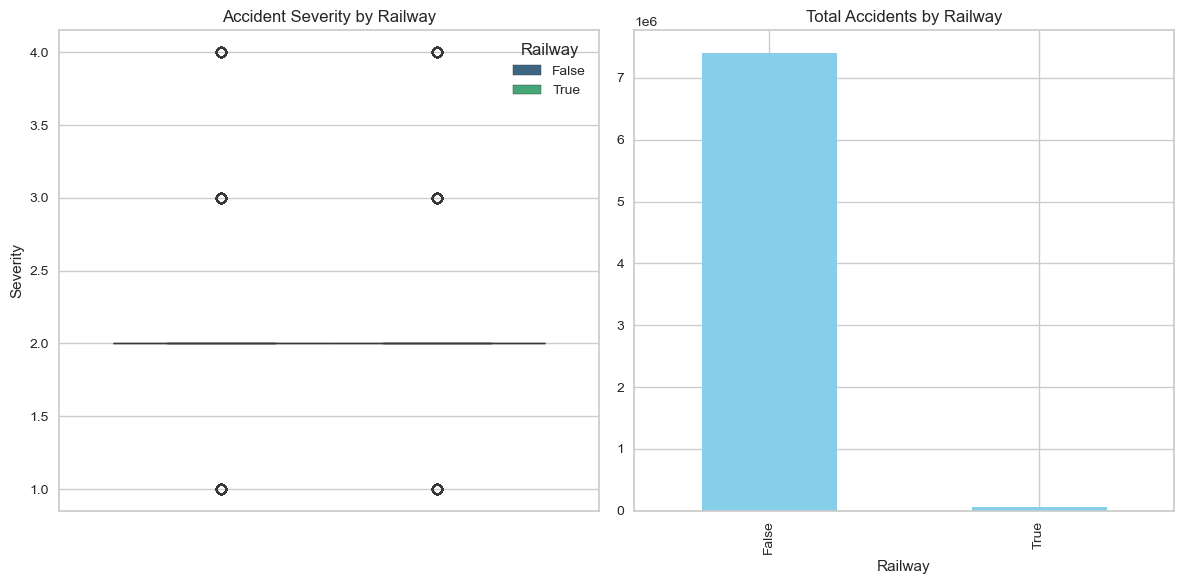

,Severity,Time_of_Impact(hr),Distance(mi)
Railway,,,
False,2.212,1.810,0.556
True,2.152,1.701,0.227


---------------------------------------------------------------------------
Roundabout: 
Based on the ANOVA test's p-value of 0.122, we fail to reject the null hypothesis that there is no significant difference in incident time across different Roundabouts.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Roundabouts.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Roundabouts.


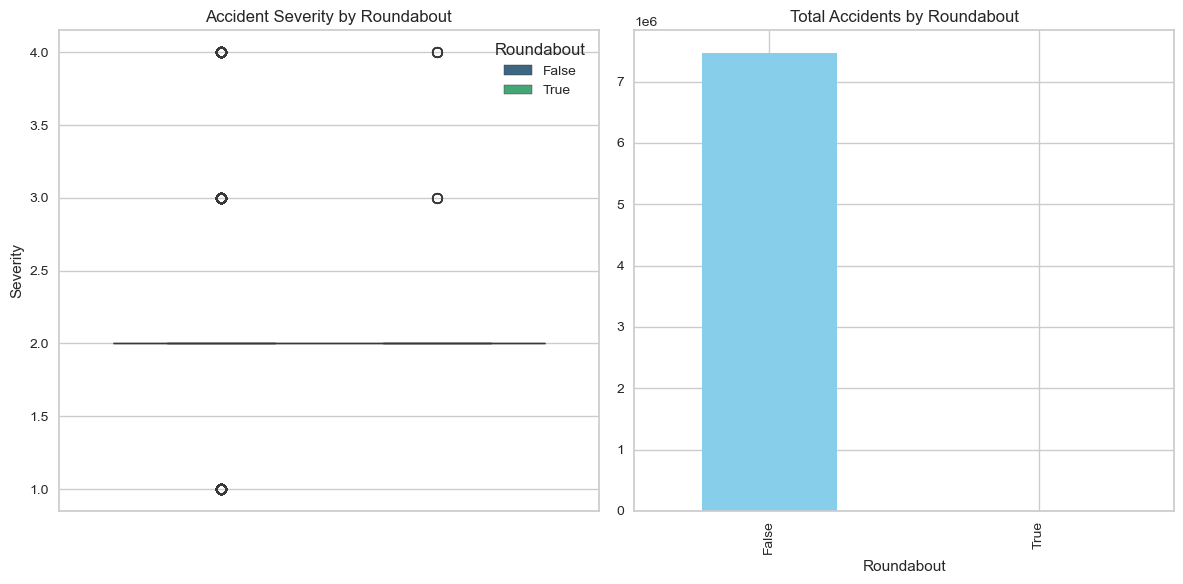

,Severity,Time_of_Impact(hr),Distance(mi)
Roundabout,,,
False,2.211,1.809,0.553
True,2.070,1.601,0.114


---------------------------------------------------------------------------
Station: 
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Stations.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Stations.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Stations.


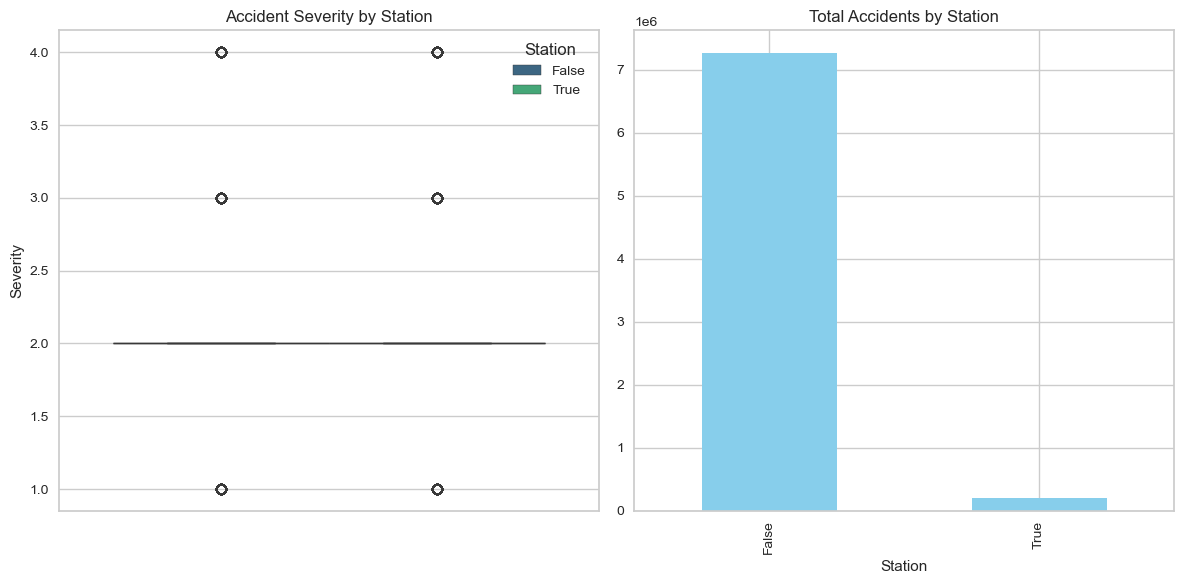

,Severity,Time_of_Impact(hr),Distance(mi)
Station,,,
False,2.215,1.805,0.565
True,2.074,1.950,0.131


---------------------------------------------------------------------------
Stop: 
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Stops.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Stops.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Stops.


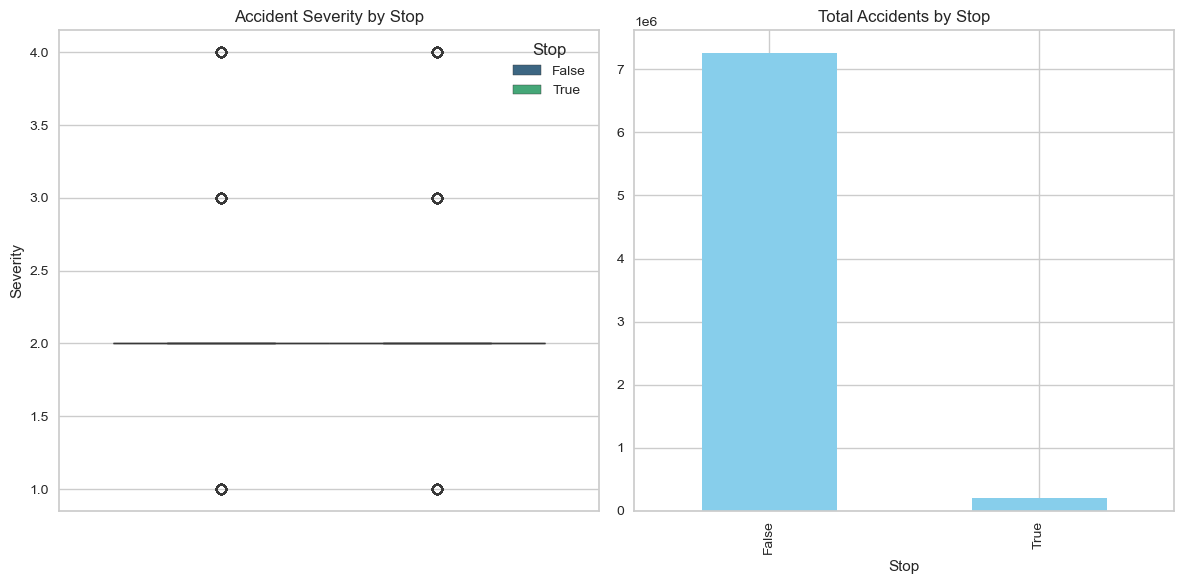

,Severity,Time_of_Impact(hr),Distance(mi)
Stop,,,
False,2.215,1.813,0.563
True,2.075,1.641,0.221


---------------------------------------------------------------------------
Traffic_Calming: 
Based on the ANOVA test's p-value of 0.314, we fail to reject the null hypothesis that there is no significant difference in incident time across different Traffic_Calmings.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Traffic_Calmings.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Traffic_Calmings.


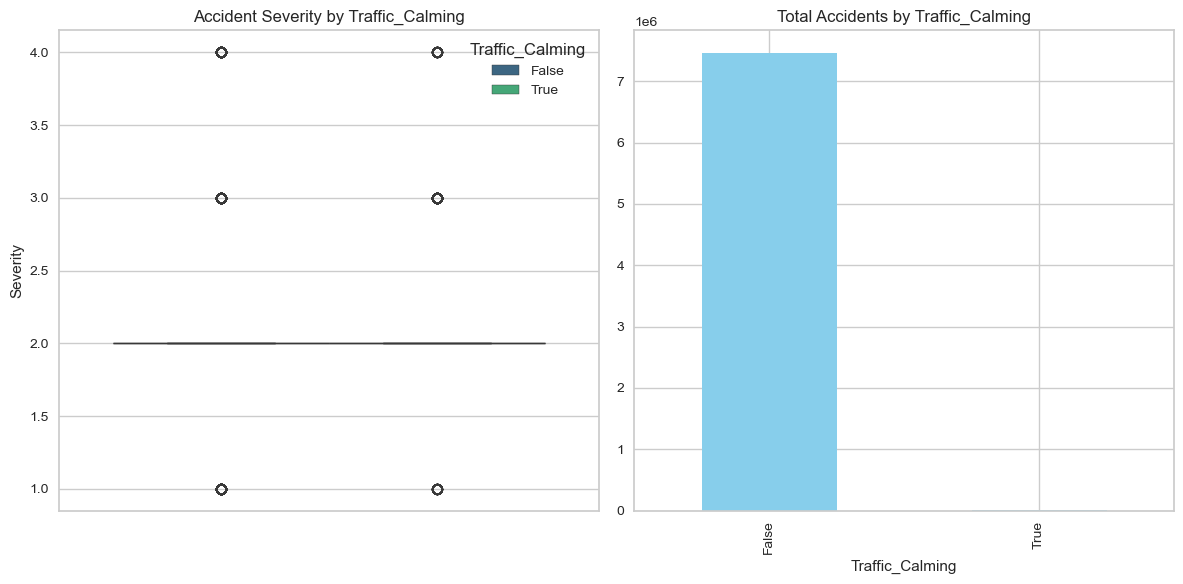

,Severity,Time_of_Impact(hr),Distance(mi)
Traffic_Calming,,,
False,2.211,1.809,0.554
True,2.126,1.833,0.205


---------------------------------------------------------------------------
Traffic_Signal: 
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident time across different Traffic_Signals.
Based on the ANOVA test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident distance across different Traffic_Signals.
Based on the CHI-Squared test's p-value of 0.000, we reject the null hypothesis that there is no significant difference in incident severity across different Traffic_Signals.


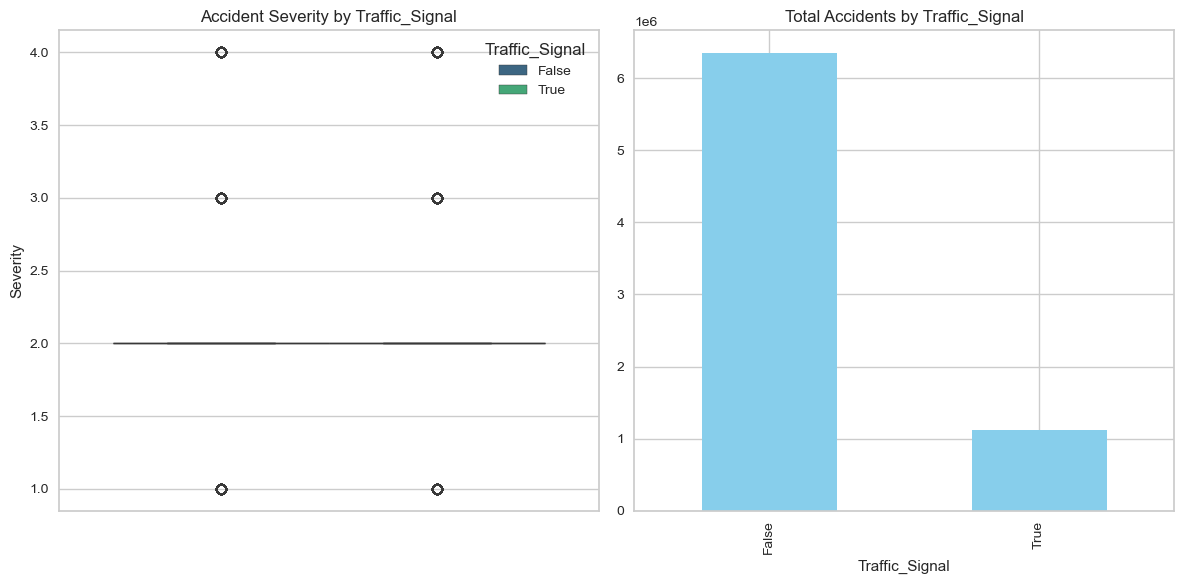

,Severity,Time_of_Impact(hr),Distance(mi)
Traffic_Signal,,,
False,2.233,1.883,0.632
True,2.088,1.386,0.103


---------------------------------------------------------------------------


In [114]:
for structure in infrastructures:
    if data[structure].sum() > 0:
        print(structure+": ")
        reports,stats = test_results(structure,data,visuals=True)
        display(data.groupby(structure)[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean())
        print('-'*75)
    else:
        pass

# 7-Advanced Analysis

## Possible

### Statistical Analyses with Subsets of Data

State-by-State

County-by-County

Year-by-Year

### Other

Interstate

Frequent Coordinates

Commute Data (By State/County)

DBScan on Clustering

Interstate

Infrastructure Cooccurence

## Wish List

### Unusual Weather 

Does driving in unexpected weather--based on area, time of year and/or both--create a higher likelihood of an accident.

### Famous Highways

### Highway's Near Urban Areas

For cross-state

### Naturual Language

Examination of the description feature.

### Safety Infrastructure
Does certain road infrastructure projects help reduce the number of incidents?

### New Traffic Pattern

Does the existence of a new traffic pattern in the area increase the likelihood of an accident?

### Recent Accident Indicator

Does the presence of one accident, predict another.

# 7-Insights & Conclusions

## Basic Insights

### Annual Distinctions

Number of Accidents; Distribution of Severities; Length of Impact

### Temporal & Spatial Considerations

How do accident counts relate to different times of the day and for different region types (urban vs rural)?

### Weather Considerations
Does certain weather conditions produce more severe incidents?  

# Advanced (Wish List) Analysis

## Unusual Weather 

Does driving in unexpected weather--based on area, time of year and/or both--create a higher likelihood of an accident.

## Famous Highways

## Highway's Near Urban Areas

For cross-state

## Naturual Language

Examination of the description feature.

## Safety Infrastructure
Does certain road infrastructure projects help reduce the number of incidents?

## New Traffic Pattern

Does the existence of a new traffic pattern in the area increase the likelihood of an accident?

## Recent Accident Indicator

Does the presence of one accident, predict another.